In [37]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.losses import mean_squared_error as mse
from tensorflow.linalg import expm,logm
from numpy.random import multivariate_normal as mvn

from math import e
import tensorflow.distributions as tfd

In [38]:
sess = tf.InteractiveSession()

/home/teguh/.local/lib/python2.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [39]:
def posterior(params, X, Y,batch_size=50):
    alpha = params[0]    
    YTY = np.dot(Y.T,Y)
    YTY = tf.constant(np.array([YTY]*batch_size).astype(np.float32))
    YTX = np.dot(Y.T,X)
    YTX = tf.constant(np.array([YTX]*batch_size).astype(np.float32))
    XTX = np.dot(X.T,X)    
    XTX = tf.constant(np.array([XTX]*batch_size).astype(np.float32))
    n = X.shape[0]
    d = X.shape[1]-1
    
    def func(theta):
        w = theta[:,:-1]
        lamda = tf.square(theta[:,-1:])
        val = - tfd.Gamma(1.,1.).log_prob(lamda) + 0.5*((n+1)*tf.log(2*np.pi) + tf.log(alpha) - n*tf.log(lamda))  + 0.5*(tf.matmul(tf.transpose(w,perm=[0,2,1]),w))
        val += 0.5*tf.matmul(lamda,(YTY - 2*tf.matmul(YTX,w) + tf.matmul(tf.transpose(w,perm=[0,2,1]), tf.matmul(XTX,w))))
        return val
    return func

In [40]:
def ELBO(params, X, Y, batch_size=50):
    d = int(samples.shape[1])
    n = int(samples.shape[0])
    posterior_data = posterior(params,X,Y, batch_size)   
    
    def func(mu,L,samples):
        L_sym = 0.5*(L+tf.transpose(L))
        mus = tf.tile(tf.expand_dims(mu,0),[batch_size,1,1]) 
        Ls = tf.tile(tf.expand_dims(L_sym,0),[batch_size,1,1])
        thetas = mus + tf.matmul(expm(Ls), samples)
        
        val = 0.5*d*(tf.log(2*np.pi)+1) + tf.trace(L)
        val -= tf.reduce_sum(posterior_data(thetas),0)/n
        return val
        
    return func

In [41]:
def predict(x, mu, Sigma):
    n = x.shape[0]
    d = x.shape[2]
    w = tf.tile(tf.expand_dims(mu[:-1],0), [n,1,1])
    sigma_w = tf.tile(tf.expand_dims(Sigma[:-1,:-1],0),[n,1,1])
    lamda =tf.tile(tf.expand_dims(1./tf.square(mu[-1:]),0), [n,1,1])
    
    y_pred = tf.matmul(x,w)
    y_cov = lamda + tf.matmul(x, tf.matmul(sigma_w,tf.transpose(x,perm=[0,2,1])))
    return y_pred,y_cov

In [42]:
def calc_MSLL(y_pred, y_cov, y_true, train_mean, train_var):
    n = y_pred.shape[0]
    MSLL = 0
    for i in range(n):
        SLL_trivial = 0.5*np.log(2*np.pi*train_var) + ((train_mean-y_true[i])**2)/(2*train_var)
        MSLL += 0.5*np.log(2*np.pi*y_cov[i]) + ((y_pred[i]-y_true[i])**2)/(2*y_cov[0]) - SLL_trivial
    MSLL /= n
    return MSLL

### Generate simple dataset 

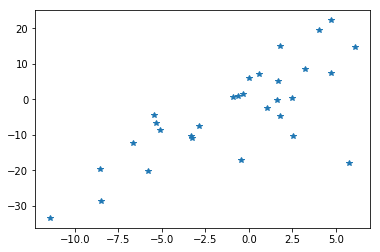

In [43]:
N= 30
X = np.hstack([np.ones((N,1)), 5*np.random.normal(size=(N,1))])
D = X.shape[1]
w_true = 3*np.random.normal(size=[D,1])
Y = np.dot(X,w_true) + 10*np.random.normal(size=[N,1])
plt.plot(X[:,1],Y,'*')

### GVA by minimizing -ELBO 

In [44]:
alpha = 10000.
params = [alpha]

D_in = X.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))

X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [45]:
error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(params,X,Y,1)(tf.expand_dims(mu,0))
samples = tf.placeholder(tf.float32,shape=(batch_size, D_in,1))
elbo_data = ELBO(params, X, Y, batch_size)
elbo = elbo_data(mu,L,samples)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [46]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


#### Run Optimization

In [47]:
for i in range(3000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in))[:,None] for j in range(batch_size)])
    _,elbo_,mu_,e_ = sess.run([train,elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,elbo_,e_

0 [[-40696.16]] 125.93431
1 [[-32779.555]] 119.4072
2 [[-42906.67]] 113.360725
3 [[-19124.277]] 108.222855
4 [[-13367.668]] 103.64948
5 [[-10428.279]] 99.66813
6 [[-9304.243]] 96.271225
7 [[-7527.056]] 93.383835
8 [[-6726.622]] 91.03321
9 [[-4607.3584]] 89.06431
10 [[-4268.8433]] 87.39262
11 [[-3664.3533]] 85.92761
12 [[-2756.1597]] 84.655975
13 [[-2727.8394]] 83.57579
14 [[-2289.2202]] 82.68035
15 [[-2130.249]] 81.92677
16 [[-1777.2441]] 81.30238
17 [[-1628.9883]] 80.76883
18 [[-1420.2306]] 80.31332
19 [[-1161.9293]] 79.93319
20 [[-1029.6194]] 79.61082
21 [[-828.51245]] 79.341034
22 [[-895.9324]] 79.1183
23 [[-799.3099]] 78.93022
24 [[-852.3845]] 78.77524
25 [[-895.0011]] 78.646965
26 [[-578.66315]] 78.54066
27 [[-651.8094]] 78.454216
28 [[-614.43994]] 78.38273
29 [[-615.1829]] 78.32455
30 [[-632.3205]] 78.27778
31 [[-748.54596]] 78.240074
32 [[-600.7519]] 78.20959
33 [[-675.4846]] 78.18594
34 [[-452.85168]] 78.16753
35 [[-575.6899]] 78.153114
36 [[-504.2127]] 78.14189
37 [[-524.54016

334 [[-219.17278]] 78.1923
335 [[-220.25058]] 78.19275
336 [[-206.15607]] 78.19312
337 [[-220.7991]] 78.1937
338 [[-193.94669]] 78.19421
339 [[-181.04944]] 78.19478
340 [[-165.59258]] 78.19541
341 [[-152.89207]] 78.19606
342 [[-162.1103]] 78.19676
343 [[-162.47829]] 78.19752
344 [[-159.16112]] 78.198326
345 [[-160.38834]] 78.199135
346 [[-164.29718]] 78.199936
347 [[-192.04929]] 78.20069
348 [[-192.6004]] 78.20141
349 [[-183.87468]] 78.202156
350 [[-182.3023]] 78.203026
351 [[-189.71446]] 78.20387
352 [[-181.53612]] 78.204765
353 [[-203.58711]] 78.20564
354 [[-204.1169]] 78.2067
355 [[-185.57999]] 78.20791
356 [[-192.06874]] 78.20912
357 [[-192.49438]] 78.210526
358 [[-190.8189]] 78.21188
359 [[-185.38309]] 78.21322
360 [[-192.60219]] 78.21455
361 [[-206.22142]] 78.21597
362 [[-213.20259]] 78.21757
363 [[-204.90962]] 78.21934
364 [[-221.03513]] 78.22122
365 [[-222.28473]] 78.22323
366 [[-209.2779]] 78.225365
367 [[-213.3064]] 78.227585
368 [[-227.0299]] 78.229996
369 [[-242.67253]] 78.

632 [[-950.80176]] 78.415665
633 [[-1245.2338]] 78.42386
634 [[-1593.7009]] 78.43722
635 [[-1911.0891]] 78.464264
636 [[-2184.359]] 78.505646
637 [[-2604.7131]] 78.56919
638 [[-2871.427]] 78.67496
639 [[-3092.7256]] 78.818
640 [[-2892.5215]] 78.96963
641 [[-3250.5793]] 79.144264
642 [[-3131.9348]] 79.297676
643 [[-3376.7466]] 79.41438
644 [[-3152.3542]] 79.511345
645 [[-2797.164]] 79.54521
646 [[-2895.4563]] 79.531
647 [[-3020.2944]] 79.47768
648 [[-2904.0864]] 79.3887
649 [[-3019.062]] 79.28115
650 [[-2779.9734]] 79.153336
651 [[-2875.3894]] 79.019325
652 [[-2798.9744]] 78.89924
653 [[-2322.8523]] 78.794556
654 [[-2630.4365]] 78.70842
655 [[-2386.8022]] 78.640755
656 [[-2269.7725]] 78.595314
657 [[-2212.8318]] 78.56895
658 [[-2032.3153]] 78.55722
659 [[-1916.3998]] 78.54762
660 [[-1868.4924]] 78.54282
661 [[-1752.9955]] 78.52969
662 [[-1703.2162]] 78.51001
663 [[-1601.2744]] 78.48316
664 [[-1614.2236]] 78.45463
665 [[-1428.182]] 78.42346
666 [[-1298.2715]] 78.39326
667 [[-1341.6278]] 

931 [[-134.07797]] 78.4783
932 [[-139.80753]] 78.48225
933 [[-135.80641]] 78.48626
934 [[-138.12022]] 78.49033
935 [[-138.57169]] 78.49431
936 [[-138.16844]] 78.49837
937 [[-145.04317]] 78.50246
938 [[-152.8865]] 78.50652
939 [[-226.5832]] 78.51076
940 [[-354.2095]] 78.51553
941 [[-565.44574]] 78.52202
942 [[-619.36304]] 78.535164
943 [[-915.8988]] 78.55184
944 [[-1058.6564]] 78.578514
945 [[-1351.9108]] 78.62076
946 [[-1737.4899]] 78.699
947 [[-1597.284]] 78.850716
948 [[-2231.6067]] 79.06892
949 [[-2031.7295]] 79.453705
950 [[-1812.4777]] 79.99044
951 [[-2555.7815]] 80.614944
952 [[-2426.7546]] 81.51165
953 [[-2539.067]] 82.62824
954 [[-2164.2212]] 83.94398
955 [[-2251.4958]] 85.21525
956 [[-2319.6272]] 86.39467
957 [[-2193.044]] 87.431694
958 [[-2215.2432]] 88.1366
959 [[-2168.4265]] 88.46841
960 [[-1942.362]] 88.52794
961 [[-1913.0668]] 88.181915
962 [[-1967.4945]] 87.50723
963 [[-1836.1556]] 86.64881
964 [[-1686.3818]] 85.63998
965 [[-1634.5035]] 84.51473
966 [[-1541.7861]] 83.395

1227 [[-226.6012]] 78.79892
1228 [[-243.99527]] 78.79229
1229 [[-258.7022]] 78.7847
1230 [[-233.23314]] 78.77729
1231 [[-250.49675]] 78.76806
1232 [[-244.07683]] 78.75801
1233 [[-233.50182]] 78.74709
1234 [[-244.39862]] 78.735374
1235 [[-242.35634]] 78.72317
1236 [[-224.7273]] 78.711006
1237 [[-226.77492]] 78.697685
1238 [[-231.42897]] 78.68444
1239 [[-225.12477]] 78.67128
1240 [[-230.3104]] 78.65768
1241 [[-219.45877]] 78.6445
1242 [[-217.52141]] 78.63205
1243 [[-208.92877]] 78.61983
1244 [[-207.01016]] 78.60805
1245 [[-203.31438]] 78.59695
1246 [[-200.70898]] 78.586395
1247 [[-195.45857]] 78.57671
1248 [[-190.69826]] 78.56754
1249 [[-183.7519]] 78.5592
1250 [[-180.68541]] 78.55122
1251 [[-175.21367]] 78.54387
1252 [[-173.34229]] 78.537056
1253 [[-166.22598]] 78.53057
1254 [[-174.99942]] 78.5245
1255 [[-164.89986]] 78.51924
1256 [[-155.37921]] 78.51458
1257 [[-157.92291]] 78.51025
1258 [[-152.29974]] 78.50633
1259 [[-150.79823]] 78.502556
1260 [[-150.0434]] 78.49914
1261 [[-153.1492]]

1520 [[-255.70284]] 78.185196
1521 [[-269.01242]] 78.18628
1522 [[-285.23553]] 78.18745
1523 [[-264.97543]] 78.188675
1524 [[-263.31308]] 78.18989
1525 [[-251.26207]] 78.19109
1526 [[-255.86319]] 78.19223
1527 [[-232.04997]] 78.19331
1528 [[-243.80344]] 78.194405
1529 [[-245.96036]] 78.19555
1530 [[-255.4783]] 78.19666
1531 [[-231.21565]] 78.19799
1532 [[-246.15053]] 78.19929
1533 [[-246.26146]] 78.20057
1534 [[-248.20648]] 78.20192
1535 [[-238.64676]] 78.20338
1536 [[-237.6752]] 78.20487
1537 [[-232.95837]] 78.20637
1538 [[-230.20937]] 78.20783
1539 [[-242.06883]] 78.20939
1540 [[-230.02812]] 78.21102
1541 [[-224.86159]] 78.21264
1542 [[-229.37862]] 78.214264
1543 [[-218.03519]] 78.21592
1544 [[-218.7367]] 78.21758
1545 [[-229.83961]] 78.219215
1546 [[-217.32182]] 78.22094
1547 [[-223.07465]] 78.22279
1548 [[-219.53683]] 78.224754
1549 [[-215.66324]] 78.226685
1550 [[-211.0874]] 78.22861
1551 [[-207.9704]] 78.23045
1552 [[-217.11795]] 78.23232
1553 [[-214.59718]] 78.23416
1554 [[-210.

1816 [[-141.19893]] 79.15282
1817 [[-139.62192]] 79.15599
1818 [[-142.17792]] 79.15918
1819 [[-140.03311]] 79.16223
1820 [[-143.03113]] 79.16524
1821 [[-141.38803]] 79.16821
1822 [[-138.81612]] 79.17107
1823 [[-142.49983]] 79.17393
1824 [[-139.56831]] 79.17659
1825 [[-136.9458]] 79.17924
1826 [[-137.54684]] 79.1819
1827 [[-141.21843]] 79.1845
1828 [[-141.26476]] 79.18704
1829 [[-138.88795]] 79.18948
1830 [[-140.92523]] 79.19181
1831 [[-140.99515]] 79.194
1832 [[-141.53024]] 79.196205
1833 [[-140.82738]] 79.19822
1834 [[-138.87796]] 79.200035
1835 [[-143.15303]] 79.20182
1836 [[-140.76244]] 79.20345
1837 [[-140.40025]] 79.204865
1838 [[-136.98552]] 79.20628
1839 [[-136.80507]] 79.20767
1840 [[-141.63844]] 79.20896
1841 [[-140.3576]] 79.21011
1842 [[-136.68442]] 79.21126
1843 [[-148.42955]] 79.212364
1844 [[-138.72333]] 79.21316
1845 [[-141.16255]] 79.21384
1846 [[-139.08078]] 79.214424
1847 [[-137.03697]] 79.21489
1848 [[-141.59764]] 79.21534
1849 [[-140.2471]] 79.21581
1850 [[-144.6937

2107 [[-133.9052]] 79.27129
2108 [[-133.22517]] 79.271484
2109 [[-134.72855]] 79.27166
2110 [[-133.25612]] 79.272
2111 [[-133.37796]] 79.27245
2112 [[-132.30957]] 79.27277
2113 [[-133.2621]] 79.27327
2114 [[-132.71965]] 79.27371
2115 [[-134.00139]] 79.274216
2116 [[-134.78404]] 79.27468
2117 [[-132.17339]] 79.27509
2118 [[-131.81464]] 79.27551
2119 [[-132.78206]] 79.27602
2120 [[-131.06007]] 79.27651
2121 [[-131.99022]] 79.27706
2122 [[-131.51076]] 79.27771
2123 [[-134.48312]] 79.27848
2124 [[-133.9504]] 79.279396
2125 [[-134.47978]] 79.28036
2126 [[-134.2927]] 79.28132
2127 [[-133.3343]] 79.28226
2128 [[-131.42653]] 79.28331
2129 [[-133.29178]] 79.28452
2130 [[-131.67319]] 79.28566
2131 [[-131.71243]] 79.28678
2132 [[-136.27393]] 79.28799
2133 [[-131.97284]] 79.28906
2134 [[-133.05856]] 79.290146
2135 [[-135.47345]] 79.29129
2136 [[-132.25095]] 79.29235
2137 [[-133.47719]] 79.29341
2138 [[-135.00766]] 79.29455
2139 [[-131.0787]] 79.29544
2140 [[-132.44978]] 79.296364
2141 [[-135.22859

2397 [[-456.86975]] 79.055855
2398 [[-450.32523]] 78.95972
2399 [[-460.70605]] 78.8669
2400 [[-496.48007]] 78.77835
2401 [[-477.19077]] 78.6938
2402 [[-496.19092]] 78.61629
2403 [[-472.64844]] 78.545746
2404 [[-509.5703]] 78.482735
2405 [[-498.91675]] 78.42696
2406 [[-491.52014]] 78.37847
2407 [[-493.3785]] 78.33698
2408 [[-475.09973]] 78.3018
2409 [[-458.32715]] 78.27267
2410 [[-474.58725]] 78.24901
2411 [[-445.72906]] 78.22993
2412 [[-464.21677]] 78.21474
2413 [[-441.26285]] 78.20269
2414 [[-437.51077]] 78.19303
2415 [[-425.41568]] 78.18525
2416 [[-428.38934]] 78.17891
2417 [[-418.8822]] 78.17359
2418 [[-413.463]] 78.169136
2419 [[-401.5826]] 78.165405
2420 [[-396.69653]] 78.16209
2421 [[-396.41684]] 78.15887
2422 [[-381.89612]] 78.15566
2423 [[-379.83493]] 78.15262
2424 [[-351.9066]] 78.14964
2425 [[-351.67776]] 78.14644
2426 [[-356.09735]] 78.14314
2427 [[-351.05347]] 78.140205
2428 [[-346.8664]] 78.137566
2429 [[-315.17157]] 78.135086
2430 [[-314.8897]] 78.13268
2431 [[-342.4911]]

2694 [[-130.87314]] 79.005104
2695 [[-133.89146]] 79.00859
2696 [[-130.69649]] 79.01205
2697 [[-136.331]] 79.01543
2698 [[-131.66115]] 79.018745
2699 [[-129.91953]] 79.02212
2700 [[-135.07558]] 79.02568
2701 [[-132.88853]] 79.02942
2702 [[-132.42168]] 79.03324
2703 [[-132.97827]] 79.0373
2704 [[-131.63246]] 79.04149
2705 [[-132.70012]] 79.04562
2706 [[-134.38437]] 79.04969
2707 [[-135.27927]] 79.0537
2708 [[-133.27917]] 79.05782
2709 [[-134.24347]] 79.06217
2710 [[-133.19223]] 79.066574
2711 [[-129.3434]] 79.07102
2712 [[-134.62296]] 79.075485
2713 [[-130.52773]] 79.0799
2714 [[-132.30527]] 79.08421
2715 [[-131.35957]] 79.08869
2716 [[-131.95355]] 79.093185
2717 [[-130.82846]] 79.09768
2718 [[-132.17712]] 79.101944
2719 [[-135.87724]] 79.105835
2720 [[-132.8137]] 79.10954
2721 [[-136.48985]] 79.11321
2722 [[-135.34396]] 79.11647
2723 [[-132.19998]] 79.119545
2724 [[-130.57527]] 79.12249
2725 [[-131.57806]] 79.12525
2726 [[-133.96243]] 79.127914
2727 [[-134.04524]] 79.13045
2728 [[-133.

2992 [[-126.058395]] 79.39504
2993 [[-125.682846]] 79.39777
2994 [[-127.569664]] 79.40074
2995 [[-127.98359]] 79.40391
2996 [[-127.131065]] 79.40724
2997 [[-126.81426]] 79.41066
2998 [[-128.11441]] 79.41416
2999 [[-126.148026]] 79.417534


### Plot

In [48]:
sigma_ = expm(2*L).eval()
sig = np.sqrt(1/(mu_[2,0]**2))
print mu_, w_true

[[-0.6480004 ]
 [ 2.072651  ]
 [ 0.12335041]] [[-4.18956011]
 [ 1.96570845]]


[-0.58383234  2.2229093   0.02686702]
[-0.67488288  2.02115067  0.1158681 ]
[-0.64088369  2.08323219  0.07898688]
[-0.67531527  2.07157123  0.02874037]
[-0.64836258  2.05950558  0.13709546]
[-0.57936035  2.14419945  0.23122631]
[-0.71049709  1.95828788  0.11611489]
[-0.58391861  2.19752366  0.13010373]
[-0.58463535  2.16160115  0.14865796]
[-0.60049743  2.16375301  0.10324434]
[-0.65080376  2.10171787  0.06384657]
[-0.60425267  2.12726564  0.16520285]
[-0.55937257  2.2105302   0.154441  ]
[-0.62914626  2.09409792  0.12395843]
[-0.63641098  2.08748496  0.07479357]
[-0.62239418  2.12996119  0.07910714]
[-0.6203399   2.12919473  0.118937  ]
[-0.70035058  1.99933069  0.09081876]
[-0.63870535  2.07330118  0.11219718]
[-0.63548851  2.11420449  0.07232697]
[-0.62694831  2.10013466  0.1235096 ]
[-0.69194501  1.98845041  0.13371672]
[-0.59300608  2.15286432  0.13161969]
[-0.63032451  2.11448934  0.05785085]
[-0.53971705  2.24339531  0.08295288]
[-0.68346049  2.03177624  0.1148909 ]
[-0.58450388

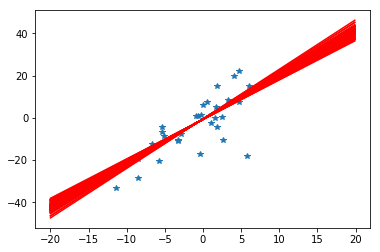

In [49]:
plt.plot(X[:,1],Y,'*')
x_test = np.arange(-20,20,0.1)[:,None]
X_test = np.hstack([np.ones((x_test.shape[0],1)),x_test])
for i in range(100):
    sample_mu = mvn(mu_[:,0], sigma_)
    print sample_mu
    y_pred = np.dot(X_test,sample_mu[:-1])
    plt.plot(x_test, y_pred, '-r')

### Test on SARCOS Inverse Dynamics

### Load Data 

In [50]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

In [51]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

X_test = np.hstack([np.ones((x_test.shape[0],1)), x_test])
Y_test = y_test.copy()

### Standard Linear Regression

In [52]:
reg = 0.00001
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+reg*np.eye(X.shape[1])),X.T),Y)

y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), w)
smse_train = mean_squared_error(y_pred,y_train)/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), w)
smse_test = mean_squared_error(y_pred,y_test)/y_var

print smse_train,smse_test

0.07358881422797761 0.0742260930366048


## Bayesian Linear Regression

In [53]:
alpha = 10000.
params = [alpha]
D_in = X.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))
sigma = expm(2*L)

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(params,X,Y,1)(tf.expand_dims(mu,0))
samples = tf.placeholder(tf.float32,shape=(batch_size, D_in,1))

elbo_data = ELBO(params, X, Y,batch_size)
elbo = elbo_data(mu,L,samples)

### Calculate Posterior Using GVA 

In [54]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [55]:
for i in range(18000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in))[:,None] for j in range(batch_size)])
    _,elbo_,mu_, sigma_, e_ = sess.run([train, elbo,mu,sigma,error_mse],feed_dict={samples:cur_samples})
    print i,elbo_,e_

0 [[-8.9366464e+08]] 1118.0889
1 [[-1.2944986e+09]] 918.49414
2 [[-6.5660006e+08]] 751.90027
3 [[-4.399868e+08]] 624.47833
4 [[-2.6985293e+08]] 528.4632
5 [[-2.5979994e+08]] 461.0947
6 [[-1.4820355e+08]] 418.47028
7 [[-1.2107483e+08]] 392.8269
8 [[-69182540.]] 378.68903
9 [[-64513308.]] 372.89282
10 [[-54583944.]] 372.98795
11 [[-84506660.]] 376.7359
12 [[-58143884.]] 380.59567
13 [[-56762620.]] 384.614
14 [[-44541932.]] 387.7894
15 [[-43536116.]] 389.45154
16 [[-46312104.]] 390.01654
17 [[-35569824.]] 389.0096
18 [[-29908474.]] 386.31693
19 [[-34776420.]] 382.5815
20 [[-19090102.]] 378.0009
21 [[-18950110.]] 372.82794
22 [[-21819238.]] 367.30377
23 [[-19055436.]] 361.05167
24 [[-12998683.]] 354.49966
25 [[-13147696.]] 347.8874
26 [[-19201314.]] 341.37296
27 [[-12478079.]] 334.81525
28 [[-13437085.]] 328.19894
29 [[-16362148.]] 321.55524
30 [[-10946280.]] 315.02438
31 [[-12299458.]] 308.69595
32 [[-9818927.]] 302.58694
33 [[-10099464.]] 296.74557
34 [[-9319802.]] 291.3058
35 [[-6902846

305 [[-7653315.]] 107.2643
306 [[-6225959.5]] 105.97161
307 [[-4867910.]] 104.76556
308 [[-5392698.5]] 103.64531
309 [[-5322124.]] 102.60909
310 [[-4038356.2]] 101.666534
311 [[-4332011.5]] 100.80865
312 [[-4200511.]] 100.005516
313 [[-3399120.]] 99.23966
314 [[-3298136.]] 98.51125
315 [[-3920673.5]] 97.835434
316 [[-3442958.5]] 97.17584
317 [[-2573706.5]] 96.53489
318 [[-2890530.]] 95.93361
319 [[-2592743.5]] 95.35514
320 [[-2527109.]] 94.79729
321 [[-2557380.8]] 94.259674
322 [[-2672241.5]] 93.74266
323 [[-2391645.5]] 93.23886
324 [[-1846128.9]] 92.76319
325 [[-2084293.5]] 92.325195
326 [[-1675748.]] 91.90015
327 [[-1680239.9]] 91.495316
328 [[-1590561.9]] 91.12042
329 [[-1530083.]] 90.767914
330 [[-1871188.1]] 90.45015
331 [[-1521699.6]] 90.14106
332 [[-1467344.5]] 89.83411
333 [[-1393068.5]] 89.548615
334 [[-1325245.1]] 89.258095
335 [[-1034978.3]] 88.994675
336 [[-1066074.8]] 88.75012
337 [[-1132646.8]] 88.5225
338 [[-1466652.5]] 88.29474
339 [[-1093014.5]] 88.05504
340 [[-1149815

619 [[-407740.84]] 68.55404
620 [[-395994.3]] 68.51154
621 [[-546353.7]] 68.469475
622 [[-439562.22]] 68.42484
623 [[-416135.6]] 68.379845
624 [[-495747.25]] 68.33621
625 [[-371023.53]] 68.291534
626 [[-441562.84]] 68.247574
627 [[-423569.94]] 68.2034
628 [[-470262.16]] 68.15948
629 [[-456425.84]] 68.114334
630 [[-372696.4]] 68.06843
631 [[-442973.97]] 68.023766
632 [[-361470.3]] 67.979614
633 [[-433788.16]] 67.937416
634 [[-389342.]] 67.895706
635 [[-432794.22]] 67.85463
636 [[-460013.8]] 67.81394
637 [[-412219.97]] 67.77368
638 [[-392637.06]] 67.733635
639 [[-480925.22]] 67.69386
640 [[-366257.8]] 67.653366
641 [[-476410.34]] 67.613655
642 [[-389962.97]] 67.57323
643 [[-436029.1]] 67.53385
644 [[-457813.16]] 67.494804
645 [[-461870.12]] 67.454445
646 [[-364045.72]] 67.41421
647 [[-396558.47]] 67.37508
648 [[-373476.4]] 67.33684
649 [[-394243.2]] 67.29891
650 [[-457312.6]] 67.26125
651 [[-539095.06]] 67.221855
652 [[-544510.7]] 67.17882
653 [[-581167.2]] 67.1337
654 [[-766369.]] 67.08

916 [[-312363.75]] 55.73897
917 [[-339435.16]] 55.713898
918 [[-341055.9]] 55.68901
919 [[-342064.16]] 55.66479
920 [[-318304.5]] 55.640793
921 [[-351579.22]] 55.617176
922 [[-392875.75]] 55.59333
923 [[-311297.56]] 55.569397
924 [[-271853.53]] 55.545723
925 [[-275118.84]] 55.52274
926 [[-350995.7]] 55.500618
927 [[-311395.88]] 55.477757
928 [[-314346.88]] 55.45481
929 [[-326452.25]] 55.43244
930 [[-320994.66]] 55.410255
931 [[-305166.06]] 55.388893
932 [[-265944.47]] 55.36759
933 [[-296771.22]] 55.3467
934 [[-306535.97]] 55.325848
935 [[-277794.22]] 55.3052
936 [[-279015.9]] 55.284874
937 [[-313089.44]] 55.26505
938 [[-368238.66]] 55.245075
939 [[-301473.94]] 55.2248
940 [[-283037.75]] 55.204792
941 [[-299408.53]] 55.18498
942 [[-308092.97]] 55.16521
943 [[-281813.8]] 55.14546
944 [[-328493.03]] 55.12607
945 [[-282056.38]] 55.10644
946 [[-303253.16]] 55.08746
947 [[-284677.56]] 55.06876
948 [[-294797.44]] 55.0504
949 [[-278998.12]] 55.032204
950 [[-259535.86]] 55.014496
951 [[-294271.

1216 [[-415112.84]] 45.4142
1217 [[-423216.]] 45.37404
1218 [[-416583.2]] 45.33732
1219 [[-347735.9]] 45.304203
1220 [[-391986.9]] 45.27548
1221 [[-480702.62]] 45.239433
1222 [[-463675.62]] 45.197258
1223 [[-344908.4]] 45.156006
1224 [[-351892.28]] 45.116695
1225 [[-353426.06]] 45.0834
1226 [[-336581.8]] 45.051006
1227 [[-333505.3]] 45.019028
1228 [[-350783.16]] 44.988106
1229 [[-364501.47]] 44.958942
1230 [[-286419.16]] 44.9301
1231 [[-363413.5]] 44.903385
1232 [[-325004.97]] 44.876144
1233 [[-341154.47]] 44.850113
1234 [[-324583.2]] 44.827606
1235 [[-355481.97]] 44.807728
1236 [[-281906.62]] 44.78672
1237 [[-337415.8]] 44.76734
1238 [[-323133.8]] 44.748432
1239 [[-347418.8]] 44.72772
1240 [[-347657.]] 44.707947
1241 [[-298935.25]] 44.691982
1242 [[-272043.66]] 44.67757
1243 [[-290981.12]] 44.663223
1244 [[-305831.88]] 44.6495
1245 [[-320846.34]] 44.63778
1246 [[-308098.66]] 44.625793
1247 [[-312029.4]] 44.61272
1248 [[-320747.47]] 44.59807
1249 [[-317603.4]] 44.5836
1250 [[-298424.12

1525 [[-206328.88]] 42.38375
1526 [[-224573.92]] 42.378056
1527 [[-229623.56]] 42.372635
1528 [[-227331.36]] 42.367157
1529 [[-237132.3]] 42.361572
1530 [[-234901.75]] 42.35608
1531 [[-220736.73]] 42.350727
1532 [[-242194.33]] 42.345432
1533 [[-208790.38]] 42.340096
1534 [[-208673.1]] 42.335125
1535 [[-219757.02]] 42.330242
1536 [[-219022.7]] 42.32555
1537 [[-225427.55]] 42.320763
1538 [[-219301.98]] 42.31584
1539 [[-221771.52]] 42.311028
1540 [[-229594.34]] 42.30622
1541 [[-219143.62]] 42.301533
1542 [[-206013.36]] 42.296654
1543 [[-206732.5]] 42.291817
1544 [[-224018.28]] 42.28685
1545 [[-243202.11]] 42.282337
1546 [[-222767.69]] 42.27749
1547 [[-235523.7]] 42.272697
1548 [[-235476.9]] 42.267673
1549 [[-302649.88]] 42.26273
1550 [[-305729.12]] 42.257153
1551 [[-285074.97]] 42.251472
1552 [[-389468.47]] 42.24579
1553 [[-487216.3]] 42.23903
1554 [[-418875.62]] 42.231285
1555 [[-499693.16]] 42.221943
1556 [[-669143.25]] 42.212685
1557 [[-487691.53]] 42.20186
1558 [[-708074.6]] 42.189682

1823 [[-244005.34]] 40.419292
1824 [[-219755.67]] 40.4119
1825 [[-236266.75]] 40.404087
1826 [[-219193.14]] 40.397087
1827 [[-219397.14]] 40.389812
1828 [[-206188.98]] 40.38229
1829 [[-217703.58]] 40.37509
1830 [[-203998.52]] 40.368156
1831 [[-221251.]] 40.36105
1832 [[-210910.97]] 40.353813
1833 [[-208106.75]] 40.345943
1834 [[-217524.95]] 40.338753
1835 [[-204198.56]] 40.33203
1836 [[-229468.83]] 40.325577
1837 [[-210887.42]] 40.319813
1838 [[-221146.78]] 40.314014
1839 [[-209220.62]] 40.308258
1840 [[-209259.03]] 40.302773
1841 [[-225459.02]] 40.297493
1842 [[-238538.22]] 40.291946
1843 [[-237919.12]] 40.286804
1844 [[-213992.17]] 40.28153
1845 [[-223776.36]] 40.276455
1846 [[-207596.67]] 40.271553
1847 [[-242843.11]] 40.26684
1848 [[-224031.83]] 40.262135
1849 [[-233412.2]] 40.257507
1850 [[-225786.11]] 40.25284
1851 [[-215580.53]] 40.248245
1852 [[-229769.19]] 40.2437
1853 [[-258703.84]] 40.239277
1854 [[-214034.1]] 40.23471
1855 [[-233281.36]] 40.230263
1856 [[-251050.14]] 40.225

2120 [[-195843.61]] 36.414288
2121 [[-207352.62]] 36.40891
2122 [[-193436.02]] 36.403084
2123 [[-201806.66]] 36.397125
2124 [[-196968.77]] 36.391808
2125 [[-200064.77]] 36.386158
2126 [[-199525.1]] 36.3799
2127 [[-203735.95]] 36.374336
2128 [[-197249.88]] 36.368637
2129 [[-217501.81]] 36.36336
2130 [[-193454.9]] 36.35631
2131 [[-210158.52]] 36.348408
2132 [[-223398.84]] 36.339127
2133 [[-264183.28]] 36.32856
2134 [[-295934.47]] 36.315754
2135 [[-264355.66]] 36.29967
2136 [[-296234.3]] 36.28332
2137 [[-319781.03]] 36.267994
2138 [[-302704.94]] 36.252342
2139 [[-330713.97]] 36.23782
2140 [[-330363.06]] 36.22394
2141 [[-360488.25]] 36.20907
2142 [[-321698.2]] 36.1944
2143 [[-339001.38]] 36.180313
2144 [[-329755.9]] 36.167206
2145 [[-319987.4]] 36.156116
2146 [[-362032.44]] 36.14596
2147 [[-288065.34]] 36.13588
2148 [[-357663.94]] 36.13013
2149 [[-282436.28]] 36.12637
2150 [[-321106.75]] 36.12193
2151 [[-332675.03]] 36.123943
2152 [[-284385.3]] 36.125786
2153 [[-309600.66]] 36.12974
2154 [

2428 [[-192201.47]] 35.458008
2429 [[-186705.25]] 35.45658
2430 [[-180803.56]] 35.45543
2431 [[-176772.9]] 35.4544
2432 [[-176460.11]] 35.45342
2433 [[-188845.39]] 35.452583
2434 [[-185165.92]] 35.45205
2435 [[-183507.95]] 35.45157
2436 [[-186337.]] 35.451427
2437 [[-193114.89]] 35.451576
2438 [[-197211.25]] 35.451996
2439 [[-189513.3]] 35.452496
2440 [[-185691.55]] 35.453743
2441 [[-182973.56]] 35.45523
2442 [[-190983.97]] 35.456577
2443 [[-182783.83]] 35.458176
2444 [[-187075.73]] 35.459698
2445 [[-184388.75]] 35.46107
2446 [[-190118.28]] 35.462524
2447 [[-196307.2]] 35.46394
2448 [[-192389.89]] 35.465927
2449 [[-183155.95]] 35.468575
2450 [[-190980.22]] 35.47108
2451 [[-188634.8]] 35.473694
2452 [[-183809.9]] 35.475777
2453 [[-183103.58]] 35.4776
2454 [[-183870.22]] 35.478592
2455 [[-201414.02]] 35.478687
2456 [[-190522.3]] 35.47966
2457 [[-191220.73]] 35.480213
2458 [[-182075.8]] 35.48188
2459 [[-188079.52]] 35.481606
2460 [[-192130.73]] 35.482582
2461 [[-183867.53]] 35.484005
2462

2724 [[-348210.25]] 34.586315
2725 [[-306507.66]] 34.583057
2726 [[-349071.03]] 34.580162
2727 [[-319602.88]] 34.5781
2728 [[-303887.53]] 34.57465
2729 [[-302926.34]] 34.570198
2730 [[-303021.12]] 34.56788
2731 [[-312096.78]] 34.567165
2732 [[-267544.]] 34.568466
2733 [[-270585.12]] 34.57188
2734 [[-266574.25]] 34.572807
2735 [[-300074.8]] 34.570744
2736 [[-267759.2]] 34.564877
2737 [[-247574.55]] 34.559742
2738 [[-271108.5]] 34.553894
2739 [[-249794.86]] 34.546673
2740 [[-254542.02]] 34.541218
2741 [[-269920.72]] 34.536198
2742 [[-249314.4]] 34.532017
2743 [[-237270.83]] 34.528824
2744 [[-228161.02]] 34.52848
2745 [[-229286.95]] 34.52595
2746 [[-220718.05]] 34.52461
2747 [[-232135.05]] 34.524498
2748 [[-214375.55]] 34.52398
2749 [[-212879.3]] 34.521652
2750 [[-211428.52]] 34.51954
2751 [[-206104.94]] 34.51873
2752 [[-241648.8]] 34.51918
2753 [[-218342.53]] 34.520702
2754 [[-211150.81]] 34.52162
2755 [[-216818.11]] 34.521023
2756 [[-222923.16]] 34.519806
2757 [[-203479.9]] 34.518253
27

3012 [[-202079.44]] 34.1021
3013 [[-212321.56]] 34.104134
3014 [[-197679.1]] 34.10596
3015 [[-203775.94]] 34.10682
3016 [[-187698.27]] 34.10855
3017 [[-198742.47]] 34.110603
3018 [[-190775.55]] 34.111057
3019 [[-193573.83]] 34.111446
3020 [[-190812.84]] 34.110962
3021 [[-199947.67]] 34.110683
3022 [[-189620.45]] 34.111603
3023 [[-188164.78]] 34.113136
3024 [[-178198.42]] 34.115997
3025 [[-200137.31]] 34.11668
3026 [[-202523.89]] 34.116222
3027 [[-203529.12]] 34.11708
3028 [[-185608.23]] 34.11214
3029 [[-199735.89]] 34.107956
3030 [[-191074.38]] 34.101044
3031 [[-199828.23]] 34.093285
3032 [[-188608.3]] 34.085293
3033 [[-203529.83]] 34.078384
3034 [[-190572.]] 34.074146
3035 [[-200503.58]] 34.06337
3036 [[-207886.83]] 34.05113
3037 [[-195768.69]] 34.038727
3038 [[-206549.69]] 34.024918
3039 [[-194940.56]] 34.01295
3040 [[-206868.25]] 34.000996
3041 [[-187937.56]] 33.991436
3042 [[-205703.52]] 33.982754
3043 [[-195786.92]] 33.97575
3044 [[-187926.69]] 33.96904
3045 [[-186897.53]] 33.9627

3315 [[-187604.06]] 33.6061
3316 [[-179999.05]] 33.605576
3317 [[-198387.34]] 33.605213
3318 [[-182553.45]] 33.606174
3319 [[-185970.66]] 33.607677
3320 [[-189210.27]] 33.60978
3321 [[-181195.14]] 33.613377
3322 [[-181582.69]] 33.61678
3323 [[-188301.22]] 33.620594
3324 [[-186528.88]] 33.62482
3325 [[-192792.92]] 33.63064
3326 [[-180242.44]] 33.634003
3327 [[-192233.17]] 33.634777
3328 [[-185525.81]] 33.63471
3329 [[-183954.33]] 33.634052
3330 [[-179252.25]] 33.632603
3331 [[-180980.33]] 33.631355
3332 [[-186586.77]] 33.629658
3333 [[-176739.88]] 33.628483
3334 [[-181318.38]] 33.627224
3335 [[-180312.44]] 33.62544
3336 [[-178574.06]] 33.623135
3337 [[-187034.14]] 33.620525
3338 [[-180317.17]] 33.61807
3339 [[-174981.64]] 33.61517
3340 [[-183664.27]] 33.612366
3341 [[-181247.95]] 33.60938
3342 [[-176336.62]] 33.606342
3343 [[-172936.55]] 33.60285
3344 [[-183653.28]] 33.599384
3345 [[-176101.97]] 33.597263
3346 [[-183983.36]] 33.59534
3347 [[-170174.02]] 33.59366
3348 [[-171982.44]] 33.5

3629 [[-168901.6]] 33.621952
3630 [[-175386.1]] 33.61934
3631 [[-169859.17]] 33.615788
3632 [[-168804.27]] 33.60931
3633 [[-174640.89]] 33.60578
3634 [[-166618.25]] 33.5992
3635 [[-169799.67]] 33.59167
3636 [[-182928.3]] 33.58063
3637 [[-172817.55]] 33.569702
3638 [[-170637.62]] 33.558056
3639 [[-171948.75]] 33.548046
3640 [[-171401.05]] 33.53854
3641 [[-172310.27]] 33.53064
3642 [[-175503.19]] 33.523327
3643 [[-171866.05]] 33.51623
3644 [[-168485.77]] 33.510365
3645 [[-171566.81]] 33.504406
3646 [[-165476.48]] 33.499313
3647 [[-171869.72]] 33.496277
3648 [[-178634.78]] 33.493137
3649 [[-175083.62]] 33.491764
3650 [[-165435.11]] 33.490936
3651 [[-173969.17]] 33.4905
3652 [[-170535.23]] 33.488686
3653 [[-180960.97]] 33.485794
3654 [[-178173.38]] 33.479134
3655 [[-191083.02]] 33.470207
3656 [[-210890.]] 33.459507
3657 [[-197671.45]] 33.4472
3658 [[-236189.33]] 33.4371
3659 [[-223070.94]] 33.431854
3660 [[-233744.55]] 33.436356
3661 [[-247665.3]] 33.451607
3662 [[-247804.48]] 33.48015
366

3919 [[-490081.84]] 33.657658
3920 [[-475409.25]] 33.689625
3921 [[-490695.28]] 33.702103
3922 [[-465180.12]] 33.690342
3923 [[-445929.72]] 33.645767
3924 [[-439404.03]] 33.607582
3925 [[-446487.28]] 33.576313
3926 [[-383572.88]] 33.574806
3927 [[-341434.4]] 33.57742
3928 [[-350766.94]] 33.593616
3929 [[-344889.03]] 33.602886
3930 [[-299343.1]] 33.601883
3931 [[-316180.7]] 33.59043
3932 [[-339208.44]] 33.56787
3933 [[-302734.2]] 33.543034
3934 [[-293748.38]] 33.516235
3935 [[-292285.97]] 33.48936
3936 [[-275567.7]] 33.475105
3937 [[-244161.83]] 33.47247
3938 [[-247248.86]] 33.477283
3939 [[-256225.78]] 33.48801
3940 [[-251032.73]] 33.495
3941 [[-258549.8]] 33.494873
3942 [[-234302.6]] 33.48961
3943 [[-232960.88]] 33.48236
3944 [[-216650.22]] 33.47457
3945 [[-204817.97]] 33.464317
3946 [[-195471.69]] 33.4572
3947 [[-194861.48]] 33.449112
3948 [[-203371.31]] 33.44285
3949 [[-185144.08]] 33.440323
3950 [[-198047.4]] 33.438976
3951 [[-184342.9]] 33.44031
3952 [[-182058.78]] 33.443462
3953 

4219 [[-170366.02]] 33.352634
4220 [[-162345.88]] 33.35126
4221 [[-170677.3]] 33.348328
4222 [[-168276.53]] 33.3446
4223 [[-167494.31]] 33.33886
4224 [[-169109.58]] 33.332684
4225 [[-166939.8]] 33.32675
4226 [[-165506.28]] 33.32203
4227 [[-163552.6]] 33.31974
4228 [[-168036.75]] 33.318466
4229 [[-171486.31]] 33.31708
4230 [[-169195.5]] 33.314587
4231 [[-169803.38]] 33.31278
4232 [[-163541.78]] 33.309593
4233 [[-166698.28]] 33.305454
4234 [[-164444.]] 33.30089
4235 [[-162262.98]] 33.29705
4236 [[-167964.84]] 33.29204
4237 [[-165910.05]] 33.28826
4238 [[-162098.52]] 33.28477
4239 [[-165545.2]] 33.280987
4240 [[-164266.53]] 33.27585
4241 [[-161552.36]] 33.270668
4242 [[-163191.3]] 33.26492
4243 [[-166563.38]] 33.25868
4244 [[-173872.44]] 33.252834
4245 [[-168847.55]] 33.24873
4246 [[-163220.72]] 33.244377
4247 [[-168374.45]] 33.240383
4248 [[-161859.27]] 33.237606
4249 [[-166550.27]] 33.234932
4250 [[-163014.78]] 33.234215
4251 [[-159528.47]] 33.23253
4252 [[-163816.56]] 33.230953
4253 [[

4518 [[-152696.14]] 33.09366
4519 [[-153114.97]] 33.094654
4520 [[-153398.02]] 33.095455
4521 [[-153142.5]] 33.095512
4522 [[-155353.86]] 33.095814
4523 [[-152091.6]] 33.09651
4524 [[-153130.4]] 33.096592
4525 [[-153616.92]] 33.097805
4526 [[-156140.28]] 33.099102
4527 [[-152968.12]] 33.10055
4528 [[-155002.95]] 33.10067
4529 [[-153760.42]] 33.099075
4530 [[-153670.12]] 33.097733
4531 [[-154197.66]] 33.096157
4532 [[-153127.84]] 33.09374
4533 [[-155201.16]] 33.091038
4534 [[-155059.69]] 33.08949
4535 [[-154696.02]] 33.088314
4536 [[-154981.73]] 33.087532
4537 [[-155223.62]] 33.08673
4538 [[-153876.83]] 33.085327
4539 [[-153887.39]] 33.08319
4540 [[-155616.88]] 33.081406
4541 [[-153591.28]] 33.08074
4542 [[-155553.19]] 33.080055
4543 [[-154456.22]] 33.080013
4544 [[-155610.6]] 33.07977
4545 [[-155611.98]] 33.079315
4546 [[-155263.86]] 33.078808
4547 [[-153733.1]] 33.078285
4548 [[-154626.97]] 33.07709
4549 [[-153579.02]] 33.07561
4550 [[-153928.44]] 33.07446
4551 [[-152346.48]] 33.07313

4813 [[-162390.33]] 33.17921
4814 [[-164523.69]] 33.16121
4815 [[-160429.62]] 33.14776
4816 [[-164986.73]] 33.137325
4817 [[-160438.36]] 33.12993
4818 [[-156177.97]] 33.12426
4819 [[-159383.75]] 33.11966
4820 [[-159590.44]] 33.115128
4821 [[-155184.25]] 33.11165
4822 [[-157197.89]] 33.108723
4823 [[-158354.69]] 33.106068
4824 [[-159370.95]] 33.102493
4825 [[-158102.8]] 33.100853
4826 [[-156838.8]] 33.099957
4827 [[-154483.12]] 33.099148
4828 [[-155590.75]] 33.09845
4829 [[-156233.73]] 33.098087
4830 [[-156496.06]] 33.097824
4831 [[-153479.89]] 33.096966
4832 [[-155059.3]] 33.09556
4833 [[-154462.45]] 33.093098
4834 [[-156333.6]] 33.090782
4835 [[-153082.08]] 33.088852
4836 [[-156395.5]] 33.086956
4837 [[-154843.64]] 33.08574
4838 [[-153901.25]] 33.085785
4839 [[-152991.75]] 33.08652
4840 [[-156066.47]] 33.08811
4841 [[-155800.31]] 33.091022
4842 [[-153935.47]] 33.09303
4843 [[-154194.86]] 33.09609
4844 [[-151081.64]] 33.09959
4845 [[-155346.1]] 33.1015
4846 [[-152530.95]] 33.10268
4847

5103 [[-152949.81]] 33.02422
5104 [[-151252.61]] 33.024307
5105 [[-152867.73]] 33.024597
5106 [[-149820.77]] 33.025158
5107 [[-151661.33]] 33.02519
5108 [[-148752.5]] 33.025852
5109 [[-150618.95]] 33.02644
5110 [[-150107.39]] 33.025578
5111 [[-149390.16]] 33.024677
5112 [[-150943.48]] 33.02286
5113 [[-154298.44]] 33.02118
5114 [[-151129.81]] 33.018517
5115 [[-152953.72]] 33.016125
5116 [[-151215.94]] 33.01408
5117 [[-149569.62]] 33.012245
5118 [[-151689.92]] 33.010197
5119 [[-152737.44]] 33.00812
5120 [[-152269.45]] 33.005383
5121 [[-151601.05]] 33.003098
5122 [[-149708.19]] 33.000675
5123 [[-149603.05]] 32.998802
5124 [[-151341.06]] 32.99742
5125 [[-150778.98]] 32.996212
5126 [[-149708.94]] 32.995003
5127 [[-152512.72]] 32.993683
5128 [[-148999.11]] 32.99211
5129 [[-151904.28]] 32.99132
5130 [[-152463.36]] 32.990677
5131 [[-149904.69]] 32.990616
5132 [[-150133.77]] 32.990723
5133 [[-149780.38]] 32.99087
5134 [[-151206.08]] 32.99147
5135 [[-150992.31]] 32.991913
5136 [[-152403.16]] 32.

5410 [[-149905.6]] 32.96484
5411 [[-149301.1]] 32.96501
5412 [[-151302.98]] 32.964874
5413 [[-149438.39]] 32.96455
5414 [[-149009.05]] 32.964092
5415 [[-149776.08]] 32.963837
5416 [[-151161.73]] 32.96421
5417 [[-149236.16]] 32.964397
5418 [[-148173.5]] 32.964375
5419 [[-149604.8]] 32.964336
5420 [[-150337.56]] 32.96389
5421 [[-148693.84]] 32.963303
5422 [[-149248.83]] 32.962887
5423 [[-152319.61]] 32.96263
5424 [[-149637.4]] 32.962994
5425 [[-150323.72]] 32.96337
5426 [[-149112.98]] 32.96409
5427 [[-148974.89]] 32.965168
5428 [[-150101.6]] 32.966667
5429 [[-151289.11]] 32.96832
5430 [[-149675.27]] 32.97022
5431 [[-148077.14]] 32.971756
5432 [[-148786.53]] 32.973118
5433 [[-149871.02]] 32.973946
5434 [[-149475.77]] 32.974716
5435 [[-149342.88]] 32.974648
5436 [[-148212.69]] 32.972332
5437 [[-148197.19]] 32.97041
5438 [[-149905.66]] 32.968494
5439 [[-149509.05]] 32.967117
5440 [[-148843.73]] 32.96563
5441 [[-151337.44]] 32.964077
5442 [[-150918.86]] 32.963528
5443 [[-149309.03]] 32.96298

5718 [[-148798.34]] 32.92767
5719 [[-149270.67]] 32.92805
5720 [[-147126.14]] 32.92858
5721 [[-148999.33]] 32.92842
5722 [[-148248.12]] 32.9282
5723 [[-147890.83]] 32.92796
5724 [[-147419.42]] 32.92789
5725 [[-147984.28]] 32.927765
5726 [[-148855.86]] 32.927795
5727 [[-147541.92]] 32.927658
5728 [[-148631.22]] 32.92751
5729 [[-149337.81]] 32.927536
5730 [[-147337.92]] 32.9277
5731 [[-149467.5]] 32.927834
5732 [[-147543.28]] 32.92776
5733 [[-148582.42]] 32.927837
5734 [[-148983.1]] 32.927814
5735 [[-147194.27]] 32.92773
5736 [[-148491.84]] 32.92756
5737 [[-147692.23]] 32.927273
5738 [[-148614.45]] 32.927155
5739 [[-147058.36]] 32.927082
5740 [[-148194.34]] 32.9269
5741 [[-147832.5]] 32.926662
5742 [[-148402.8]] 32.926384
5743 [[-147646.12]] 32.926228
5744 [[-147854.36]] 32.926216
5745 [[-147997.1]] 32.926407
5746 [[-148315.1]] 32.92686
5747 [[-148226.47]] 32.92749
5748 [[-148039.97]] 32.927677
5749 [[-148009.58]] 32.927746
5750 [[-148654.73]] 32.927902
5751 [[-147989.36]] 32.92786
5752 

5999 [[-147317.5]] 32.89547
6000 [[-146998.1]] 32.894394
6001 [[-147901.22]] 32.893513
6002 [[-147272.75]] 32.89272
6003 [[-148084.62]] 32.892033
6004 [[-147584.3]] 32.89159
6005 [[-146855.02]] 32.89113
6006 [[-147621.36]] 32.890865
6007 [[-146407.6]] 32.890827
6008 [[-148529.84]] 32.890762
6009 [[-147291.72]] 32.890656
6010 [[-149006.77]] 32.89059
6011 [[-147208.48]] 32.890446
6012 [[-146924.34]] 32.890392
6013 [[-147289.11]] 32.89
6014 [[-147691.34]] 32.889656
6015 [[-147117.06]] 32.88946
6016 [[-147467.83]] 32.889397
6017 [[-147893.97]] 32.88939
6018 [[-146340.92]] 32.889477
6019 [[-147385.89]] 32.88978
6020 [[-147118.61]] 32.89008
6021 [[-147980.27]] 32.890495
6022 [[-147681.06]] 32.89101
6023 [[-147217.02]] 32.89147
6024 [[-146501.81]] 32.892033
6025 [[-147827.69]] 32.892563
6026 [[-147025.6]] 32.893078
6027 [[-147129.05]] 32.893677
6028 [[-147279.98]] 32.89407
6029 [[-147949.08]] 32.8942
6030 [[-147986.11]] 32.89432
6031 [[-147097.12]] 32.894444
6032 [[-147424.33]] 32.89471
6033 

6285 [[-146581.38]] 32.867226
6286 [[-147099.55]] 32.86786
6287 [[-146576.36]] 32.8679
6288 [[-147026.22]] 32.867947
6289 [[-147637.08]] 32.867798
6290 [[-147437.12]] 32.86742
6291 [[-146876.94]] 32.867485
6292 [[-145655.08]] 32.86725
6293 [[-146875.12]] 32.8669
6294 [[-146795.1]] 32.865967
6295 [[-145588.81]] 32.86536
6296 [[-146222.23]] 32.864967
6297 [[-146333.1]] 32.864395
6298 [[-146224.73]] 32.86389
6299 [[-145821.88]] 32.8636
6300 [[-146845.6]] 32.86328
6301 [[-146676.67]] 32.86309
6302 [[-147018.73]] 32.86293
6303 [[-146122.48]] 32.862885
6304 [[-146365.94]] 32.86278
6305 [[-146002.77]] 32.86265
6306 [[-145781.94]] 32.86246
6307 [[-146254.66]] 32.862175
6308 [[-147114.73]] 32.862007
6309 [[-146701.14]] 32.86186
6310 [[-148230.5]] 32.86185
6311 [[-147167.75]] 32.861988
6312 [[-148401.6]] 32.862244
6313 [[-146400.25]] 32.862587
6314 [[-146795.52]] 32.863213
6315 [[-146901.03]] 32.864037
6316 [[-146035.25]] 32.86502
6317 [[-146427.45]] 32.865936
6318 [[-146403.27]] 32.86638
6319 [

6573 [[-145312.27]] 32.838486
6574 [[-145781.03]] 32.83947
6575 [[-147160.52]] 32.839973
6576 [[-146390.6]] 32.83959
6577 [[-145799.11]] 32.838833
6578 [[-146236.58]] 32.838367
6579 [[-147203.06]] 32.837673
6580 [[-145473.81]] 32.8369
6581 [[-146052.89]] 32.835945
6582 [[-146235.28]] 32.835587
6583 [[-145845.78]] 32.83509
6584 [[-147018.23]] 32.83486
6585 [[-145816.69]] 32.83475
6586 [[-145448.3]] 32.83459
6587 [[-146826.7]] 32.83427
6588 [[-146064.03]] 32.834007
6589 [[-146610.8]] 32.833706
6590 [[-146079.97]] 32.83346
6591 [[-146002.64]] 32.833233
6592 [[-146083.08]] 32.832966
6593 [[-146001.73]] 32.832623
6594 [[-145686.95]] 32.832283
6595 [[-147169.47]] 32.83197
6596 [[-146252.28]] 32.83181
6597 [[-146045.2]] 32.83175
6598 [[-146175.52]] 32.831615
6599 [[-146632.38]] 32.831356
6600 [[-146251.95]] 32.83113
6601 [[-146615.19]] 32.830967
6602 [[-146495.55]] 32.830868
6603 [[-145784.1]] 32.830845
6604 [[-147145.92]] 32.83078
6605 [[-146782.33]] 32.830708
6606 [[-146155.45]] 32.830585
6

6861 [[-145765.02]] 32.803684
6862 [[-145653.72]] 32.80493
6863 [[-145710.62]] 32.806587
6864 [[-145690.14]] 32.808174
6865 [[-145671.03]] 32.810066
6866 [[-146304.45]] 32.8121
6867 [[-145936.9]] 32.813477
6868 [[-145466.23]] 32.813507
6869 [[-145546.34]] 32.811974
6870 [[-145291.12]] 32.808895
6871 [[-145412.16]] 32.80589
6872 [[-145487.31]] 32.80434
6873 [[-145778.02]] 32.80359
6874 [[-146685.48]] 32.803696
6875 [[-145845.72]] 32.80499
6876 [[-145254.83]] 32.806374
6877 [[-145806.97]] 32.807182
6878 [[-145393.28]] 32.808643
6879 [[-145422.05]] 32.8092
6880 [[-145436.55]] 32.808994
6881 [[-145405.2]] 32.80774
6882 [[-145476.92]] 32.80593
6883 [[-145454.86]] 32.80379
6884 [[-145853.06]] 32.802402
6885 [[-145824.06]] 32.800934
6886 [[-146414.1]] 32.799294
6887 [[-146043.9]] 32.79818
6888 [[-145052.25]] 32.79759
6889 [[-145720.17]] 32.797825
6890 [[-145425.42]] 32.79852
6891 [[-145782.06]] 32.79953
6892 [[-145556.6]] 32.80048
6893 [[-145926.38]] 32.801445
6894 [[-145836.25]] 32.802242
68

7150 [[-145708.2]] 32.765133
7151 [[-144808.9]] 32.76543
7152 [[-144997.14]] 32.765816
7153 [[-145738.38]] 32.7661
7154 [[-145569.16]] 32.766113
7155 [[-144779.75]] 32.765263
7156 [[-145886.16]] 32.76469
7157 [[-145599.28]] 32.76392
7158 [[-145226.61]] 32.763325
7159 [[-145611.72]] 32.762936
7160 [[-145236.8]] 32.762703
7161 [[-144864.34]] 32.762585
7162 [[-145472.73]] 32.762432
7163 [[-145311.86]] 32.762302
7164 [[-145498.83]] 32.76214
7165 [[-145369.22]] 32.762062
7166 [[-144951.11]] 32.76203
7167 [[-145451.66]] 32.761955
7168 [[-145471.86]] 32.761883
7169 [[-145630.73]] 32.761852
7170 [[-145454.94]] 32.761837
7171 [[-145491.72]] 32.761585
7172 [[-144935.52]] 32.761345
7173 [[-145778.45]] 32.76119
7174 [[-145269.8]] 32.76109
7175 [[-145127.2]] 32.761036
7176 [[-145298.77]] 32.76123
7177 [[-145299.44]] 32.761353
7178 [[-144622.52]] 32.76148
7179 [[-145176.02]] 32.761677
7180 [[-145057.06]] 32.761814
7181 [[-145733.25]] 32.762074
7182 [[-145198.94]] 32.762314
7183 [[-145068.14]] 32.762

7449 [[-145355.06]] 32.727974
7450 [[-144855.64]] 32.727406
7451 [[-144699.25]] 32.727505
7452 [[-145415.]] 32.72683
7453 [[-145348.73]] 32.725727
7454 [[-144730.61]] 32.724316
7455 [[-144389.88]] 32.723736
7456 [[-144591.83]] 32.72345
7457 [[-144773.47]] 32.723164
7458 [[-145181.8]] 32.722713
7459 [[-145206.05]] 32.722363
7460 [[-144794.11]] 32.72212
7461 [[-144846.5]] 32.72194
7462 [[-145047.17]] 32.72184
7463 [[-144920.56]] 32.72171
7464 [[-144856.55]] 32.72162
7465 [[-144723.97]] 32.72154
7466 [[-144612.98]] 32.721478
7467 [[-144465.81]] 32.72145
7468 [[-145074.12]] 32.721485
7469 [[-144968.02]] 32.721478
7470 [[-144549.33]] 32.721443
7471 [[-144935.17]] 32.721386
7472 [[-144618.28]] 32.721325
7473 [[-145290.2]] 32.72127
7474 [[-145161.4]] 32.72126
7475 [[-144817.78]] 32.72107
7476 [[-144509.86]] 32.72091
7477 [[-145197.58]] 32.7208
7478 [[-144565.88]] 32.720703
7479 [[-144933.12]] 32.72058
7480 [[-145023.47]] 32.720604
7481 [[-145285.86]] 32.720554
7482 [[-144875.23]] 32.720367
74

7751 [[-144329.89]] 32.68262
7752 [[-144693.38]] 32.682877
7753 [[-144655.25]] 32.68251
7754 [[-144257.3]] 32.681572
7755 [[-144044.16]] 32.680805
7756 [[-144540.83]] 32.680126
7757 [[-144008.58]] 32.679592
7758 [[-144563.36]] 32.679283
7759 [[-144425.83]] 32.67898
7760 [[-144535.62]] 32.678818
7761 [[-144381.81]] 32.678654
7762 [[-144293.]] 32.678555
7763 [[-144694.78]] 32.678543
7764 [[-144512.17]] 32.678436
7765 [[-144531.97]] 32.67839
7766 [[-144426.42]] 32.67834
7767 [[-144727.94]] 32.67831
7768 [[-144569.11]] 32.67859
7769 [[-144566.5]] 32.678387
7770 [[-144376.92]] 32.678215
7771 [[-144524.44]] 32.67819
7772 [[-144337.64]] 32.67808
7773 [[-144434.9]] 32.678402
7774 [[-144508.22]] 32.678497
7775 [[-144234.67]] 32.679092
7776 [[-143997.02]] 32.67966
7777 [[-144574.14]] 32.679626
7778 [[-144723.3]] 32.679096
7779 [[-144399.16]] 32.67818
7780 [[-144515.17]] 32.67712
7781 [[-144165.61]] 32.676216
7782 [[-144238.7]] 32.675728
7783 [[-144626.1]] 32.67558
7784 [[-143978.75]] 32.67578
77

8056 [[-144455.52]] 32.634026
8057 [[-144041.12]] 32.633385
8058 [[-144050.2]] 32.632683
8059 [[-144685.27]] 32.632633
8060 [[-144342.5]] 32.633537
8061 [[-144386.67]] 32.635098
8062 [[-144646.8]] 32.637924
8063 [[-144256.11]] 32.641464
8064 [[-144490.39]] 32.643337
8065 [[-144425.08]] 32.643276
8066 [[-144115.25]] 32.64
8067 [[-144077.5]] 32.63594
8068 [[-144159.86]] 32.63366
8069 [[-144306.19]] 32.63175
8070 [[-144320.67]] 32.631046
8071 [[-144343.38]] 32.631878
8072 [[-144240.31]] 32.632694
8073 [[-144257.]] 32.632626
8074 [[-143940.83]] 32.63262
8075 [[-144410.53]] 32.632584
8076 [[-144438.88]] 32.631725
8077 [[-143765.83]] 32.630283
8078 [[-143906.33]] 32.62972
8079 [[-144330.28]] 32.629967
8080 [[-143985.69]] 32.631176
8081 [[-144189.72]] 32.633728
8082 [[-143989.11]] 32.63686
8083 [[-144043.19]] 32.639065
8084 [[-144282.8]] 32.638447
8085 [[-143970.77]] 32.63591
8086 [[-143916.11]] 32.63176
8087 [[-144349.97]] 32.62904
8088 [[-144614.45]] 32.62842
8089 [[-144398.81]] 32.629166
8

8339 [[-143879.67]] 32.587814
8340 [[-143742.75]] 32.587822
8341 [[-143889.28]] 32.587704
8342 [[-143957.52]] 32.58756
8343 [[-143984.42]] 32.587215
8344 [[-143705.05]] 32.58697
8345 [[-143903.77]] 32.58687
8346 [[-143880.62]] 32.58665
8347 [[-143827.17]] 32.586132
8348 [[-143693.31]] 32.58579
8349 [[-144010.7]] 32.585506
8350 [[-144235.36]] 32.58541
8351 [[-143625.86]] 32.58586
8352 [[-143860.48]] 32.585777
8353 [[-144122.06]] 32.585754
8354 [[-143757.06]] 32.585728
8355 [[-143761.61]] 32.585125
8356 [[-144422.25]] 32.5849
8357 [[-143966.88]] 32.584656
8358 [[-144075.53]] 32.58421
8359 [[-143814.06]] 32.584206
8360 [[-143751.73]] 32.58404
8361 [[-144166.5]] 32.583652
8362 [[-143874.75]] 32.58351
8363 [[-143983.62]] 32.583485
8364 [[-143882.95]] 32.58362
8365 [[-143940.47]] 32.584408
8366 [[-143681.11]] 32.584335
8367 [[-144060.88]] 32.583862
8368 [[-143904.08]] 32.583374
8369 [[-144166.95]] 32.58304
8370 [[-143731.64]] 32.58255
8371 [[-143696.44]] 32.582073
8372 [[-143798.23]] 32.5817

8647 [[-143168.62]] 32.534157
8648 [[-143448.58]] 32.534058
8649 [[-143413.94]] 32.53421
8650 [[-143386.66]] 32.53422
8651 [[-143809.86]] 32.53403
8652 [[-143887.64]] 32.533794
8653 [[-143861.3]] 32.533924
8654 [[-143664.62]] 32.53374
8655 [[-143501.19]] 32.533485
8656 [[-143512.73]] 32.53326
8657 [[-143557.48]] 32.532944
8658 [[-143641.92]] 32.53286
8659 [[-143624.8]] 32.532455
8660 [[-143509.5]] 32.532204
8661 [[-143524.89]] 32.53209
8662 [[-143330.78]] 32.531925
8663 [[-143719.14]] 32.531746
8664 [[-143515.25]] 32.531776
8665 [[-143794.67]] 32.531693
8666 [[-143545.98]] 32.53139
8667 [[-143576.3]] 32.531006
8668 [[-143560.72]] 32.53066
8669 [[-143458.27]] 32.5304
8670 [[-143940.25]] 32.530113
8671 [[-143723.48]] 32.530045
8672 [[-143511.61]] 32.529892
8673 [[-143665.03]] 32.52967
8674 [[-143619.06]] 32.52978
8675 [[-143743.77]] 32.52997
8676 [[-143467.69]] 32.530643
8677 [[-143524.12]] 32.53186
8678 [[-143479.78]] 32.53278
8679 [[-143743.73]] 32.533024
8680 [[-143590.16]] 32.531372


8931 [[-143415.98]] 32.49143
8932 [[-143456.1]] 32.487865
8933 [[-143293.02]] 32.485214
8934 [[-143184.02]] 32.483723
8935 [[-143451.52]] 32.48334
8936 [[-143498.05]] 32.48367
8937 [[-143413.48]] 32.485073
8938 [[-143391.6]] 32.48471
8939 [[-143522.9]] 32.484535
8940 [[-143323.]] 32.483265
8941 [[-143192.5]] 32.4832
8942 [[-143314.22]] 32.485416
8943 [[-143309.61]] 32.488667
8944 [[-143434.62]] 32.49195
8945 [[-143252.02]] 32.490253
8946 [[-143336.11]] 32.486423
8947 [[-143366.19]] 32.482388
8948 [[-143396.86]] 32.480892
8949 [[-142963.]] 32.48075
8950 [[-143573.73]] 32.481007
8951 [[-143495.27]] 32.48123
8952 [[-143135.7]] 32.480846
8953 [[-143370.61]] 32.48088
8954 [[-143500.53]] 32.480476
8955 [[-143310.44]] 32.48012
8956 [[-143594.39]] 32.48001
8957 [[-143559.1]] 32.479767
8958 [[-143405.81]] 32.47922
8959 [[-143048.94]] 32.47886
8960 [[-143426.14]] 32.478504
8961 [[-143170.19]] 32.47821
8962 [[-143358.47]] 32.478058
8963 [[-143633.75]] 32.47802
8964 [[-143456.62]] 32.477886
8965 [

9211 [[-143064.81]] 32.43364
9212 [[-143213.81]] 32.432575
9213 [[-143108.7]] 32.432858
9214 [[-143120.72]] 32.433365
9215 [[-143117.75]] 32.4342
9216 [[-143177.17]] 32.43455
9217 [[-143217.8]] 32.433914
9218 [[-143164.25]] 32.432407
9219 [[-143071.27]] 32.43272
9220 [[-143388.98]] 32.433937
9221 [[-143117.2]] 32.43496
9222 [[-143195.61]] 32.43485
9223 [[-143103.1]] 32.43231
9224 [[-143135.34]] 32.430305
9225 [[-143096.38]] 32.429222
9226 [[-143069.7]] 32.428947
9227 [[-143242.3]] 32.429554
9228 [[-143260.84]] 32.430824
9229 [[-142927.28]] 32.43213
9230 [[-143153.69]] 32.43229
9231 [[-142941.31]] 32.431625
9232 [[-143111.83]] 32.430744
9233 [[-143253.44]] 32.42943
9234 [[-143183.25]] 32.42864
9235 [[-142969.92]] 32.428135
9236 [[-143141.31]] 32.428047
9237 [[-143097.]] 32.428596
9238 [[-142926.42]] 32.42909
9239 [[-143231.25]] 32.42975
9240 [[-143068.66]] 32.430443
9241 [[-142935.64]] 32.43067
9242 [[-142894.31]] 32.43087
9243 [[-142947.95]] 32.429367
9244 [[-142987.25]] 32.42817
9245 

9519 [[-142962.03]] 32.377865
9520 [[-142840.83]] 32.377064
9521 [[-142814.64]] 32.374928
9522 [[-143052.75]] 32.373432
9523 [[-142615.89]] 32.372627
9524 [[-142930.92]] 32.37363
9525 [[-143188.56]] 32.375072
9526 [[-143061.61]] 32.376247
9527 [[-142792.06]] 32.376125
9528 [[-142957.8]] 32.37406
9529 [[-142886.56]] 32.37214
9530 [[-143017.69]] 32.370354
9531 [[-142844.22]] 32.370358
9532 [[-142916.55]] 32.372147
9533 [[-142782.94]] 32.37385
9534 [[-142884.08]] 32.373825
9535 [[-142977.6]] 32.372566
9536 [[-142725.58]] 32.370544
9537 [[-142918.86]] 32.369255
9538 [[-143052.08]] 32.369587
9539 [[-143006.98]] 32.37064
9540 [[-142907.38]] 32.372005
9541 [[-142898.89]] 32.372684
9542 [[-142870.47]] 32.37264
9543 [[-142915.75]] 32.37203
9544 [[-142710.64]] 32.371677
9545 [[-142789.88]] 32.37173
9546 [[-142887.47]] 32.3709
9547 [[-143088.64]] 32.368526
9548 [[-142772.72]] 32.36703
9549 [[-142768.06]] 32.367355
9550 [[-142791.64]] 32.36805
9551 [[-143027.05]] 32.369404
9552 [[-142877.83]] 32.3

9798 [[-142704.34]] 32.31819
9799 [[-142539.52]] 32.320934
9800 [[-142725.39]] 32.322525
9801 [[-142760.84]] 32.322224
9802 [[-142716.7]] 32.31946
9803 [[-142756.95]] 32.317196
9804 [[-142668.61]] 32.317074
9805 [[-142670.23]] 32.31897
9806 [[-142569.25]] 32.32284
9807 [[-142853.36]] 32.326866
9808 [[-142716.5]] 32.32641
9809 [[-142530.22]] 32.322002
9810 [[-142591.8]] 32.318115
9811 [[-142878.17]] 32.31525
9812 [[-142721.05]] 32.315353
9813 [[-142568.02]] 32.317356
9814 [[-142572.61]] 32.3175
9815 [[-142592.67]] 32.31625
9816 [[-142522.78]] 32.313904
9817 [[-142790.97]] 32.314045
9818 [[-142741.28]] 32.315407
9819 [[-142926.52]] 32.317173
9820 [[-142731.53]] 32.318317
9821 [[-142664.77]] 32.3161
9822 [[-142823.47]] 32.313816
9823 [[-142581.97]] 32.313843
9824 [[-142673.27]] 32.315643
9825 [[-142814.89]] 32.318462
9826 [[-142635.62]] 32.320408
9827 [[-142500.98]] 32.320133
9828 [[-142785.4]] 32.318085
9829 [[-142872.5]] 32.314564
9830 [[-142727.44]] 32.31236
9831 [[-142753.56]] 32.3111

10105 [[-142631.9]] 32.256718
10106 [[-142459.]] 32.255985
10107 [[-142567.42]] 32.25474
10108 [[-142310.05]] 32.254406
10109 [[-142443.92]] 32.25439
10110 [[-142544.77]] 32.254097
10111 [[-142535.31]] 32.25498
10112 [[-142375.23]] 32.25621
10113 [[-142507.97]] 32.25598
10114 [[-142437.2]] 32.255608
10115 [[-142535.9]] 32.254147
10116 [[-142370.94]] 32.253483
10117 [[-142396.16]] 32.253086
10118 [[-142504.94]] 32.253334
10119 [[-142789.6]] 32.253605
10120 [[-142533.77]] 32.25327
10121 [[-142698.16]] 32.252453
10122 [[-142464.66]] 32.25151
10123 [[-142524.7]] 32.250893
10124 [[-142578.66]] 32.250774
10125 [[-142511.47]] 32.252693
10126 [[-142517.64]] 32.258137
10127 [[-142359.56]] 32.26449
10128 [[-142507.89]] 32.26393
10129 [[-142440.86]] 32.263214
10130 [[-142529.83]] 32.259956
10131 [[-142550.14]] 32.251556
10132 [[-142464.19]] 32.24916
10133 [[-142422.34]] 32.25329
10134 [[-142566.42]] 32.254513
10135 [[-142590.58]] 32.254276
10136 [[-142560.27]] 32.25106
10137 [[-142537.44]] 32.248

10378 [[-142318.94]] 32.195583
10379 [[-142336.16]] 32.195393
10380 [[-142227.7]] 32.195732
10381 [[-142290.64]] 32.19577
10382 [[-142362.98]] 32.19508
10383 [[-142423.05]] 32.194767
10384 [[-142245.77]] 32.195156
10385 [[-142332.83]] 32.19457
10386 [[-142462.98]] 32.193974
10387 [[-142234.66]] 32.194275
10388 [[-142413.47]] 32.195087
10389 [[-142399.36]] 32.194695
10390 [[-142435.83]] 32.19384
10391 [[-142317.33]] 32.194145
10392 [[-142333.34]] 32.195087
10393 [[-142347.47]] 32.197796
10394 [[-142376.4]] 32.20079
10395 [[-142387.14]] 32.19847
10396 [[-142292.53]] 32.193558
10397 [[-142449.33]] 32.19125
10398 [[-142409.4]] 32.191837
10399 [[-142219.8]] 32.195015
10400 [[-142301.12]] 32.196842
10401 [[-142396.53]] 32.19646
10402 [[-142354.86]] 32.19571
10403 [[-142290.3]] 32.192852
10404 [[-142384.48]] 32.19074
10405 [[-142167.53]] 32.189407
10406 [[-142390.03]] 32.189384
10407 [[-142545.2]] 32.189426
10408 [[-142229.31]] 32.18931
10409 [[-142298.06]] 32.1892
10410 [[-142287.1]] 32.1890

10679 [[-142280.92]] 32.127373
10680 [[-142243.53]] 32.12732
10681 [[-142166.6]] 32.12746
10682 [[-142086.5]] 32.12759
10683 [[-142148.02]] 32.127052
10684 [[-142086.4]] 32.1268
10685 [[-142141.66]] 32.126617
10686 [[-142147.16]] 32.12613
10687 [[-142024.5]] 32.126076
10688 [[-142097.02]] 32.12619
10689 [[-142172.81]] 32.12813
10690 [[-142252.6]] 32.13051
10691 [[-142077.9]] 32.129967
10692 [[-142195.97]] 32.12797
10693 [[-142170.73]] 32.126072
10694 [[-142070.22]] 32.124397
10695 [[-142350.16]] 32.124413
10696 [[-142155.64]] 32.125507
10697 [[-142086.97]] 32.126118
10698 [[-142139.25]] 32.124783
10699 [[-142236.14]] 32.122826
10700 [[-142162.]] 32.1224
10701 [[-142347.22]] 32.123127
10702 [[-142298.1]] 32.122646
10703 [[-142270.92]] 32.122475
10704 [[-142060.02]] 32.12322
10705 [[-142063.53]] 32.12505
10706 [[-142200.5]] 32.12634
10707 [[-142264.36]] 32.12733
10708 [[-142138.95]] 32.12464
10709 [[-142155.7]] 32.1238
10710 [[-142187.44]] 32.120514
10711 [[-142249.39]] 32.120396
10712 [

10969 [[-141916.16]] 32.059784
10970 [[-141985.89]] 32.05958
10971 [[-142059.11]] 32.063488
10972 [[-142071.33]] 32.06687
10973 [[-142024.83]] 32.06731
10974 [[-142065.27]] 32.063915
10975 [[-141966.36]] 32.06066
10976 [[-142023.58]] 32.05803
10977 [[-141974.48]] 32.062057
10978 [[-141920.]] 32.064365
10979 [[-142029.11]] 32.06599
10980 [[-142152.28]] 32.06462
10981 [[-142020.17]] 32.058514
10982 [[-142075.53]] 32.056046
10983 [[-142051.8]] 32.056244
10984 [[-142142.52]] 32.059345
10985 [[-141959.25]] 32.06285
10986 [[-142036.48]] 32.062794
10987 [[-142015.83]] 32.057774
10988 [[-142011.56]] 32.054638
10989 [[-142001.97]] 32.055298
10990 [[-142026.25]] 32.057064
10991 [[-142034.89]] 32.055164
10992 [[-141938.23]] 32.05337
10993 [[-141991.77]] 32.054695
10994 [[-141962.56]] 32.059242
10995 [[-142016.02]] 32.060383
10996 [[-142000.89]] 32.059113
10997 [[-142133.72]] 32.055386
10998 [[-141994.56]] 32.053288
10999 [[-141935.7]] 32.052677
11000 [[-142000.92]] 32.05411
11001 [[-141962.75]] 3

11243 [[-141822.83]] 31.993015
11244 [[-142024.55]] 31.991407
11245 [[-141796.03]] 31.993233
11246 [[-141789.94]] 31.994225
11247 [[-141985.61]] 31.994122
11248 [[-141911.33]] 31.992102
11249 [[-141757.61]] 31.993183
11250 [[-141893.5]] 31.995993
11251 [[-141779.95]] 31.99485
11252 [[-141939.84]] 31.99262
11253 [[-141883.53]] 31.990896
11254 [[-141911.9]] 31.989895
11255 [[-141944.44]] 31.989626
11256 [[-141840.52]] 31.990593
11257 [[-141965.14]] 31.990007
11258 [[-141877.7]] 31.988867
11259 [[-141806.81]] 31.988522
11260 [[-141960.55]] 31.98854
11261 [[-141929.47]] 31.987728
11262 [[-141933.12]] 31.989983
11263 [[-141924.3]] 31.99294
11264 [[-141898.42]] 31.993279
11265 [[-141888.52]] 31.990042
11266 [[-141874.75]] 31.987288
11267 [[-141788.92]] 31.987934
11268 [[-141926.42]] 31.989338
11269 [[-141898.42]] 31.989317
11270 [[-141878.94]] 31.987228
11271 [[-141863.4]] 31.986004
11272 [[-141876.38]] 31.9854
11273 [[-141857.05]] 31.984472
11274 [[-141795.05]] 31.984665
11275 [[-141927.45]

11516 [[-141802.47]] 31.932209
11517 [[-141756.62]] 31.930813
11518 [[-141797.67]] 31.923433
11519 [[-141729.08]] 31.921152
11520 [[-141778.]] 31.924206
11521 [[-141780.83]] 31.923576
11522 [[-141776.9]] 31.921118
11523 [[-141747.08]] 31.919266
11524 [[-141720.62]] 31.919308
11525 [[-141769.55]] 31.92186
11526 [[-141795.86]] 31.924816
11527 [[-141810.53]] 31.924135
11528 [[-141814.6]] 31.921707
11529 [[-141812.62]] 31.918785
11530 [[-141787.38]] 31.916948
11531 [[-141843.98]] 31.918274
11532 [[-141838.45]] 31.921455
11533 [[-141876.77]] 31.922466
11534 [[-141723.45]] 31.919662
11535 [[-141765.88]] 31.916254
11536 [[-141715.34]] 31.91683
11537 [[-141783.97]] 31.919062
11538 [[-141784.5]] 31.922031
11539 [[-141764.08]] 31.919989
11540 [[-141761.38]] 31.91747
11541 [[-141709.42]] 31.915514
11542 [[-141783.42]] 31.917093
11543 [[-141774.69]] 31.916233
11544 [[-141770.66]] 31.918583
11545 [[-141797.94]] 31.921349
11546 [[-141719.2]] 31.92477
11547 [[-141726.33]] 31.920677
11548 [[-141643.36

11784 [[-141709.05]] 31.85293
11785 [[-141678.92]] 31.848825
11786 [[-141647.34]] 31.849733
11787 [[-141679.08]] 31.852459
11788 [[-141659.44]] 31.854988
11789 [[-141578.25]] 31.853155
11790 [[-141737.73]] 31.848423
11791 [[-141665.84]] 31.848885
11792 [[-141585.67]] 31.849064
11793 [[-141692.17]] 31.847383
11794 [[-141677.44]] 31.846546
11795 [[-141556.95]] 31.847864
11796 [[-141646.89]] 31.850536
11797 [[-141587.7]] 31.850876
11798 [[-141679.44]] 31.847616
11799 [[-141638.9]] 31.845123
11800 [[-141599.25]] 31.84962
11801 [[-141668.58]] 31.85535
11802 [[-141541.8]] 31.852901
11803 [[-141656.48]] 31.8445
11804 [[-141669.36]] 31.844788
11805 [[-141697.94]] 31.853807
11806 [[-141708.81]] 31.850145
11807 [[-141691.38]] 31.842941
11808 [[-141541.02]] 31.846344
11809 [[-141646.34]] 31.853228
11810 [[-141713.1]] 31.852875
11811 [[-141576.56]] 31.843487
11812 [[-141548.27]] 31.8462
11813 [[-141600.27]] 31.854982
11814 [[-141574.98]] 31.851036
11815 [[-141594.94]] 31.84197
11816 [[-141610.16]]

12079 [[-141507.45]] 31.773027
12080 [[-141499.48]] 31.77379
12081 [[-141517.4]] 31.7689
12082 [[-141551.31]] 31.766888
12083 [[-141498.17]] 31.767624
12084 [[-141479.97]] 31.765905
12085 [[-141464.1]] 31.764975
12086 [[-141475.34]] 31.766
12087 [[-141550.52]] 31.767416
12088 [[-141519.27]] 31.766478
12089 [[-141481.72]] 31.769268
12090 [[-141504.6]] 31.771603
12091 [[-141581.22]] 31.766062
12092 [[-141472.67]] 31.764174
12093 [[-141548.67]] 31.775593
12094 [[-141513.83]] 31.78046
12095 [[-141530.06]] 31.770247
12096 [[-141499.53]] 31.764994
12097 [[-141544.06]] 31.766354
12098 [[-141548.2]] 31.768456
12099 [[-141448.4]] 31.767788
12100 [[-141463.3]] 31.76766
12101 [[-141464.34]] 31.766369
12102 [[-141515.98]] 31.763073
12103 [[-141595.4]] 31.761494
12104 [[-141538.11]] 31.76328
12105 [[-141583.6]] 31.764416
12106 [[-141453.16]] 31.762747
12107 [[-141485.16]] 31.760336
12108 [[-141481.02]] 31.760763
12109 [[-141543.95]] 31.760452
12110 [[-141526.11]] 31.76089
12111 [[-141537.03]] 31.76

12357 [[-141401.34]] 31.693867
12358 [[-141402.42]] 31.692688
12359 [[-141403.2]] 31.690586
12360 [[-141415.84]] 31.693047
12361 [[-141399.73]] 31.6907
12362 [[-141382.4]] 31.690245
12363 [[-141370.22]] 31.688343
12364 [[-141393.08]] 31.689589
12365 [[-141388.31]] 31.689281
12366 [[-141408.58]] 31.686335
12367 [[-141350.17]] 31.685904
12368 [[-141386.33]] 31.688383
12369 [[-141423.81]] 31.69018
12370 [[-141419.5]] 31.68713
12371 [[-141335.88]] 31.684685
12372 [[-141366.14]] 31.684847
12373 [[-141421.06]] 31.686466
12374 [[-141395.6]] 31.686752
12375 [[-141391.8]] 31.684402
12376 [[-141375.89]] 31.684547
12377 [[-141455.86]] 31.68655
12378 [[-141390.88]] 31.688623
12379 [[-141426.27]] 31.688526
12380 [[-141379.69]] 31.683117
12381 [[-141385.53]] 31.683891
12382 [[-141444.66]] 31.6856
12383 [[-141443.69]] 31.686766
12384 [[-141411.9]] 31.682678
12385 [[-141395.9]] 31.68084
12386 [[-141490.27]] 31.684477
12387 [[-141455.52]] 31.688148
12388 [[-141388.12]] 31.68707
12389 [[-141398.56]] 31.

12627 [[-141276.11]] 31.618025
12628 [[-141318.08]] 31.617998
12629 [[-141334.89]] 31.613209
12630 [[-141273.34]] 31.614836
12631 [[-141303.02]] 31.61864
12632 [[-141270.9]] 31.614456
12633 [[-141315.62]] 31.610275
12634 [[-141282.25]] 31.610874
12635 [[-141308.73]] 31.613064
12636 [[-141336.11]] 31.611034
12637 [[-141354.55]] 31.611746
12638 [[-141295.94]] 31.615732
12639 [[-141297.38]] 31.610983
12640 [[-141312.58]] 31.608673
12641 [[-141322.]] 31.611212
12642 [[-141288.67]] 31.608358
12643 [[-141315.1]] 31.608625
12644 [[-141258.12]] 31.61011
12645 [[-141300.2]] 31.609926
12646 [[-141297.95]] 31.608511
12647 [[-141320.73]] 31.610056
12648 [[-141314.56]] 31.607853
12649 [[-141348.97]] 31.607685
12650 [[-141275.4]] 31.60869
12651 [[-141287.44]] 31.608652
12652 [[-141317.05]] 31.60606
12653 [[-141302.89]] 31.60574
12654 [[-141299.83]] 31.606672
12655 [[-141293.02]] 31.604897
12656 [[-141278.47]] 31.60645
12657 [[-141358.14]] 31.60791
12658 [[-141297.14]] 31.604515
12659 [[-141299.69]] 

12913 [[-141210.16]] 31.541143
12914 [[-141256.06]] 31.53534
12915 [[-141174.05]] 31.532213
12916 [[-141225.31]] 31.539131
12917 [[-141266.]] 31.53823
12918 [[-141267.16]] 31.532
12919 [[-141216.47]] 31.530947
12920 [[-141213.73]] 31.539871
12921 [[-141194.45]] 31.53942
12922 [[-141232.03]] 31.528246
12923 [[-141179.16]] 31.534294
12924 [[-141205.11]] 31.534725
12925 [[-141177.72]] 31.529999
12926 [[-141209.56]] 31.534826
12927 [[-141174.08]] 31.531551
12928 [[-141218.48]] 31.528648
12929 [[-141243.62]] 31.543543
12930 [[-141213.14]] 31.539783
12931 [[-141189.6]] 31.527819
12932 [[-141209.58]] 31.53449
12933 [[-141229.12]] 31.538748
12934 [[-141226.8]] 31.530115
12935 [[-141218.58]] 31.537537
12936 [[-141220.39]] 31.539705
12937 [[-141176.31]] 31.525082
12938 [[-141193.67]] 31.542936
12939 [[-141212.94]] 31.541243
12940 [[-141186.62]] 31.528223
12941 [[-141234.58]] 31.526049
12942 [[-141206.52]] 31.540257
12943 [[-141188.47]] 31.529877
12944 [[-141230.]] 31.525942
12945 [[-141204.45]] 

13212 [[-141153.22]] 31.45235
13213 [[-141122.77]] 31.452055
13214 [[-141149.28]] 31.449078
13215 [[-141139.31]] 31.449131
13216 [[-141135.81]] 31.449774
13217 [[-141096.64]] 31.44824
13218 [[-141132.12]] 31.449572
13219 [[-141090.83]] 31.448002
13220 [[-141090.94]] 31.447256
13221 [[-141113.39]] 31.44806
13222 [[-141134.94]] 31.448133
13223 [[-141130.88]] 31.448532
13224 [[-141136.44]] 31.448994
13225 [[-141103.36]] 31.44805
13226 [[-141123.77]] 31.448288
13227 [[-141130.55]] 31.447773
13228 [[-141126.69]] 31.446638
13229 [[-141141.5]] 31.445372
13230 [[-141130.58]] 31.445873
13231 [[-141135.28]] 31.44621
13232 [[-141151.72]] 31.445799
13233 [[-141120.34]] 31.446295
13234 [[-141161.3]] 31.446697
13235 [[-141108.58]] 31.447464
13236 [[-141152.62]] 31.45532
13237 [[-141185.05]] 31.44643
13238 [[-141101.17]] 31.4432
13239 [[-141157.92]] 31.450033
13240 [[-141105.73]] 31.443243
13241 [[-141134.42]] 31.451868
13242 [[-141109.28]] 31.45131
13243 [[-141088.81]] 31.441698
13244 [[-141107.38]]

13494 [[-141040.06]] 31.37731
13495 [[-141058.25]] 31.376816
13496 [[-141078.44]] 31.375849
13497 [[-141042.05]] 31.375744
13498 [[-141040.4]] 31.37521
13499 [[-141050.88]] 31.375643
13500 [[-141087.62]] 31.376112
13501 [[-141039.39]] 31.37731
13502 [[-141026.72]] 31.376438
13503 [[-141036.42]] 31.374792
13504 [[-141054.28]] 31.376017
13505 [[-141046.39]] 31.37518
13506 [[-141052.9]] 31.374643
13507 [[-141066.11]] 31.375053
13508 [[-141037.25]] 31.374727
13509 [[-141036.83]] 31.373802
13510 [[-141034.14]] 31.374517
13511 [[-141035.86]] 31.3736
13512 [[-141048.16]] 31.373005
13513 [[-141019.39]] 31.371662
13514 [[-141030.64]] 31.37244
13515 [[-141084.78]] 31.374016
13516 [[-141028.19]] 31.372263
13517 [[-141043.28]] 31.373718
13518 [[-141105.22]] 31.374233
13519 [[-141067.16]] 31.377398
13520 [[-141036.62]] 31.370428
13521 [[-141056.31]] 31.375427
13522 [[-141045.7]] 31.37985
13523 [[-141017.52]] 31.369162
13524 [[-141070.47]] 31.380642
13525 [[-141031.77]] 31.370415
13526 [[-141050.48]

13764 [[-140986.1]] 31.315248
13765 [[-140986.95]] 31.312784
13766 [[-140999.55]] 31.313265
13767 [[-140973.7]] 31.31318
13768 [[-141005.22]] 31.310774
13769 [[-140980.4]] 31.318745
13770 [[-140992.98]] 31.312572
13771 [[-140996.38]] 31.312489
13772 [[-140986.62]] 31.310614
13773 [[-141008.45]] 31.310291
13774 [[-141002.14]] 31.316563
13775 [[-140979.39]] 31.31282
13776 [[-140989.62]] 31.312239
13777 [[-140999.5]] 31.313692
13778 [[-140980.3]] 31.309774
13779 [[-141009.77]] 31.31248
13780 [[-140972.89]] 31.309633
13781 [[-140956.33]] 31.316519
13782 [[-140985.02]] 31.308796
13783 [[-140976.19]] 31.312393
13784 [[-140972.06]] 31.31259
13785 [[-140984.3]] 31.308659
13786 [[-140969.]] 31.309195
13787 [[-140987.28]] 31.307638
13788 [[-140951.1]] 31.315153
13789 [[-140984.75]] 31.30696
13790 [[-140970.62]] 31.312708
13791 [[-140978.98]] 31.314596
13792 [[-140971.28]] 31.30692
13793 [[-141001.16]] 31.319351
13794 [[-140982.42]] 31.305197
13795 [[-140967.84]] 31.315453
13796 [[-140985.53]] 31

14044 [[-140927.75]] 31.252563
14045 [[-140949.73]] 31.250124
14046 [[-140925.89]] 31.254755
14047 [[-140956.53]] 31.251175
14048 [[-140915.44]] 31.25322
14049 [[-140926.67]] 31.252338
14050 [[-140933.83]] 31.250748
14051 [[-140951.14]] 31.249352
14052 [[-140916.5]] 31.256544
14053 [[-140939.19]] 31.252619
14054 [[-140940.27]] 31.251741
14055 [[-140938.4]] 31.248955
14056 [[-140934.77]] 31.24841
14057 [[-141011.47]] 31.250563
14058 [[-140915.53]] 31.252756
14059 [[-140904.38]] 31.250315
14060 [[-140941.31]] 31.248932
14061 [[-140934.78]] 31.249146
14062 [[-140917.95]] 31.249212
14063 [[-140931.14]] 31.248848
14064 [[-140935.56]] 31.247257
14065 [[-140947.]] 31.246584
14066 [[-140910.25]] 31.246801
14067 [[-140935.39]] 31.246449
14068 [[-140916.95]] 31.246021
14069 [[-140919.66]] 31.250528
14070 [[-140903.92]] 31.248426
14071 [[-140895.69]] 31.247286
14072 [[-140933.11]] 31.246994
14073 [[-140922.11]] 31.245968
14074 [[-140935.4]] 31.250427
14075 [[-140949.05]] 31.246521
14076 [[-140917

14332 [[-140905.8]] 31.197975
14333 [[-140874.39]] 31.201303
14334 [[-140878.3]] 31.19607
14335 [[-140880.03]] 31.205557
14336 [[-140884.55]] 31.194822
14337 [[-140874.89]] 31.19981
14338 [[-140903.2]] 31.194407
14339 [[-140873.98]] 31.199617
14340 [[-140861.22]] 31.19545
14341 [[-140873.67]] 31.198633
14342 [[-140893.95]] 31.198664
14343 [[-140882.2]] 31.194466
14344 [[-140885.75]] 31.20247
14345 [[-140868.64]] 31.195663
14346 [[-140882.02]] 31.1996
14347 [[-140877.45]] 31.194714
14348 [[-140913.66]] 31.196892
14349 [[-140902.12]] 31.196194
14350 [[-140933.45]] 31.198109
14351 [[-140889.53]] 31.194138
14352 [[-140874.84]] 31.19383
14353 [[-140928.16]] 31.197414
14354 [[-140879.34]] 31.193058
14355 [[-140894.45]] 31.20187
14356 [[-140907.7]] 31.195225
14357 [[-140903.81]] 31.19773
14358 [[-140905.86]] 31.1994
14359 [[-140927.53]] 31.202183
14360 [[-140885.22]] 31.191637
14361 [[-140923.86]] 31.210888
14362 [[-140893.]] 31.194267
14363 [[-140888.44]] 31.203217
14364 [[-140890.25]] 31.19

14623 [[-140855.5]] 31.152538
14624 [[-140859.05]] 31.149302
14625 [[-140850.38]] 31.150896
14626 [[-140843.19]] 31.153517
14627 [[-140841.92]] 31.151472
14628 [[-140844.06]] 31.148357
14629 [[-140842.14]] 31.148512
14630 [[-140851.84]] 31.149464
14631 [[-140870.55]] 31.147812
14632 [[-140843.48]] 31.14866
14633 [[-140835.95]] 31.148277
14634 [[-140848.84]] 31.146755
14635 [[-140853.69]] 31.148205
14636 [[-140836.55]] 31.150093
14637 [[-140849.92]] 31.14659
14638 [[-140838.16]] 31.148132
14639 [[-140850.48]] 31.151453
14640 [[-140838.73]] 31.146496
14641 [[-140866.34]] 31.149937
14642 [[-140847.34]] 31.14701
14643 [[-140848.25]] 31.147842
14644 [[-140835.02]] 31.147392
14645 [[-140831.4]] 31.151237
14646 [[-140855.55]] 31.144917
14647 [[-140857.1]] 31.154879
14648 [[-140849.5]] 31.150074
14649 [[-140862.14]] 31.150627
14650 [[-140881.28]] 31.14711
14651 [[-140839.8]] 31.14884
14652 [[-140844.31]] 31.145021
14653 [[-140856.12]] 31.149065
14654 [[-140851.3]] 31.15079
14655 [[-140856.05]]

14901 [[-140835.75]] 31.116665
14902 [[-140811.84]] 31.114973
14903 [[-140840.33]] 31.115845
14904 [[-140843.81]] 31.113035
14905 [[-140826.48]] 31.113934
14906 [[-140827.52]] 31.113457
14907 [[-140841.42]] 31.118689
14908 [[-140808.12]] 31.113052
14909 [[-140858.17]] 31.116444
14910 [[-140833.72]] 31.11478
14911 [[-140841.89]] 31.123735
14912 [[-140842.67]] 31.110668
14913 [[-140863.52]] 31.122044
14914 [[-140817.53]] 31.113012
14915 [[-140865.42]] 31.124128
14916 [[-140850.27]] 31.112062
14917 [[-140811.39]] 31.11621
14918 [[-140858.1]] 31.116953
14919 [[-140870.4]] 31.109213
14920 [[-140837.33]] 31.109318
14921 [[-140900.64]] 31.109894
14922 [[-140815.05]] 31.10905
14923 [[-140824.38]] 31.109022
14924 [[-140852.58]] 31.10846
14925 [[-140823.16]] 31.107922
14926 [[-140838.5]] 31.110855
14927 [[-140839.44]] 31.112543
14928 [[-140824.31]] 31.109705
14929 [[-140827.94]] 31.112808
14930 [[-140837.89]] 31.108337
14931 [[-140831.61]] 31.113432
14932 [[-140828.64]] 31.1085
14933 [[-140818.3

15180 [[-140861.8]] 31.090567
15181 [[-140796.95]] 31.083591
15182 [[-140827.73]] 31.096745
15183 [[-140816.05]] 31.093275
15184 [[-140804.58]] 31.083632
15185 [[-140826.02]] 31.086416
15186 [[-140809.08]] 31.08191
15187 [[-140798.53]] 31.083254
15188 [[-140820.6]] 31.082289
15189 [[-140807.8]] 31.083643
15190 [[-140808.45]] 31.082508
15191 [[-140803.02]] 31.085691
15192 [[-140795.23]] 31.08377
15193 [[-140808.23]] 31.095531
15194 [[-140814.05]] 31.085415
15195 [[-140814.55]] 31.09881
15196 [[-140799.]] 31.086481
15197 [[-140800.97]] 31.089016
15198 [[-140800.89]] 31.0909
15199 [[-140799.98]] 31.086632
15200 [[-140793.5]] 31.09596
15201 [[-140781.38]] 31.082443
15202 [[-140814.06]] 31.098612
15203 [[-140806.23]] 31.084444
15204 [[-140801.39]] 31.088936
15205 [[-140818.83]] 31.091988
15206 [[-140798.5]] 31.083988
15207 [[-140817.47]] 31.07925
15208 [[-140796.73]] 31.086508
15209 [[-140810.61]] 31.086124
15210 [[-140801.73]] 31.0804
15211 [[-140806.61]] 31.086067
15212 [[-140798.]] 31.08

15480 [[-140779.28]] 31.06522
15481 [[-140780.94]] 31.058296
15482 [[-140778.92]] 31.060802
15483 [[-140791.47]] 31.061241
15484 [[-140780.6]] 31.060637
15485 [[-140772.89]] 31.059746
15486 [[-140775.25]] 31.058474
15487 [[-140781.56]] 31.058374
15488 [[-140786.05]] 31.060423
15489 [[-140779.53]] 31.057987
15490 [[-140789.11]] 31.05784
15491 [[-140783.28]] 31.057898
15492 [[-140786.8]] 31.057465
15493 [[-140766.81]] 31.05702
15494 [[-140791.27]] 31.057566
15495 [[-140786.06]] 31.056396
15496 [[-140778.03]] 31.059134
15497 [[-140770.86]] 31.057499
15498 [[-140803.38]] 31.059307
15499 [[-140776.16]] 31.059774
15500 [[-140799.47]] 31.07619
15501 [[-140773.86]] 31.05969
15502 [[-140780.2]] 31.064186
15503 [[-140791.3]] 31.064135
15504 [[-140800.06]] 31.05751
15505 [[-140800.8]] 31.070648
15506 [[-140795.44]] 31.059673
15507 [[-140788.2]] 31.063444
15508 [[-140786.22]] 31.080355
15509 [[-140795.3]] 31.056688
15510 [[-140768.86]] 31.06367
15511 [[-140816.5]] 31.06143
15512 [[-140777.47]] 31.

15758 [[-140780.45]] 31.042217
15759 [[-140805.11]] 31.07273
15760 [[-140805.62]] 31.070835
15761 [[-140811.6]] 31.046331
15762 [[-140775.23]] 31.05888
15763 [[-140779.06]] 31.06055
15764 [[-140771.06]] 31.042673
15765 [[-140795.2]] 31.047838
15766 [[-140769.86]] 31.046232
15767 [[-140767.64]] 31.04306
15768 [[-140781.66]] 31.044819
15769 [[-140778.02]] 31.045181
15770 [[-140771.48]] 31.042685
15771 [[-140773.69]] 31.043623
15772 [[-140776.47]] 31.045887
15773 [[-140762.75]] 31.040892
15774 [[-140781.55]] 31.046366
15775 [[-140765.52]] 31.041695
15776 [[-140801.1]] 31.045069
15777 [[-140785.5]] 31.053019
15778 [[-140790.84]] 31.05655
15779 [[-140792.05]] 31.042046
15780 [[-140788.03]] 31.050726
15781 [[-140793.11]] 31.05901
15782 [[-140779.92]] 31.04673
15783 [[-140813.88]] 31.040543
15784 [[-140764.4]] 31.044996
15785 [[-140860.42]] 31.044867
15786 [[-140766.88]] 31.04245
15787 [[-140812.42]] 31.041298
15788 [[-140768.84]] 31.047144
15789 [[-140783.81]] 31.04563
15790 [[-140788.88]] 3

16046 [[-140759.58]] 31.040396
16047 [[-140778.53]] 31.036215
16048 [[-140757.62]] 31.030722
16049 [[-140783.38]] 31.042215
16050 [[-140771.73]] 31.05065
16051 [[-140771.11]] 31.035769
16052 [[-140758.7]] 31.033596
16053 [[-140800.34]] 31.055925
16054 [[-140792.33]] 31.075022
16055 [[-140786.6]] 31.060926
16056 [[-140753.36]] 31.030865
16057 [[-140797.8]] 31.063972
16058 [[-140801.55]] 31.103466
16059 [[-140804.12]] 31.07688
16060 [[-140773.44]] 31.030336
16061 [[-140834.45]] 31.078821
16062 [[-140820.56]] 31.11408
16063 [[-140816.53]] 31.068657
16064 [[-140752.25]] 31.034288
16065 [[-140808.5]] 31.095978
16066 [[-140836.28]] 31.106033
16067 [[-140786.14]] 31.059954
16068 [[-140763.36]] 31.033466
16069 [[-140848.05]] 31.086365
16070 [[-140794.22]] 31.0863
16071 [[-140809.34]] 31.03802
16072 [[-140772.83]] 31.060986
16073 [[-140860.7]] 31.09505
16074 [[-140778.64]] 31.057886
16075 [[-140839.6]] 31.032194
16076 [[-140764.11]] 31.047691
16077 [[-140850.36]] 31.036503
16078 [[-140751.56]] 

16330 [[-140753.11]] 31.038006
16331 [[-140739.75]] 31.024958
16332 [[-140765.42]] 31.045067
16333 [[-140763.53]] 31.05072
16334 [[-140744.34]] 31.025566
16335 [[-140750.12]] 31.027628
16336 [[-140754.19]] 31.034924
16337 [[-140743.89]] 31.03046
16338 [[-140746.61]] 31.02626
16339 [[-140758.22]] 31.039751
16340 [[-140759.69]] 31.032299
16341 [[-140750.39]] 31.024256
16342 [[-140747.12]] 31.027319
16343 [[-140749.89]] 31.026701
16344 [[-140758.64]] 31.035389
16345 [[-140763.25]] 31.025566
16346 [[-140747.72]] 31.025219
16347 [[-140754.05]] 31.024565
16348 [[-140746.98]] 31.027145
16349 [[-140774.28]] 31.034588
16350 [[-140757.67]] 31.034164
16351 [[-140741.03]] 31.026749
16352 [[-140748.27]] 31.022337
16353 [[-140746.55]] 31.02311
16354 [[-140745.61]] 31.027449
16355 [[-140753.02]] 31.037575
16356 [[-140744.23]] 31.023952
16357 [[-140758.73]] 31.046093
16358 [[-140773.92]] 31.07124
16359 [[-140753.66]] 31.037817
16360 [[-140757.4]] 31.02706
16361 [[-140762.22]] 31.047215
16362 [[-140762

16603 [[-140742.9]] 31.023336
16604 [[-140740.28]] 31.020569
16605 [[-140740.42]] 31.02007
16606 [[-140752.22]] 31.019926
16607 [[-140740.58]] 31.019203
16608 [[-140735.95]] 31.021494
16609 [[-140737.3]] 31.02007
16610 [[-140736.]] 31.018888
16611 [[-140738.64]] 31.019012
16612 [[-140743.22]] 31.027033
16613 [[-140738.89]] 31.032148
16614 [[-140742.67]] 31.01899
16615 [[-140743.56]] 31.033113
16616 [[-140774.55]] 31.062649
16617 [[-140757.3]] 31.047037
16618 [[-140743.8]] 31.023514
16619 [[-140738.75]] 31.020277
16620 [[-140755.36]] 31.033627
16621 [[-140764.27]] 31.047512
16622 [[-140764.25]] 31.045858
16623 [[-140746.4]] 31.026543
16624 [[-140734.64]] 31.024174
16625 [[-140758.38]] 31.05104
16626 [[-140749.4]] 31.042492
16627 [[-140745.34]] 31.022657
16628 [[-140744.78]] 31.02946
16629 [[-140767.69]] 31.064371
16630 [[-140762.38]] 31.048489
16631 [[-140738.53]] 31.019547
16632 [[-140739.33]] 31.027962
16633 [[-140756.19]] 31.034689
16634 [[-140742.22]] 31.025639
16635 [[-140735.61]] 

16903 [[-140780.34]] 31.027355
16904 [[-140759.84]] 31.044662
16905 [[-140759.84]] 31.04403
16906 [[-140761.36]] 31.020536
16907 [[-140738.39]] 31.021946
16908 [[-140769.77]] 31.020628
16909 [[-140739.84]] 31.019861
16910 [[-140743.47]] 31.018015
16911 [[-140744.25]] 31.018162
16912 [[-140740.]] 31.021536
16913 [[-140766.69]] 31.018316
16914 [[-140728.4]] 31.017996
16915 [[-140759.36]] 31.0165
16916 [[-140757.89]] 31.019926
16917 [[-140743.22]] 31.032907
16918 [[-140753.92]] 31.030949
16919 [[-140723.56]] 31.01758
16920 [[-140779.17]] 31.020786
16921 [[-140768.86]] 31.029688
16922 [[-140752.19]] 31.025076
16923 [[-140793.34]] 31.020967
16924 [[-140724.89]] 31.016455
16925 [[-140810.23]] 31.019949
16926 [[-140764.03]] 31.01773
16927 [[-140753.17]] 31.019596
16928 [[-140766.27]] 31.016855
16929 [[-140753.77]] 31.026718
16930 [[-140844.3]] 31.031315
16931 [[-140750.47]] 31.039913
16932 [[-140820.8]] 31.04107
16933 [[-140762.52]] 31.017265
16934 [[-140757.97]] 31.023216
16935 [[-140784.31]

17192 [[-140729.36]] 31.025164
17193 [[-140727.97]] 31.023043
17194 [[-140724.44]] 31.015285
17195 [[-140725.45]] 31.019222
17196 [[-140728.19]] 31.025604
17197 [[-140729.34]] 31.025448
17198 [[-140726.28]] 31.017084
17199 [[-140725.67]] 31.015759
17200 [[-140725.27]] 31.026352
17201 [[-140743.22]] 31.02547
17202 [[-140738.34]] 31.022808
17203 [[-140717.97]] 31.017607
17204 [[-140729.77]] 31.017265
17205 [[-140722.58]] 31.018028
17206 [[-140737.27]] 31.014904
17207 [[-140732.97]] 31.016632
17208 [[-140733.31]] 31.023241
17209 [[-140763.81]] 31.032457
17210 [[-140760.9]] 31.050003
17211 [[-140749.33]] 31.034016
17212 [[-140772.3]] 31.019222
17213 [[-140741.3]] 31.038145
17214 [[-140773.27]] 31.057987
17215 [[-140782.95]] 31.058924
17216 [[-140735.14]] 31.026867
17217 [[-140754.36]] 31.02547
17218 [[-140756.]] 31.022575
17219 [[-140739.58]] 31.039236
17220 [[-140775.62]] 31.055233
17221 [[-140757.27]] 31.02946
17222 [[-140740.52]] 31.040173
17223 [[-140738.31]] 31.020657
17224 [[-140728.

17492 [[-140751.81]] 31.021698
17493 [[-140743.28]] 31.027422
17494 [[-140723.42]] 31.025566
17495 [[-140732.39]] 31.02518
17496 [[-140730.95]] 31.03159
17497 [[-140730.22]] 31.03001
17498 [[-140725.03]] 31.027674
17499 [[-140721.23]] 31.020039
17500 [[-140714.64]] 31.015415
17501 [[-140715.22]] 31.020674
17502 [[-140736.84]] 31.048897
17503 [[-140739.3]] 31.051903
17504 [[-140744.67]] 31.047466
17505 [[-140735.78]] 31.029713
17506 [[-140715.3]] 31.01541
17507 [[-140719.6]] 31.015753
17508 [[-140718.98]] 31.019697
17509 [[-140731.08]] 31.030073
17510 [[-140731.25]] 31.033672
17511 [[-140731.66]] 31.037863
17512 [[-140735.64]] 31.039877
17513 [[-140738.5]] 31.029808
17514 [[-140728.25]] 31.024515
17515 [[-140715.45]] 31.017897
17516 [[-140721.17]] 31.014278
17517 [[-140725.12]] 31.01833
17518 [[-140716.16]] 31.015163
17519 [[-140720.6]] 31.017208
17520 [[-140736.77]] 31.019997
17521 [[-140720.19]] 31.01394
17522 [[-140727.89]] 31.020845
17523 [[-140738.77]] 31.029524
17524 [[-140747.94]

17761 [[-140737.36]] 31.016933
17762 [[-140715.16]] 31.014786
17763 [[-140717.73]] 31.016792
17764 [[-140744.8]] 31.014423
17765 [[-140728.98]] 31.014727
17766 [[-140709.53]] 31.015713
17767 [[-140722.83]] 31.013794
17768 [[-140723.72]] 31.014744
17769 [[-140710.3]] 31.014708
17770 [[-140710.47]] 31.014103
17771 [[-140711.45]] 31.014448
17772 [[-140713.61]] 31.014137
17773 [[-140710.25]] 31.016787
17774 [[-140716.97]] 31.021341
17775 [[-140728.83]] 31.031542
17776 [[-140722.53]] 31.031872
17777 [[-140714.02]] 31.01981
17778 [[-140722.1]] 31.014023
17779 [[-140723.58]] 31.015297
17780 [[-140720.03]] 31.020693
17781 [[-140708.34]] 31.013803
17782 [[-140710.69]] 31.016663
17783 [[-140710.67]] 31.01599
17784 [[-140712.05]] 31.014854
17785 [[-140710.45]] 31.016155
17786 [[-140709.8]] 31.01408
17787 [[-140709.06]] 31.017237
17788 [[-140710.92]] 31.015747
17789 [[-140720.12]] 31.020699
17790 [[-140715.17]] 31.017529
17791 [[-140735.25]] 31.014685
17792 [[-140743.03]] 31.017653
17793 [[-140716

### Evaluate the result 

In [56]:
X_train_tf = tf.transpose((tf.expand_dims(X.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test.astype(np.float32),2)),perm=[0,2,1])

In [57]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [58]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([smse_train, smse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.07406555
SMSE test is 0.07474325


#### Calculate Mean Standard Log Loss (MSLL)

In [59]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [60]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.30040912]
MSLL test is [-1.29002462]


### Calculate Posterior Using Laplace Approximation 

In [61]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(post,var_list=[mu])
sess.run(tf.global_variables_initializer())

In [62]:
for i in range(20000):
    _,post_,mu_, sigma_, e_ = sess.run([train, post,mu,sigma,error_mse])
    print i,post_,e_

0 [[[1.1539937e+08]]] 1956.7861
1 [[[87611150.]]] 1686.2329
2 [[[65944584.]]] 1450.7543
3 [[[49360944.]]] 1249.6763
4 [[[36840104.]]] 1080.3405
5 [[[27485828.]]] 939.4631
6 [[[20553560.]]] 823.7349
7 [[[15440037.]]] 729.7916
8 [[[11670733.]]] 654.30597
9 [[[8883746.]]] 594.1541
10 [[[6810257.5]]] 546.54565
11 [[[5254521.]]] 509.0842
12 [[[4075851.5]]] 479.77078
13 [[[3173867.]]] 456.97086
14 [[[2477083.2]]] 439.36652
15 [[[1934478.2]]] 425.90298
16 [[[1509409.]]] 415.74023
17 [[[1175312.4]]] 408.20978
18 [[[912698.9]]] 402.77933
19 [[[707062.9]]] 399.02454
20 [[[547441.]]] 396.60544
21 [[[425416.7]]] 395.2488
22 [[[334445.6]]] 394.7342
23 [[[269410.25]]] 394.88266
24 [[[226365.95]]] 395.54742
25 [[[202504.31]]] 396.60858
26 [[[196560.02]]] 397.96634
27 [[[211001.81]]] 399.5378
28 [[[274602.16]]] 401.25357
29 [[[244821.58]]] 403.0552
30 [[[209702.3]]] 404.89407
31 [[[198594.19]]] 406.7296
32 [[[197102.11]]] 408.5281
33 [[[200981.34]]] 410.26132
34 [[[208090.]]] 411.90567
35 [[[217067.27

381 [[[190683.03]]] 309.0604
382 [[[190660.1]]] 308.74142
383 [[[190637.12]]] 308.42267
384 [[[190614.16]]] 308.1042
385 [[[190591.22]]] 307.78592
386 [[[190568.22]]] 307.4679
387 [[[190545.25]]] 307.15018
388 [[[190522.27]]] 306.83264
389 [[[190499.27]]] 306.51538
390 [[[190476.28]]] 306.19836
391 [[[190453.27]]] 305.88162
392 [[[190430.25]]] 305.56512
393 [[[190407.23]]] 305.24884
394 [[[190384.25]]] 304.93286
395 [[[190361.22]]] 304.61713
396 [[[190338.19]]] 304.30167
397 [[[190315.14]]] 303.98645
398 [[[190292.11]]] 303.6715
399 [[[190269.08]]] 303.3568
400 [[[190246.05]]] 303.0424
401 [[[190222.98]]] 302.7283
402 [[[190199.94]]] 302.4144
403 [[[190176.88]]] 302.1008
404 [[[190153.8]]] 301.7874
405 [[[190130.75]]] 301.47443
406 [[[190107.69]]] 301.16162
407 [[[190084.61]]] 300.84915
408 [[[190061.55]]] 300.53693
409 [[[190038.47]]] 300.22495
410 [[[190015.38]]] 299.9133
411 [[[189992.3]]] 299.6019
412 [[[189969.2]]] 299.2908
413 [[[189946.11]]] 298.97998
414 [[[189923.03]]] 298.669

749 [[[182521.78]]] 213.99236
750 [[[182501.62]]] 213.79782
751 [[[182481.5]]] 213.60356
752 [[[182461.34]]] 213.40964
753 [[[182441.25]]] 213.21603
754 [[[182421.14]]] 213.02275
755 [[[182401.06]]] 212.82976
756 [[[182380.98]]] 212.63705
757 [[[182360.94]]] 212.4447
758 [[[182340.88]]] 212.25262
759 [[[182320.86]]] 212.06088
760 [[[182300.84]]] 211.86948
761 [[[182280.84]]] 211.67831
762 [[[182260.86]]] 211.4875
763 [[[182240.89]]] 211.29697
764 [[[182220.94]]] 211.10675
765 [[[182201.]]] 210.91687
766 [[[182181.06]]] 210.72723
767 [[[182161.16]]] 210.538
768 [[[182141.27]]] 210.34894
769 [[[182121.38]]] 210.16023
770 [[[182101.5]]] 209.97183
771 [[[182081.66]]] 209.78374
772 [[[182061.8]]] 209.596
773 [[[182042.]]] 209.40851
774 [[[182022.19]]] 209.2213
775 [[[182002.38]]] 209.03444
776 [[[181982.61]]] 208.84785
777 [[[181962.81]]] 208.66156
778 [[[181943.1]]] 208.47557
779 [[[181923.36]]] 208.2899
780 [[[181903.62]]] 208.10449
781 [[[181883.9]]] 207.91939
782 [[[181864.22]]] 207.734

1155 [[[175218.95]]] 153.71109
1156 [[[175202.06]]] 153.59271
1157 [[[175185.12]]] 153.47438
1158 [[[175168.19]]] 153.35619
1159 [[[175151.27]]] 153.23807
1160 [[[175134.38]]] 153.12003
1161 [[[175117.42]]] 153.00206
1162 [[[175100.55]]] 152.8842
1163 [[[175083.61]]] 152.76643
1164 [[[175066.72]]] 152.64874
1165 [[[175049.78]]] 152.53117
1166 [[[175032.89]]] 152.41365
1167 [[[175015.97]]] 152.29623
1168 [[[174999.03]]] 152.17892
1169 [[[174982.1]]] 152.06169
1170 [[[174965.2]]] 151.94455
1171 [[[174948.28]]] 151.8275
1172 [[[174931.38]]] 151.71053
1173 [[[174914.47]]] 151.59363
1174 [[[174897.53]]] 151.47685
1175 [[[174880.64]]] 151.36012
1176 [[[174863.73]]] 151.24353
1177 [[[174846.81]]] 151.12697
1178 [[[174829.9]]] 151.01054
1179 [[[174812.97]]] 150.89418
1180 [[[174796.06]]] 150.7779
1181 [[[174779.12]]] 150.66171
1182 [[[174762.23]]] 150.54562
1183 [[[174745.34]]] 150.42963
1184 [[[174728.4]]] 150.31369
1185 [[[174711.48]]] 150.19785
1186 [[[174694.58]]] 150.08212
1187 [[[174677.

1561 [[[168395.19]]] 112.42006
1562 [[[168378.88]]] 112.33545
1563 [[[168362.6]]] 112.25091
1564 [[[168346.31]]] 112.166466
1565 [[[168330.03]]] 112.0821
1566 [[[168313.77]]] 111.99782
1567 [[[168297.47]]] 111.913635
1568 [[[168281.22]]] 111.82956
1569 [[[168264.94]]] 111.74553
1570 [[[168248.7]]] 111.66163
1571 [[[168232.45]]] 111.57781
1572 [[[168216.2]]] 111.49406
1573 [[[168199.97]]] 111.41043
1574 [[[168183.72]]] 111.32686
1575 [[[168167.48]]] 111.243416
1576 [[[168151.25]]] 111.16003
1577 [[[168135.1]]] 111.076744
1578 [[[168118.84]]] 110.993546
1579 [[[168102.62]]] 110.91044
1580 [[[168086.44]]] 110.82741
1581 [[[168070.28]]] 110.74447
1582 [[[168054.1]]] 110.661644
1583 [[[168037.89]]] 110.5789
1584 [[[168021.73]]] 110.49625
1585 [[[168005.56]]] 110.413666
1586 [[[167989.42]]] 110.3312
1587 [[[167973.25]]] 110.24881
1588 [[[167957.12]]] 110.16651
1589 [[[167940.98]]] 110.0843
1590 [[[167924.84]]] 110.00218
1591 [[[167908.73]]] 109.92015
1592 [[[167892.61]]] 109.83823
1593 [[[16

1975 [[[162429.73]]] 85.13718
1976 [[[162417.8]]] 85.08934
1977 [[[162405.81]]] 85.04158
1978 [[[162393.9]]] 84.99389
1979 [[[162381.97]]] 84.94628
1980 [[[162370.03]]] 84.89875
1981 [[[162358.14]]] 84.851295
1982 [[[162346.25]]] 84.803925
1983 [[[162334.42]]] 84.756615
1984 [[[162322.56]]] 84.709404
1985 [[[162310.7]]] 84.66225
1986 [[[162298.88]]] 84.61518
1987 [[[162287.06]]] 84.568184
1988 [[[162275.3]]] 84.521255
1989 [[[162263.44]]] 84.47442
1990 [[[162251.72]]] 84.42766
1991 [[[162239.98]]] 84.38097
1992 [[[162228.2]]] 84.33435
1993 [[[162216.45]]] 84.28781
1994 [[[162204.73]]] 84.24135
1995 [[[162193.05]]] 84.19496
1996 [[[162181.28]]] 84.14866
1997 [[[162169.61]]] 84.10242
1998 [[[162157.92]]] 84.05626
1999 [[[162146.28]]] 84.01016
2000 [[[162134.6]]] 83.96416
2001 [[[162123.02]]] 83.91822
2002 [[[162111.39]]] 83.872345
2003 [[[162099.75]]] 83.82657
2004 [[[162088.17]]] 83.780846
2005 [[[162076.58]]] 83.7352
2006 [[[162065.02]]] 83.689644
2007 [[[162053.44]]] 83.64415
2008 [[[

2386 [[[158410.58]]] 70.49978
2387 [[[158402.28]]] 70.472664
2388 [[[158394.02]]] 70.44558
2389 [[[158385.69]]] 70.41852
2390 [[[158377.44]]] 70.39149
2391 [[[158369.19]]] 70.36447
2392 [[[158360.95]]] 70.33749
2393 [[[158352.66]]] 70.31052
2394 [[[158344.44]]] 70.28358
2395 [[[158336.19]]] 70.25666
2396 [[[158327.94]]] 70.22977
2397 [[[158319.69]]] 70.20289
2398 [[[158311.47]]] 70.17605
2399 [[[158303.19]]] 70.14922
2400 [[[158295.02]]] 70.12241
2401 [[[158286.78]]] 70.095634
2402 [[[158278.56]]] 70.06887
2403 [[[158270.31]]] 70.04215
2404 [[[158262.1]]] 70.01544
2405 [[[158253.81]]] 69.98875
2406 [[[158245.67]]] 69.96209
2407 [[[158237.42]]] 69.93545
2408 [[[158229.22]]] 69.90883
2409 [[[158221.1]]] 69.882225
2410 [[[158212.83]]] 69.85566
2411 [[[158204.69]]] 69.8291
2412 [[[158196.39]]] 69.80257
2413 [[[158188.25]]] 69.776054
2414 [[[158180.1]]] 69.749565
2415 [[[158171.86]]] 69.72311
2416 [[[158163.66]]] 69.696655
2417 [[[158155.4]]] 69.670235
2418 [[[158147.31]]] 69.64384
2419 [[[

2799 [[[155066.36]]] 60.51127
2800 [[[155058.02]]] 60.488625
2801 [[[155049.67]]] 60.46598
2802 [[[155041.34]]] 60.44335
2803 [[[155033.03]]] 60.42071
2804 [[[155024.67]]] 60.398087
2805 [[[155016.45]]] 60.37546
2806 [[[155008.12]]] 60.35284
2807 [[[154999.8]]] 60.33022
2808 [[[154991.5]]] 60.30761
2809 [[[154983.12]]] 60.284996
2810 [[[154974.88]]] 60.262398
2811 [[[154966.45]]] 60.239784
2812 [[[154958.11]]] 60.21719
2813 [[[154949.78]]] 60.194588
2814 [[[154941.48]]] 60.171993
2815 [[[154933.12]]] 60.149414
2816 [[[154924.8]]] 60.126827
2817 [[[154916.45]]] 60.10425
2818 [[[154908.08]]] 60.081665
2819 [[[154899.83]]] 60.059082
2820 [[[154891.47]]] 60.036514
2821 [[[154883.05]]] 60.013943
2822 [[[154874.72]]] 59.99138
2823 [[[154866.42]]] 59.96882
2824 [[[154857.98]]] 59.946262
2825 [[[154849.52]]] 59.923702
2826 [[[154841.22]]] 59.901154
2827 [[[154832.89]]] 59.87861
2828 [[[154824.53]]] 59.85606
2829 [[[154816.16]]] 59.83352
2830 [[[154807.72]]] 59.810978
2831 [[[154799.4]]] 59.788

3219 [[[151391.12]]] 51.31511
3220 [[[151382.08]]] 51.294174
3221 [[[151372.94]]] 51.273243
3222 [[[151363.83]]] 51.25232
3223 [[[151354.75]]] 51.231407
3224 [[[151345.64]]] 51.210503
3225 [[[151336.5]]] 51.189606
3226 [[[151327.4]]] 51.168713
3227 [[[151318.28]]] 51.147816
3228 [[[151309.19]]] 51.126934
3229 [[[151300.08]]] 51.106068
3230 [[[151290.95]]] 51.08519
3231 [[[151281.83]]] 51.064327
3232 [[[151272.67]]] 51.043465
3233 [[[151263.64]]] 51.022625
3234 [[[151254.48]]] 51.00178
3235 [[[151245.52]]] 50.98094
3236 [[[151236.33]]] 50.96011
3237 [[[151227.27]]] 50.939293
3238 [[[151218.1]]] 50.918476
3239 [[[151208.97]]] 50.89766
3240 [[[151199.88]]] 50.876854
3241 [[[151190.83]]] 50.85606
3242 [[[151181.73]]] 50.835274
3243 [[[151172.61]]] 50.814495
3244 [[[151163.48]]] 50.793716
3245 [[[151154.27]]] 50.772945
3246 [[[151145.16]]] 50.752182
3247 [[[151136.06]]] 50.73142
3248 [[[151126.95]]] 50.71068
3249 [[[151117.88]]] 50.689934
3250 [[[151108.75]]] 50.6692
3251 [[[151099.66]]] 50

3640 [[[147615.6]]] 43.28803
3641 [[[147607.16]]] 43.271385
3642 [[[147598.58]]] 43.254745
3643 [[[147590.06]]] 43.23813
3644 [[[147581.64]]] 43.221516
3645 [[[147573.2]]] 43.20493
3646 [[[147564.83]]] 43.188347
3647 [[[147556.28]]] 43.171787
3648 [[[147547.77]]] 43.15523
3649 [[[147539.33]]] 43.138695
3650 [[[147530.95]]] 43.122177
3651 [[[147522.39]]] 43.10567
3652 [[[147513.97]]] 43.08918
3653 [[[147505.53]]] 43.072697
3654 [[[147497.19]]] 43.05623
3655 [[[147488.75]]] 43.03978
3656 [[[147480.27]]] 43.02334
3657 [[[147471.88]]] 43.00692
3658 [[[147463.42]]] 42.99051
3659 [[[147455.1]]] 42.97411
3660 [[[147446.62]]] 42.957737
3661 [[[147438.33]]] 42.94136
3662 [[[147429.95]]] 42.925014
3663 [[[147421.47]]] 42.90868
3664 [[[147413.14]]] 42.892353
3665 [[[147404.72]]] 42.87604
3666 [[[147396.44]]] 42.85975
3667 [[[147388.]]] 42.843468
3668 [[[147379.73]]] 42.8272
3669 [[[147371.33]]] 42.810944
3670 [[[147362.95]]] 42.79471
3671 [[[147354.6]]] 42.77848
3672 [[[147346.19]]] 42.76227
3673

4042 [[[144669.64]]] 37.83277
4043 [[[144663.75]]] 37.82245
4044 [[[144657.78]]] 37.812145
4045 [[[144651.95]]] 37.80186
4046 [[[144646.03]]] 37.791584
4047 [[[144640.17]]] 37.78133
4048 [[[144634.33]]] 37.771088
4049 [[[144628.56]]] 37.760868
4050 [[[144622.64]]] 37.75066
4051 [[[144616.86]]] 37.740463
4052 [[[144610.98]]] 37.73029
4053 [[[144605.08]]] 37.72013
4054 [[[144599.39]]] 37.709995
4055 [[[144593.56]]] 37.69986
4056 [[[144587.77]]] 37.689754
4057 [[[144581.92]]] 37.679657
4058 [[[144576.11]]] 37.66958
4059 [[[144570.45]]] 37.65951
4060 [[[144564.72]]] 37.64947
4061 [[[144558.95]]] 37.63944
4062 [[[144553.17]]] 37.62942
4063 [[[144547.38]]] 37.619427
4064 [[[144541.6]]] 37.609447
4065 [[[144536.]]] 37.599476
4066 [[[144530.16]]] 37.589523
4067 [[[144524.44]]] 37.57959
4068 [[[144518.83]]] 37.569675
4069 [[[144513.12]]] 37.559772
4070 [[[144507.47]]] 37.549885
4071 [[[144501.78]]] 37.540016
4072 [[[144496.22]]] 37.53016
4073 [[[144490.48]]] 37.520325
4074 [[[144484.73]]] 37.51

4457 [[[142897.06]]] 34.815876
4458 [[[142894.31]]] 34.811264
4459 [[[142891.53]]] 34.80666
4460 [[[142888.81]]] 34.80207
4461 [[[142885.89]]] 34.79749
4462 [[[142883.4]]] 34.792923
4463 [[[142880.45]]] 34.78836
4464 [[[142877.86]]] 34.783817
4465 [[[142875.]]] 34.77928
4466 [[[142872.39]]] 34.774754
4467 [[[142869.84]]] 34.770233
4468 [[[142867.1]]] 34.765728
4469 [[[142864.3]]] 34.761223
4470 [[[142861.48]]] 34.756737
4471 [[[142858.92]]] 34.75226
4472 [[[142856.28]]] 34.747795
4473 [[[142853.53]]] 34.743343
4474 [[[142850.92]]] 34.738895
4475 [[[142848.3]]] 34.734455
4476 [[[142845.52]]] 34.730038
4477 [[[142842.88]]] 34.72562
4478 [[[142840.31]]] 34.721214
4479 [[[142837.53]]] 34.716824
4480 [[[142835.]]] 34.71243
4481 [[[142832.5]]] 34.708057
4482 [[[142829.81]]] 34.703693
4483 [[[142827.2]]] 34.69934
4484 [[[142824.4]]] 34.694996
4485 [[[142821.97]]] 34.69066
4486 [[[142819.4]]] 34.686333
4487 [[[142816.73]]] 34.682014
4488 [[[142814.25]]] 34.677708
4489 [[[142811.55]]] 34.673416

4869 [[[142170.12]]] 33.602104
4870 [[[142169.03]]] 33.600384
4871 [[[142167.97]]] 33.59867
4872 [[[142167.08]]] 33.596962
4873 [[[142166.06]]] 33.59525
4874 [[[142165.02]]] 33.593548
4875 [[[142164.05]]] 33.591854
4876 [[[142162.94]]] 33.590157
4877 [[[142162.03]]] 33.588467
4878 [[[142161.]]] 33.58678
4879 [[[142159.92]]] 33.585102
4880 [[[142158.84]]] 33.583424
4881 [[[142157.92]]] 33.58175
4882 [[[142156.97]]] 33.58008
4883 [[[142156.19]]] 33.57841
4884 [[[142155.12]]] 33.576748
4885 [[[142154.08]]] 33.57509
4886 [[[142153.16]]] 33.573433
4887 [[[142152.06]]] 33.57178
4888 [[[142151.11]]] 33.570137
4889 [[[142150.1]]] 33.568493
4890 [[[142149.06]]] 33.566856
4891 [[[142148.14]]] 33.565216
4892 [[[142147.14]]] 33.563583
4893 [[[142146.3]]] 33.561962
4894 [[[142145.22]]] 33.560333
4895 [[[142144.23]]] 33.558712
4896 [[[142143.39]]] 33.557095
4897 [[[142142.45]]] 33.55548
4898 [[[142141.38]]] 33.55388
4899 [[[142140.45]]] 33.552273
4900 [[[142139.67]]] 33.55067
4901 [[[142138.53]]] 33

5289 [[[141884.36]]] 33.125294
5290 [[[141884.03]]] 33.124542
5291 [[[141883.53]]] 33.12378
5292 [[[141883.02]]] 33.123028
5293 [[[141882.5]]] 33.12227
5294 [[[141882.1]]] 33.121517
5295 [[[141881.56]]] 33.12077
5296 [[[141881.2]]] 33.120018
5297 [[[141880.7]]] 33.119267
5298 [[[141880.23]]] 33.11852
5299 [[[141879.75]]] 33.117767
5300 [[[141879.17]]] 33.117023
5301 [[[141878.94]]] 33.11628
5302 [[[141878.42]]] 33.115524
5303 [[[141877.81]]] 33.114788
5304 [[[141877.56]]] 33.114048
5305 [[[141877.03]]] 33.1133
5306 [[[141876.44]]] 33.112564
5307 [[[141876.33]]] 33.111816
5308 [[[141875.53]]] 33.11108
5309 [[[141875.14]]] 33.110344
5310 [[[141874.83]]] 33.109608
5311 [[[141874.31]]] 33.108875
5312 [[[141873.78]]] 33.10814
5313 [[[141873.31]]] 33.10741
5314 [[[141872.86]]] 33.106667
5315 [[[141872.44]]] 33.105938
5316 [[[141872.1]]] 33.105206
5317 [[[141871.45]]] 33.104477
5318 [[[141871.14]]] 33.103745
5319 [[[141870.62]]] 33.10302
5320 [[[141870.28]]] 33.102295
5321 [[[141869.7]]] 33.1

5696 [[[141723.03]]] 32.874863
5697 [[[141722.75]]] 32.874336
5698 [[[141722.3]]] 32.873814
5699 [[[141722.06]]] 32.873287
5700 [[[141721.81]]] 32.872765
5701 [[[141721.23]]] 32.872242
5702 [[[141721.17]]] 32.87172
5703 [[[141720.69]]] 32.871197
5704 [[[141720.23]]] 32.870674
5705 [[[141719.88]]] 32.87015
5706 [[[141719.44]]] 32.86963
5707 [[[141719.16]]] 32.86911
5708 [[[141718.78]]] 32.868584
5709 [[[141718.44]]] 32.868065
5710 [[[141718.19]]] 32.867542
5711 [[[141717.8]]] 32.86702
5712 [[[141717.38]]] 32.8665
5713 [[[141717.03]]] 32.865986
5714 [[[141716.73]]] 32.865463
5715 [[[141716.34]]] 32.864944
5716 [[[141716.03]]] 32.86442
5717 [[[141715.73]]] 32.863907
5718 [[[141715.27]]] 32.863384
5719 [[[141715.16]]] 32.862865
5720 [[[141714.72]]] 32.86235
5721 [[[141714.39]]] 32.861828
5722 [[[141713.89]]] 32.861317
5723 [[[141713.5]]] 32.860794
5724 [[[141713.19]]] 32.86028
5725 [[[141712.95]]] 32.859764
5726 [[[141712.5]]] 32.85924
5727 [[[141712.11]]] 32.85873
5728 [[[141711.86]]] 32.

6117 [[[141582.3]]] 32.671993
6118 [[[141581.83]]] 32.671543
6119 [[[141581.48]]] 32.671097
6120 [[[141581.16]]] 32.670647
6121 [[[141580.88]]] 32.670204
6122 [[[141580.47]]] 32.66975
6123 [[[141580.27]]] 32.669304
6124 [[[141579.83]]] 32.668854
6125 [[[141579.64]]] 32.668407
6126 [[[141579.25]]] 32.66796
6127 [[[141579.03]]] 32.667515
6128 [[[141578.58]]] 32.667065
6129 [[[141578.23]]] 32.666615
6130 [[[141578.22]]] 32.666172
6131 [[[141577.72]]] 32.665726
6132 [[[141577.34]]] 32.66528
6133 [[[141577.]]] 32.66483
6134 [[[141576.78]]] 32.664387
6135 [[[141576.28]]] 32.663948
6136 [[[141576.19]]] 32.66349
6137 [[[141575.81]]] 32.663048
6138 [[[141575.5]]] 32.662605
6139 [[[141575.3]]] 32.662155
6140 [[[141574.77]]] 32.66171
6141 [[[141574.48]]] 32.66126
6142 [[[141574.25]]] 32.660816
6143 [[[141573.97]]] 32.66037
6144 [[[141573.52]]] 32.659927
6145 [[[141573.3]]] 32.65948
6146 [[[141572.95]]] 32.659035
6147 [[[141572.58]]] 32.65859
6148 [[[141572.34]]] 32.658142
6149 [[[141571.9]]] 32.6

6534 [[[141457.16]]] 32.495693
6535 [[[141456.72]]] 32.4953
6536 [[[141456.52]]] 32.4949
6537 [[[141456.25]]] 32.4945
6538 [[[141456.03]]] 32.49411
6539 [[[141455.81]]] 32.49371
6540 [[[141455.38]]] 32.493313
6541 [[[141455.03]]] 32.49292
6542 [[[141454.86]]] 32.49252
6543 [[[141454.48]]] 32.492123
6544 [[[141454.25]]] 32.49173
6545 [[[141454.]]] 32.491333
6546 [[[141453.62]]] 32.490936
6547 [[[141453.34]]] 32.490543
6548 [[[141453.1]]] 32.490147
6549 [[[141452.86]]] 32.489754
6550 [[[141452.52]]] 32.489357
6551 [[[141452.28]]] 32.488956
6552 [[[141452.12]]] 32.488564
6553 [[[141451.78]]] 32.48817
6554 [[[141451.4]]] 32.487774
6555 [[[141451.17]]] 32.48738
6556 [[[141450.7]]] 32.486984
6557 [[[141450.66]]] 32.48659
6558 [[[141450.5]]] 32.4862
6559 [[[141450.1]]] 32.4858
6560 [[[141449.75]]] 32.485405
6561 [[[141449.4]]] 32.485016
6562 [[[141449.2]]] 32.48462
6563 [[[141449.1]]] 32.48423
6564 [[[141448.72]]] 32.48383
6565 [[[141448.44]]] 32.483437
6566 [[[141448.1]]] 32.483047
6567 [[[1

6952 [[[141348.11]]] 32.340416
6953 [[[141347.8]]] 32.340073
6954 [[[141347.47]]] 32.33973
6955 [[[141347.33]]] 32.339382
6956 [[[141347.17]]] 32.33904
6957 [[[141346.8]]] 32.338696
6958 [[[141346.67]]] 32.338345
6959 [[[141346.33]]] 32.337997
6960 [[[141346.17]]] 32.337654
6961 [[[141346.05]]] 32.33731
6962 [[[141345.7]]] 32.33697
6963 [[[141345.58]]] 32.336628
6964 [[[141345.33]]] 32.33628
6965 [[[141344.92]]] 32.335934
6966 [[[141344.58]]] 32.33559
6967 [[[141344.39]]] 32.335247
6968 [[[141344.31]]] 32.3349
6969 [[[141343.95]]] 32.33456
6970 [[[141343.86]]] 32.334213
6971 [[[141343.48]]] 32.33387
6972 [[[141343.33]]] 32.33353
6973 [[[141343.08]]] 32.333183
6974 [[[141342.64]]] 32.332844
6975 [[[141342.73]]] 32.3325
6976 [[[141342.36]]] 32.33216
6977 [[[141342.08]]] 32.331818
6978 [[[141341.86]]] 32.331474
6979 [[[141341.55]]] 32.331135
6980 [[[141341.48]]] 32.330788
6981 [[[141341.25]]] 32.330444
6982 [[[141340.9]]] 32.3301
6983 [[[141340.72]]] 32.329758
6984 [[[141340.44]]] 32.3294

7370 [[[141256.08]]] 32.206287
7371 [[[141255.73]]] 32.205994
7372 [[[141255.73]]] 32.205696
7373 [[[141255.33]]] 32.2054
7374 [[[141255.28]]] 32.205105
7375 [[[141255.06]]] 32.204807
7376 [[[141254.75]]] 32.204514
7377 [[[141254.62]]] 32.204212
7378 [[[141254.36]]] 32.203915
7379 [[[141254.25]]] 32.203617
7380 [[[141253.94]]] 32.203323
7381 [[[141253.75]]] 32.20303
7382 [[[141253.69]]] 32.202732
7383 [[[141253.39]]] 32.202435
7384 [[[141253.14]]] 32.202137
7385 [[[141252.88]]] 32.201843
7386 [[[141252.77]]] 32.20155
7387 [[[141252.5]]] 32.201252
7388 [[[141252.47]]] 32.200954
7389 [[[141252.17]]] 32.20066
7390 [[[141252.02]]] 32.200363
7391 [[[141251.7]]] 32.200073
7392 [[[141251.62]]] 32.199776
7393 [[[141251.44]]] 32.19948
7394 [[[141251.16]]] 32.199184
7395 [[[141250.98]]] 32.19889
7396 [[[141250.8]]] 32.198597
7397 [[[141250.58]]] 32.198303
7398 [[[141250.45]]] 32.198006
7399 [[[141250.22]]] 32.197712
7400 [[[141250.1]]] 32.19742
7401 [[[141249.8]]] 32.197124
7402 [[[141249.58]]] 

7789 [[[141177.77]]] 32.089924
7790 [[[141177.39]]] 32.08967
7791 [[[141177.4]]] 32.08941
7792 [[[141177.27]]] 32.08915
7793 [[[141177.05]]] 32.08889
7794 [[[141176.81]]] 32.088623
7795 [[[141176.75]]] 32.088367
7796 [[[141176.47]]] 32.08811
7797 [[[141176.36]]] 32.087845
7798 [[[141176.3]]] 32.08759
7799 [[[141175.88]]] 32.087322
7800 [[[141175.75]]] 32.087067
7801 [[[141175.67]]] 32.086807
7802 [[[141175.48]]] 32.086548
7803 [[[141175.28]]] 32.08629
7804 [[[141175.31]]] 32.08603
7805 [[[141175.]]] 32.085766
7806 [[[141174.77]]] 32.085506
7807 [[[141174.55]]] 32.08525
7808 [[[141174.39]]] 32.08499
7809 [[[141174.22]]] 32.084732
7810 [[[141174.22]]] 32.084473
7811 [[[141173.92]]] 32.084213
7812 [[[141173.78]]] 32.083954
7813 [[[141173.56]]] 32.083694
7814 [[[141173.5]]] 32.083435
7815 [[[141173.17]]] 32.08318
7816 [[[141173.05]]] 32.08292
7817 [[[141172.84]]] 32.08266
7818 [[[141172.66]]] 32.0824
7819 [[[141172.42]]] 32.08214
7820 [[[141172.3]]] 32.081882
7821 [[[141172.17]]] 32.081623

8210 [[[141107.89]]] 31.985168
8211 [[[141107.7]]] 31.984924
8212 [[[141107.47]]] 31.984682
8213 [[[141107.34]]] 31.984444
8214 [[[141107.16]]] 31.984205
8215 [[[141107.05]]] 31.983967
8216 [[[141106.83]]] 31.983725
8217 [[[141106.75]]] 31.983486
8218 [[[141106.66]]] 31.983242
8219 [[[141106.42]]] 31.983002
8220 [[[141106.17]]] 31.982763
8221 [[[141106.17]]] 31.982527
8222 [[[141106.]]] 31.982286
8223 [[[141105.78]]] 31.982044
8224 [[[141105.67]]] 31.981808
8225 [[[141105.36]]] 31.981565
8226 [[[141105.16]]] 31.981325
8227 [[[141105.16]]] 31.981083
8228 [[[141104.94]]] 31.98085
8229 [[[141104.75]]] 31.980606
8230 [[[141104.58]]] 31.98037
8231 [[[141104.53]]] 31.980133
8232 [[[141104.19]]] 31.979889
8233 [[[141104.2]]] 31.97965
8234 [[[141104.02]]] 31.979412
8235 [[[141103.83]]] 31.979172
8236 [[[141103.75]]] 31.978933
8237 [[[141103.47]]] 31.978695
8238 [[[141103.34]]] 31.978453
8239 [[[141103.23]]] 31.978216
8240 [[[141103.03]]] 31.977976
8241 [[[141102.97]]] 31.97774
8242 [[[141102.8

8629 [[[141041.64]]] 31.88617
8630 [[[141041.44]]] 31.885937
8631 [[[141041.19]]] 31.885706
8632 [[[141041.1]]] 31.88547
8633 [[[141040.88]]] 31.885235
8634 [[[141040.92]]] 31.885004
8635 [[[141040.7]]] 31.884768
8636 [[[141040.58]]] 31.884525
8637 [[[141040.34]]] 31.884296
8638 [[[141040.1]]] 31.88406
8639 [[[141040.]]] 31.883825
8640 [[[141039.83]]] 31.883596
8641 [[[141039.73]]] 31.883362
8642 [[[141039.6]]] 31.883127
8643 [[[141039.38]]] 31.88289
8644 [[[141039.33]]] 31.882654
8645 [[[141039.16]]] 31.882418
8646 [[[141038.83]]] 31.882183
8647 [[[141038.73]]] 31.881952
8648 [[[141038.69]]] 31.881716
8649 [[[141038.38]]] 31.881483
8650 [[[141038.31]]] 31.88125
8651 [[[141038.22]]] 31.881014
8652 [[[141037.98]]] 31.880775
8653 [[[141037.84]]] 31.880545
8654 [[[141037.62]]] 31.88031
8655 [[[141037.44]]] 31.880072
8656 [[[141037.22]]] 31.87984
8657 [[[141037.14]]] 31.879602
8658 [[[141037.02]]] 31.879366
8659 [[[141036.86]]] 31.879131
8660 [[[141036.75]]] 31.8789
8661 [[[141036.62]]] 31

9051 [[[140974.58]]] 31.786493
9052 [[[140974.39]]] 31.786255
9053 [[[140974.31]]] 31.786016
9054 [[[140974.1]]] 31.785776
9055 [[[140973.94]]] 31.785538
9056 [[[140973.78]]] 31.7853
9057 [[[140973.64]]] 31.78506
9058 [[[140973.56]]] 31.78482
9059 [[[140973.38]]] 31.784582
9060 [[[140973.19]]] 31.784344
9061 [[[140973.03]]] 31.784105
9062 [[[140972.83]]] 31.783863
9063 [[[140972.67]]] 31.783625
9064 [[[140972.44]]] 31.783388
9065 [[[140972.38]]] 31.783146
9066 [[[140972.19]]] 31.782911
9067 [[[140972.11]]] 31.78267
9068 [[[140971.73]]] 31.78243
9069 [[[140971.75]]] 31.782192
9070 [[[140971.53]]] 31.781956
9071 [[[140971.44]]] 31.781713
9072 [[[140971.25]]] 31.781471
9073 [[[140971.14]]] 31.781237
9074 [[[140970.98]]] 31.780996
9075 [[[140970.72]]] 31.780756
9076 [[[140970.72]]] 31.78052
9077 [[[140970.45]]] 31.780283
9078 [[[140970.33]]] 31.780039
9079 [[[140970.14]]] 31.779802
9080 [[[140969.9]]] 31.779562
9081 [[[140969.72]]] 31.779322
9082 [[[140969.6]]] 31.779083
9083 [[[140969.56]

9468 [[[140907.56]]] 31.685553
9469 [[[140907.44]]] 31.685308
9470 [[[140906.98]]] 31.68506
9471 [[[140906.92]]] 31.68482
9472 [[[140906.81]]] 31.684572
9473 [[[140906.66]]] 31.684324
9474 [[[140906.55]]] 31.684084
9475 [[[140906.4]]] 31.683836
9476 [[[140906.22]]] 31.683594
9477 [[[140906.2]]] 31.683348
9478 [[[140905.88]]] 31.683102
9479 [[[140905.83]]] 31.682856
9480 [[[140905.55]]] 31.682611
9481 [[[140905.39]]] 31.682364
9482 [[[140905.31]]] 31.682121
9483 [[[140905.16]]] 31.681875
9484 [[[140904.89]]] 31.681633
9485 [[[140904.75]]] 31.681383
9486 [[[140904.64]]] 31.681139
9487 [[[140904.48]]] 31.680893
9488 [[[140904.39]]] 31.680647
9489 [[[140904.1]]] 31.680403
9490 [[[140903.89]]] 31.680155
9491 [[[140903.75]]] 31.67991
9492 [[[140903.56]]] 31.679667
9493 [[[140903.42]]] 31.67942
9494 [[[140903.36]]] 31.679176
9495 [[[140903.12]]] 31.678932
9496 [[[140902.92]]] 31.678688
9497 [[[140902.8]]] 31.678434
9498 [[[140902.75]]] 31.678194
9499 [[[140902.5]]] 31.677946
9500 [[[140902.45

9885 [[[140841.16]]] 31.582445
9886 [[[140840.89]]] 31.582197
9887 [[[140840.72]]] 31.581947
9888 [[[140840.62]]] 31.581697
9889 [[[140840.4]]] 31.581451
9890 [[[140840.2]]] 31.581203
9891 [[[140840.27]]] 31.580956
9892 [[[140839.86]]] 31.58071
9893 [[[140839.95]]] 31.580462
9894 [[[140839.75]]] 31.580214
9895 [[[140839.47]]] 31.579964
9896 [[[140839.4]]] 31.579712
9897 [[[140839.23]]] 31.579464
9898 [[[140839.06]]] 31.57922
9899 [[[140838.83]]] 31.57897
9900 [[[140838.78]]] 31.57872
9901 [[[140838.45]]] 31.578472
9902 [[[140838.38]]] 31.578224
9903 [[[140838.17]]] 31.577978
9904 [[[140838.19]]] 31.577724
9905 [[[140837.98]]] 31.57748
9906 [[[140837.7]]] 31.57723
9907 [[[140837.52]]] 31.576982
9908 [[[140837.4]]] 31.576733
9909 [[[140837.34]]] 31.576485
9910 [[[140837.23]]] 31.576235
9911 [[[140836.92]]] 31.575989
9912 [[[140836.83]]] 31.57574
9913 [[[140836.66]]] 31.575493
9914 [[[140836.61]]] 31.575241
9915 [[[140836.22]]] 31.574993
9916 [[[140836.3]]] 31.574743
9917 [[[140836.]]] 31

10306 [[[140777.6]]] 31.478493
10307 [[[140777.5]]] 31.478243
10308 [[[140777.3]]] 31.478003
10309 [[[140777.23]]] 31.477757
10310 [[[140776.94]]] 31.477512
10311 [[[140776.94]]] 31.477272
10312 [[[140776.88]]] 31.477026
10313 [[[140776.66]]] 31.476784
10314 [[[140776.6]]] 31.476534
10315 [[[140776.36]]] 31.476292
10316 [[[140776.39]]] 31.476048
10317 [[[140776.08]]] 31.475803
10318 [[[140776.]]] 31.47556
10319 [[[140775.88]]] 31.475323
10320 [[[140775.58]]] 31.475075
10321 [[[140775.53]]] 31.47483
10322 [[[140775.39]]] 31.474588
10323 [[[140775.19]]] 31.474348
10324 [[[140775.16]]] 31.474104
10325 [[[140774.94]]] 31.473856
10326 [[[140774.84]]] 31.473614
10327 [[[140774.61]]] 31.47337
10328 [[[140774.45]]] 31.473125
10329 [[[140774.27]]] 31.472883
10330 [[[140774.3]]] 31.472637
10331 [[[140774.17]]] 31.472395
10332 [[[140773.9]]] 31.472153
10333 [[[140773.66]]] 31.471905
10334 [[[140773.55]]] 31.471664
10335 [[[140773.48]]] 31.471422
10336 [[[140773.3]]] 31.471174
10337 [[[140773.27]]

10727 [[[140721.28]]] 31.378397
10728 [[[140721.33]]] 31.378164
10729 [[[140720.98]]] 31.377937
10730 [[[140720.94]]] 31.3777
10731 [[[140721.03]]] 31.377472
10732 [[[140720.97]]] 31.377249
10733 [[[140720.61]]] 31.377014
10734 [[[140720.55]]] 31.376787
10735 [[[140720.52]]] 31.376556
10736 [[[140720.4]]] 31.376331
10737 [[[140720.17]]] 31.376102
10738 [[[140720.2]]] 31.375872
10739 [[[140720.02]]] 31.375643
10740 [[[140719.83]]] 31.37541
10741 [[[140719.72]]] 31.375183
10742 [[[140719.66]]] 31.374954
10743 [[[140719.52]]] 31.374725
10744 [[[140719.45]]] 31.374495
10745 [[[140719.31]]] 31.37427
10746 [[[140719.1]]] 31.374039
10747 [[[140719.02]]] 31.373808
10748 [[[140718.86]]] 31.373579
10749 [[[140718.67]]] 31.37335
10750 [[[140718.53]]] 31.373125
10751 [[[140718.6]]] 31.372898
10752 [[[140718.52]]] 31.372667
10753 [[[140718.23]]] 31.372437
10754 [[[140718.22]]] 31.372208
10755 [[[140718.1]]] 31.371979
10756 [[[140718.05]]] 31.371752
10757 [[[140717.73]]] 31.371525
10758 [[[140717.7]

11144 [[[140675.81]]] 31.287271
11145 [[[140675.83]]] 31.287064
11146 [[[140675.53]]] 31.286861
11147 [[[140675.45]]] 31.286654
11148 [[[140675.34]]] 31.286451
11149 [[[140675.27]]] 31.286243
11150 [[[140675.3]]] 31.286037
11151 [[[140675.08]]] 31.285833
11152 [[[140675.1]]] 31.285631
11153 [[[140674.94]]] 31.285423
11154 [[[140674.72]]] 31.285215
11155 [[[140674.7]]] 31.285013
11156 [[[140674.61]]] 31.284807
11157 [[[140674.53]]] 31.284605
11158 [[[140674.48]]] 31.2844
11159 [[[140674.23]]] 31.284195
11160 [[[140674.2]]] 31.283993
11161 [[[140674.25]]] 31.283785
11162 [[[140674.05]]] 31.283579
11163 [[[140674.1]]] 31.283377
11164 [[[140673.83]]] 31.283169
11165 [[[140673.88]]] 31.282967
11166 [[[140673.67]]] 31.282764
11167 [[[140673.72]]] 31.282557
11168 [[[140673.39]]] 31.282354
11169 [[[140673.47]]] 31.282146
11170 [[[140673.36]]] 31.281944
11171 [[[140673.31]]] 31.281742
11172 [[[140673.14]]] 31.28154
11173 [[[140673.03]]] 31.281334
11174 [[[140672.9]]] 31.28113
11175 [[[140672.84

11565 [[[140641.62]]] 31.207243
11566 [[[140641.39]]] 31.207075
11567 [[[140641.44]]] 31.2069
11568 [[[140641.25]]] 31.206726
11569 [[[140641.31]]] 31.206554
11570 [[[140641.2]]] 31.20638
11571 [[[140641.22]]] 31.20621
11572 [[[140640.92]]] 31.206038
11573 [[[140641.11]]] 31.205864
11574 [[[140640.98]]] 31.205688
11575 [[[140640.97]]] 31.205517
11576 [[[140640.77]]] 31.205343
11577 [[[140640.73]]] 31.20517
11578 [[[140640.89]]] 31.205
11579 [[[140640.52]]] 31.204826
11580 [[[140640.55]]] 31.204655
11581 [[[140640.64]]] 31.204483
11582 [[[140640.47]]] 31.204311
11583 [[[140640.42]]] 31.204138
11584 [[[140640.33]]] 31.20397
11585 [[[140640.1]]] 31.2038
11586 [[[140640.12]]] 31.203625
11587 [[[140640.02]]] 31.203453
11588 [[[140640.]]] 31.203281
11589 [[[140640.06]]] 31.20311
11590 [[[140640.16]]] 31.202942
11591 [[[140639.86]]] 31.20277
11592 [[[140639.78]]] 31.202599
11593 [[[140639.69]]] 31.202427
11594 [[[140639.58]]] 31.202253
11595 [[[140639.56]]] 31.202084
11596 [[[140639.44]]] 31.

11982 [[[140619.19]]] 31.142479
11983 [[[140619.03]]] 31.142344
11984 [[[140619.08]]] 31.142208
11985 [[[140619.08]]] 31.142069
11986 [[[140618.88]]] 31.141928
11987 [[[140618.86]]] 31.141787
11988 [[[140619.06]]] 31.141651
11989 [[[140618.83]]] 31.141518
11990 [[[140618.81]]] 31.141382
11991 [[[140618.88]]] 31.141245
11992 [[[140618.86]]] 31.141108
11993 [[[140618.83]]] 31.140966
11994 [[[140618.62]]] 31.140831
11995 [[[140618.78]]] 31.140697
11996 [[[140618.58]]] 31.140564
11997 [[[140618.67]]] 31.140427
11998 [[[140618.56]]] 31.140291
11999 [[[140618.61]]] 31.140152
12000 [[[140618.45]]] 31.140017
12001 [[[140618.39]]] 31.139881
12002 [[[140618.31]]] 31.13975
12003 [[[140618.5]]] 31.139614
12004 [[[140618.45]]] 31.139475
12005 [[[140618.31]]] 31.139341
12006 [[[140618.31]]] 31.13921
12007 [[[140618.14]]] 31.139072
12008 [[[140618.12]]] 31.138937
12009 [[[140618.1]]] 31.138805
12010 [[[140617.98]]] 31.13867
12011 [[[140617.84]]] 31.138536
12012 [[[140618.03]]] 31.138403
12013 [[[1406

12397 [[[140606.61]]] 31.093264
12398 [[[140606.4]]] 31.093174
12399 [[[140606.58]]] 31.09314
12400 [[[140606.44]]] 31.093096
12401 [[[140606.42]]] 31.09298
12402 [[[140606.38]]] 31.092825
12403 [[[140606.33]]] 31.092674
12404 [[[140606.42]]] 31.092558
12405 [[[140606.14]]] 31.09249
12406 [[[140606.42]]] 31.092415
12407 [[[140606.2]]] 31.09233
12408 [[[140606.17]]] 31.092207
12409 [[[140606.19]]] 31.092083
12410 [[[140606.3]]] 31.09196
12411 [[[140606.08]]] 31.091864
12412 [[[140606.17]]] 31.091785
12413 [[[140606.19]]] 31.091696
12414 [[[140606.05]]] 31.0916
12415 [[[140606.19]]] 31.091482
12416 [[[140605.89]]] 31.091373
12417 [[[140606.06]]] 31.091269
12418 [[[140606.17]]] 31.091173
12419 [[[140605.9]]] 31.091084
12420 [[[140606.02]]] 31.090988
12421 [[[140605.94]]] 31.090887
12422 [[[140605.94]]] 31.09078
12423 [[[140605.97]]] 31.090675
12424 [[[140605.94]]] 31.090578
12425 [[[140605.95]]] 31.090483
12426 [[[140605.9]]] 31.09039
12427 [[[140605.89]]] 31.090288
12428 [[[140605.88]]] 

12818 [[[140600.62]]] 31.058634
12819 [[[140600.53]]] 31.058302
12820 [[[140600.45]]] 31.05804
12821 [[[140600.42]]] 31.057926
12822 [[[140600.2]]] 31.057936
12823 [[[140600.4]]] 31.057999
12824 [[[140600.5]]] 31.058035
12825 [[[140600.58]]] 31.057987
12826 [[[140600.42]]] 31.057858
12827 [[[140600.11]]] 31.05768
12828 [[[140600.08]]] 31.057514
12829 [[[140600.12]]] 31.057392
12830 [[[140600.23]]] 31.05733
12831 [[[140600.27]]] 31.057304
12832 [[[140600.2]]] 31.057281
12833 [[[140600.25]]] 31.057259
12834 [[[140600.25]]] 31.057192
12835 [[[140600.12]]] 31.057096
12836 [[[140600.11]]] 31.05699
12837 [[[140600.17]]] 31.056883
12838 [[[140600.06]]] 31.056795
12839 [[[140600.1]]] 31.056725
12840 [[[140600.1]]] 31.056671
12841 [[[140600.2]]] 31.056627
12842 [[[140600.08]]] 31.056576
12843 [[[140600.03]]] 31.056515
12844 [[[140600.1]]] 31.056448
12845 [[[140599.94]]] 31.056368
12846 [[[140600.12]]] 31.05629
12847 [[[140599.94]]] 31.056208
12848 [[[140600.02]]] 31.056133
12849 [[[140600.03]]]

13236 [[[140598.]]] 31.035835
13237 [[[140597.9]]] 31.035793
13238 [[[140597.81]]] 31.035755
13239 [[[140597.98]]] 31.03571
13240 [[[140597.97]]] 31.035673
13241 [[[140597.9]]] 31.035631
13242 [[[140597.84]]] 31.035595
13243 [[[140597.83]]] 31.035553
13244 [[[140597.8]]] 31.035513
13245 [[[140597.78]]] 31.035467
13246 [[[140597.88]]] 31.035435
13247 [[[140598.]]] 31.035389
13248 [[[140597.94]]] 31.035353
13249 [[[140597.89]]] 31.03531
13250 [[[140597.98]]] 31.035269
13251 [[[140597.88]]] 31.035227
13252 [[[140597.84]]] 31.035192
13253 [[[140597.7]]] 31.035147
13254 [[[140597.92]]] 31.035114
13255 [[[140597.78]]] 31.035072
13256 [[[140597.88]]] 31.035034
13257 [[[140597.94]]] 31.03499
13258 [[[140597.94]]] 31.034956
13259 [[[140597.83]]] 31.034918
13260 [[[140597.94]]] 31.034878
13261 [[[140597.88]]] 31.034838
13262 [[[140598.03]]] 31.034796
13263 [[[140597.73]]] 31.03476
13264 [[[140597.83]]] 31.034718
13265 [[[140597.9]]] 31.034681
13266 [[[140597.88]]] 31.034641
13267 [[[140597.88]]]

13655 [[[140597.3]]] 31.02315
13656 [[[140597.22]]] 31.023132
13657 [[[140597.23]]] 31.02311
13658 [[[140597.28]]] 31.023087
13659 [[[140597.33]]] 31.023064
13660 [[[140597.12]]] 31.023043
13661 [[[140597.12]]] 31.023022
13662 [[[140597.31]]] 31.023005
13663 [[[140597.2]]] 31.022985
13664 [[[140597.34]]] 31.022963
13665 [[[140597.38]]] 31.022947
13666 [[[140597.14]]] 31.022926
13667 [[[140597.36]]] 31.02291
13668 [[[140597.22]]] 31.022894
13669 [[[140597.34]]] 31.022884
13670 [[[140597.17]]] 31.022879
13671 [[[140597.31]]] 31.022873
13672 [[[140597.28]]] 31.022896
13673 [[[140597.47]]] 31.02293
13674 [[[140597.52]]] 31.023
13675 [[[140597.44]]] 31.023115
13676 [[[140597.83]]] 31.02334
13677 [[[140598.02]]] 31.023684
13678 [[[140598.34]]] 31.024286
13679 [[[140599.23]]] 31.025257
13680 [[[140600.38]]] 31.026909
13681 [[[140602.36]]] 31.029572
13682 [[[140605.5]]] 31.034018
13683 [[[140610.61]]] 31.041119
13684 [[[140618.73]]] 31.052505
13685 [[[140631.16]]] 31.069677
13686 [[[140648.55]

14067 [[[140597.19]]] 31.01704
14068 [[[140597.3]]] 31.01704
14069 [[[140597.17]]] 31.017054
14070 [[[140597.27]]] 31.017069
14071 [[[140597.28]]] 31.017117
14072 [[[140597.19]]] 31.017174
14073 [[[140597.33]]] 31.01728
14074 [[[140597.5]]] 31.017431
14075 [[[140597.56]]] 31.017693
14076 [[[140597.89]]] 31.018068
14077 [[[140598.4]]] 31.01871
14078 [[[140599.11]]] 31.01967
14079 [[[140600.19]]] 31.02125
14080 [[[140601.98]]] 31.023687
14081 [[[140605.]]] 31.027634
14082 [[[140609.36]]] 31.033749
14083 [[[140616.22]]] 31.043364
14084 [[[140626.48]]] 31.057898
14085 [[[140641.84]]] 31.079254
14086 [[[140662.73]]] 31.108154
14087 [[[140687.56]]] 31.143057
14088 [[[140711.08]]] 31.175787
14089 [[[140722.61]]] 31.192457
14090 [[[140712.]]] 31.177198
14091 [[[140678.02]]] 31.129927
14092 [[[140635.47]]] 31.07007
14093 [[[140604.6]]] 31.027273
14094 [[[140597.73]]] 31.017712
14095 [[[140611.67]]] 31.037249
14096 [[[140633.02]]] 31.067007
14097 [[[140645.89]]] 31.084806
14098 [[[140641.56]]] 3

14480 [[[140597.16]]] 31.014566
14481 [[[140597.56]]] 31.01497
14482 [[[140598.02]]] 31.015509
14483 [[[140598.16]]] 31.015799
14484 [[[140598.]]] 31.01577
14485 [[[140597.92]]] 31.015383
14486 [[[140597.22]]] 31.01495
14487 [[[140597.22]]] 31.014599
14488 [[[140597.12]]] 31.014494
14489 [[[140597.03]]] 31.014608
14490 [[[140597.36]]] 31.014809
14491 [[[140597.47]]] 31.015003
14492 [[[140597.66]]] 31.015045
14493 [[[140597.5]]] 31.01497
14494 [[[140597.5]]] 31.01479
14495 [[[140597.23]]] 31.014618
14496 [[[140597.23]]] 31.014492
14497 [[[140597.1]]] 31.01446
14498 [[[140597.31]]] 31.014507
14499 [[[140597.22]]] 31.014584
14500 [[[140597.31]]] 31.014656
14501 [[[140597.28]]] 31.014677
14502 [[[140597.34]]] 31.01466
14503 [[[140597.16]]] 31.014593
14504 [[[140597.23]]] 31.014523
14505 [[[140597.17]]] 31.01446
14506 [[[140597.17]]] 31.014433
14507 [[[140597.38]]] 31.014433
14508 [[[140597.14]]] 31.014448
14509 [[[140597.28]]] 31.014477
14510 [[[140597.28]]] 31.014494
14511 [[[140597.12]]]

14873 [[[140597.22]]] 31.013712
14874 [[[140597.2]]] 31.013708
14875 [[[140597.14]]] 31.013712
14876 [[[140597.28]]] 31.013712
14877 [[[140597.44]]] 31.013712
14878 [[[140597.5]]] 31.013712
14879 [[[140597.45]]] 31.01371
14880 [[[140597.34]]] 31.013712
14881 [[[140597.2]]] 31.013712
14882 [[[140597.16]]] 31.01371
14883 [[[140597.16]]] 31.013712
14884 [[[140597.]]] 31.01371
14885 [[[140597.3]]] 31.013712
14886 [[[140597.17]]] 31.013708
14887 [[[140597.2]]] 31.013712
14888 [[[140597.17]]] 31.013708
14889 [[[140597.16]]] 31.013712
14890 [[[140597.11]]] 31.013708
14891 [[[140597.14]]] 31.013712
14892 [[[140597.05]]] 31.013718
14893 [[[140597.11]]] 31.013718
14894 [[[140597.3]]] 31.01373
14895 [[[140597.28]]] 31.013746
14896 [[[140597.22]]] 31.013763
14897 [[[140597.05]]] 31.0138
14898 [[[140597.38]]] 31.013845
14899 [[[140597.36]]] 31.013926
14900 [[[140597.36]]] 31.014036
14901 [[[140597.56]]] 31.014235
14902 [[[140597.7]]] 31.014507
14903 [[[140598.19]]] 31.01498
14904 [[[140598.6]]] 31.

15217 [[[140603.14]]] 31.013496
15218 [[[140611.48]]] 31.01353
15219 [[[140614.28]]] 31.013498
15220 [[[140611.45]]] 31.013556
15221 [[[140603.8]]] 31.013527
15222 [[[140598.17]]] 31.01355
15223 [[[140597.44]]] 31.01355
15224 [[[140600.6]]] 31.013538
15225 [[[140604.58]]] 31.013556
15226 [[[140605.48]]] 31.013521
15227 [[[140603.8]]] 31.013544
15228 [[[140600.25]]] 31.013515
15229 [[[140597.56]]] 31.013527
15230 [[[140597.2]]] 31.013527
15231 [[[140598.81]]] 31.013521
15232 [[[140600.69]]] 31.013538
15233 [[[140601.16]]] 31.013515
15234 [[[140600.44]]] 31.013533
15235 [[[140598.78]]] 31.01351
15236 [[[140597.36]]] 31.01351
15237 [[[140597.28]]] 31.01351
15238 [[[140597.84]]] 31.013504
15239 [[[140598.77]]] 31.013521
15240 [[[140599.16]]] 31.013504
15241 [[[140598.9]]] 31.013521
15242 [[[140598.17]]] 31.01351
15243 [[[140597.42]]] 31.013515
15244 [[[140597.06]]] 31.01351
15245 [[[140597.28]]] 31.013504
15246 [[[140597.64]]] 31.013514
15247 [[[140597.9]]] 31.013504
15248 [[[140598.25]]] 

15554 [[[140601.22]]] 31.018923
15555 [[[140598.81]]] 31.0156
15556 [[[140597.36]]] 31.013664
15557 [[[140597.62]]] 31.014162
15558 [[[140598.84]]] 31.016045
15559 [[[140600.]]] 31.017387
15560 [[[140599.78]]] 31.0172
15561 [[[140598.7]]] 31.01567
15562 [[[140597.48]]] 31.014145
15563 [[[140597.11]]] 31.013573
15564 [[[140597.5]]] 31.014109
15565 [[[140598.12]]] 31.015068
15566 [[[140598.6]]] 31.015553
15567 [[[140598.52]]] 31.015285
15568 [[[140597.8]]] 31.014471
15569 [[[140597.3]]] 31.01378
15570 [[[140597.1]]] 31.013578
15571 [[[140597.28]]] 31.013876
15572 [[[140597.69]]] 31.014341
15573 [[[140597.94]]] 31.01455
15574 [[[140597.62]]] 31.014421
15575 [[[140597.4]]] 31.014027
15576 [[[140597.17]]] 31.013685
15577 [[[140597.05]]] 31.013569
15578 [[[140597.38]]] 31.01369
15579 [[[140597.31]]] 31.01391
15580 [[[140597.48]]] 31.014036
15581 [[[140597.44]]] 31.014013
15582 [[[140597.31]]] 31.013842
15583 [[[140597.1]]] 31.013668
15584 [[[140597.19]]] 31.013573
15585 [[[140597.14]]] 31.01

15922 [[[140634.23]]] 31.065523
15923 [[[140611.12]]] 31.03305
15924 [[[140598.05]]] 31.01488
15925 [[[140600.23]]] 31.017776
15926 [[[140611.94]]] 31.034035
15927 [[[140622.86]]] 31.049372
15928 [[[140624.92]]] 31.052235
15929 [[[140617.08]]] 31.041622
15930 [[[140605.84]]] 31.025717
15931 [[[140598.25]]] 31.015062
15932 [[[140597.89]]] 31.014662
15933 [[[140603.08]]] 31.02189
15934 [[[140608.88]]] 31.029903
15935 [[[140610.44]]] 31.032314
15936 [[[140607.56]]] 31.028126
15937 [[[140602.11]]] 31.02054
15938 [[[140598.05]]] 31.014814
15939 [[[140597.19]]] 31.013783
15940 [[[140599.39]]] 31.01679
15941 [[[140602.33]]] 31.020828
15942 [[[140603.66]]] 31.02261
15943 [[[140602.61]]] 31.0213
15944 [[[140600.39]]] 31.017843
15945 [[[140597.89]]] 31.014744
15946 [[[140597.16]]] 31.013556
15947 [[[140597.84]]] 31.014486
15948 [[[140599.19]]] 31.016394
15949 [[[140600.36]]] 31.0177
15950 [[[140600.02]]] 31.017683
15951 [[[140599.11]]] 31.016354
15952 [[[140598.06]]] 31.014753
15953 [[[140597.2]

16298 [[[140599.7]]] 31.016756
16299 [[[140601.19]]] 31.014364
16300 [[[140606.12]]] 31.013426
16301 [[[140608.]]] 31.014
16302 [[[140604.92]]] 31.015474
16303 [[[140600.62]]] 31.016443
16304 [[[140599.69]]] 31.016855
16305 [[[140601.73]]] 31.016327
16306 [[[140603.75]]] 31.015074
16307 [[[140603.05]]] 31.01406
16308 [[[140600.17]]] 31.013527
16309 [[[140597.78]]] 31.01359
16310 [[[140597.81]]] 31.014072
16311 [[[140599.6]]] 31.01463
16312 [[[140601.17]]] 31.014963
16313 [[[140601.08]]] 31.01484
16314 [[[140599.38]]] 31.014477
16315 [[[140597.73]]] 31.014
16316 [[[140597.39]]] 31.013605
16317 [[[140598.02]]] 31.013445
16318 [[[140598.9]]] 31.013548
16319 [[[140598.83]]] 31.01373
16320 [[[140598.45]]] 31.01396
16321 [[[140597.9]]] 31.014067
16322 [[[140597.64]]] 31.014055
16323 [[[140597.95]]] 31.0139
16324 [[[140598.03]]] 31.013721
16325 [[[140598.16]]] 31.013561
16326 [[[140597.78]]] 31.01346
16327 [[[140597.33]]] 31.013466
16328 [[[140597.11]]] 31.013521
16329 [[[140597.5]]] 31.01361

16689 [[[140622.28]]] 31.045345
16690 [[[140619.88]]] 31.041285
16691 [[[140616.27]]] 31.03354
16692 [[[140616.56]]] 31.030859
16693 [[[140617.31]]] 31.026884
16694 [[[140622.4]]] 31.026072
16695 [[[140628.67]]] 31.022463
16696 [[[140639.66]]] 31.02038
16697 [[[140657.9]]] 31.016472
16698 [[[140680.88]]] 31.014303
16699 [[[140723.48]]] 31.01368
16700 [[[140757.1]]] 31.014536
16701 [[[140814.64]]] 31.015177
16702 [[[140816.25]]] 31.018057
16703 [[[140818.03]]] 31.016075
16704 [[[140740.64]]] 31.017506
16705 [[[140667.6]]] 31.015736
16706 [[[140610.36]]] 31.016169
16707 [[[140602.19]]] 31.016386
16708 [[[140633.84]]] 31.016045
16709 [[[140671.2]]] 31.016962
16710 [[[140692.25]]] 31.015356
16711 [[[140668.5]]] 31.015408
16712 [[[140632.31]]] 31.014427
16713 [[[140602.72]]] 31.01428
16714 [[[140600.48]]] 31.014448
16715 [[[140618.97]]] 31.014357
16716 [[[140636.98]]] 31.01473
16717 [[[140641.42]]] 31.014185
16718 [[[140625.14]]] 31.01408
16719 [[[140606.27]]] 31.01367
16720 [[[140597.19]]]

17082 [[[140598.81]]] 31.01516
17083 [[[140599.92]]] 31.01577
17084 [[[140600.77]]] 31.016405
17085 [[[140601.34]]] 31.017591
17086 [[[140602.11]]] 31.018805
17087 [[[140603.]]] 31.020956
17088 [[[140604.36]]] 31.023485
17089 [[[140607.03]]] 31.027288
17090 [[[140611.1]]] 31.032585
17091 [[[140616.]]] 31.039154
17092 [[[140623.47]]] 31.049347
17093 [[[140631.36]]] 31.060219
17094 [[[140642.9]]] 31.07664
17095 [[[140653.69]]] 31.09207
17096 [[[140666.66]]] 31.110394
17097 [[[140675.89]]] 31.123611
17098 [[[140679.48]]] 31.12845
17099 [[[140675.8]]] 31.12325
17100 [[[140660.62]]] 31.101738
17101 [[[140641.53]]] 31.075268
17102 [[[140620.19]]] 31.045448
17103 [[[140605.1]]] 31.024494
17104 [[[140597.95]]] 31.014528
17105 [[[140599.3]]] 31.016544
17106 [[[140606.2]]] 31.026072
17107 [[[140614.98]]] 31.038393
17108 [[[140621.97]]] 31.047934
17109 [[[140623.88]]] 31.050968
17110 [[[140621.66]]] 31.04736
17111 [[[140615.08]]] 31.038322
17112 [[[140607.56]]] 31.027887
17113 [[[140601.78]]] 31.

17498 [[[140639.31]]] 31.072712
17499 [[[140641.88]]] 31.07601
17500 [[[140641.83]]] 31.075897
17501 [[[140638.48]]] 31.071444
17502 [[[140632.67]]] 31.063076
17503 [[[140624.4]]] 31.051662
17504 [[[140615.61]]] 31.039383
17505 [[[140607.36]]] 31.02811
17506 [[[140601.28]]] 31.019732
17507 [[[140598.08]]] 31.014893
17508 [[[140597.19]]] 31.013704
17509 [[[140598.4]]] 31.015282
17510 [[[140600.78]]] 31.01868
17511 [[[140603.58]]] 31.022604
17512 [[[140606.22]]] 31.026121
17513 [[[140607.84]]] 31.028448
17514 [[[140608.16]]] 31.02919
17515 [[[140607.58]]] 31.028393
17516 [[[140606.28]]] 31.026243
17517 [[[140604.16]]] 31.023384
17518 [[[140601.88]]] 31.020235
17519 [[[140599.98]]] 31.01749
17520 [[[140598.31]]] 31.015331
17521 [[[140597.53]]] 31.014112
17522 [[[140597.25]]] 31.013622
17523 [[[140597.36]]] 31.01391
17524 [[[140597.89]]] 31.01455
17525 [[[140598.53]]] 31.01549
17526 [[[140599.22]]] 31.016352
17527 [[[140599.67]]] 31.017126
17528 [[[140600.08]]] 31.017574
17529 [[[140600.2]

17914 [[[140615.61]]] 31.038149
17915 [[[140617.1]]] 31.040482
17916 [[[140619.98]]] 31.043839
17917 [[[140621.22]]] 31.045223
17918 [[[140624.38]]] 31.048506
17919 [[[140624.48]]] 31.047987
17920 [[[140627.38]]] 31.050478
17921 [[[140626.25]]] 31.046978
17922 [[[140629.06]]] 31.047815
17923 [[[140626.84]]] 31.041058
17924 [[[140629.58]]] 31.03993
17925 [[[140629.19]]] 31.031433
17926 [[[140634.4]]] 31.029064
17927 [[[140640.34]]] 31.021713
17928 [[[140650.42]]] 31.01931
17929 [[[140668.12]]] 31.01542
17930 [[[140683.84]]] 31.014038
17931 [[[140712.22]]] 31.01364
17932 [[[140723.38]]] 31.014019
17933 [[[140743.47]]] 31.01488
17934 [[[140726.84]]] 31.016989
17935 [[[140708.25]]] 31.01691
17936 [[[140665.2]]] 31.01922
17937 [[[140628.45]]] 31.018507
17938 [[[140605.6]]] 31.019373
17939 [[[140602.7]]] 31.019321
17940 [[[140615.75]]] 31.018513
17941 [[[140634.28]]] 31.019094
17942 [[[140647.97]]] 31.017433
17943 [[[140646.58]]] 31.017849
17944 [[[140635.9]]] 31.01644
17945 [[[140617.95]]] 

18331 [[[140626.6]]] 31.05481
18332 [[[140630.23]]] 31.05949
18333 [[[140635.69]]] 31.067379
18334 [[[140644.33]]] 31.079569
18335 [[[140655.34]]] 31.094696
18336 [[[140667.33]]] 31.11167
18337 [[[140675.94]]] 31.123207
18338 [[[140677.58]]] 31.126314
18339 [[[140669.47]]] 31.114454
18340 [[[140652.61]]] 31.091238
18341 [[[140631.75]]] 31.061533
18342 [[[140612.92]]] 31.035578
18343 [[[140601.33]]] 31.01965
18344 [[[140598.72]]] 31.015574
18345 [[[140602.58]]] 31.021381
18346 [[[140609.7]]] 31.030792
18347 [[[140616.38]]] 31.040518
18348 [[[140619.64]]] 31.04499
18349 [[[140619.7]]] 31.04519
18350 [[[140616.1]]] 31.040228
18351 [[[140611.3]]] 31.033327
18352 [[[140606.08]]] 31.02625
18353 [[[140602.31]]] 31.02044
18354 [[[140599.83]]] 31.017416
18355 [[[140599.12]]] 31.01628
18356 [[[140599.78]]] 31.017647
18357 [[[140601.64]]] 31.019878
18358 [[[140603.5]]] 31.02252
18359 [[[140604.86]]] 31.024424
18360 [[[140605.27]]] 31.0246
18361 [[[140604.05]]] 31.023396
18362 [[[140602.16]]] 31.0

18746 [[[140597.36]]] 31.013847
18747 [[[140597.9]]] 31.01482
18748 [[[140598.81]]] 31.015888
18749 [[[140599.38]]] 31.016983
18750 [[[140599.31]]] 31.016691
18751 [[[140598.94]]] 31.016151
18752 [[[140597.92]]] 31.014809
18753 [[[140597.53]]] 31.014008
18754 [[[140597.14]]] 31.01359
18755 [[[140597.2]]] 31.013746
18756 [[[140597.75]]] 31.014364
18757 [[[140597.95]]] 31.01469
18758 [[[140598.25]]] 31.015057
18759 [[[140598.11]]] 31.014708
18760 [[[140597.78]]] 31.014442
18761 [[[140597.47]]] 31.013887
18762 [[[140597.22]]] 31.013659
18763 [[[140597.17]]] 31.013601
18764 [[[140597.2]]] 31.013708
18765 [[[140597.4]]] 31.014008
18766 [[[140597.39]]] 31.01408
18767 [[[140597.78]]] 31.014246
18768 [[[140597.55]]] 31.01405
18769 [[[140597.53]]] 31.013988
18770 [[[140597.38]]] 31.01374
18771 [[[140597.2]]] 31.013685
18772 [[[140597.16]]] 31.013655
18773 [[[140597.33]]] 31.013702
18774 [[[140597.39]]] 31.013842
18775 [[[140597.4]]] 31.013893
18776 [[[140597.5]]] 31.014023
18777 [[[140597.56]]]

19164 [[[140601.64]]] 31.019962
19165 [[[140604.77]]] 31.023886
19166 [[[140606.06]]] 31.026133
19167 [[[140604.47]]] 31.02388
19168 [[[140601.98]]] 31.020338
19169 [[[140599.38]]] 31.01646
19170 [[[140598.2]]] 31.015236
19171 [[[140599.2]]] 31.016512
19172 [[[140601.11]]] 31.018822
19173 [[[140602.64]]] 31.021091
19174 [[[140602.72]]] 31.021193
19175 [[[140601.92]]] 31.020462
19176 [[[140601.17]]] 31.018946
19177 [[[140601.]]] 31.018656
19178 [[[140601.5]]] 31.019821
19179 [[[140603.25]]] 31.022013
19180 [[[140605.25]]] 31.024948
19181 [[[140607.08]]] 31.027225
19182 [[[140608.66]]] 31.029737
19183 [[[140610.34]]] 31.032053
19184 [[[140612.95]]] 31.03575
19185 [[[140616.6]]] 31.04068
19186 [[[140621.11]]] 31.047192
19187 [[[140626.61]]] 31.054674
19188 [[[140632.33]]] 31.062246
19189 [[[140637.03]]] 31.069216
19190 [[[140640.6]]] 31.074507
19191 [[[140642.81]]] 31.077309
19192 [[[140642.47]]] 31.076845
19193 [[[140639.17]]] 31.072111
19194 [[[140633.03]]] 31.06373
19195 [[[140624.66]]

19575 [[[140609.44]]] 31.030882
19576 [[[140613.1]]] 31.035675
19577 [[[140616.83]]] 31.041452
19578 [[[140619.05]]] 31.04372
19579 [[[140618.1]]] 31.043314
19580 [[[140613.83]]] 31.036572
19581 [[[140607.2]]] 31.02787
19582 [[[140601.06]]] 31.01886
19583 [[[140598.]]] 31.014595
19584 [[[140598.39]]] 31.01541
19585 [[[140601.53]]] 31.019415
19586 [[[140604.67]]] 31.02438
19587 [[[140606.22]]] 31.026066
19588 [[[140605.25]]] 31.0252
19589 [[[140602.66]]] 31.021198
19590 [[[140600.27]]] 31.018085
19591 [[[140599.58]]] 31.016933
19592 [[[140600.95]]] 31.018675
19593 [[[140603.31]]] 31.02222
19594 [[[140605.62]]] 31.025324
19595 [[[140607.23]]] 31.027721
19596 [[[140608.22]]] 31.028685
19597 [[[140609.16]]] 31.030277
19598 [[[140611.48]]] 31.033499
19599 [[[140615.58]]] 31.0392
19600 [[[140621.6]]] 31.047686
19601 [[[140628.45]]] 31.057217
19602 [[[140636.12]]] 31.06797
19603 [[[140643.25]]] 31.0777
19604 [[[140649.36]]] 31.086863
19605 [[[140654.27]]] 31.093258
19606 [[[140655.98]]] 31.09

19989 [[[140606.4]]] 31.018658
19990 [[[140636.23]]] 31.022615
19991 [[[140669.78]]] 31.031565
19992 [[[140684.58]]] 31.031862
19993 [[[140677.52]]] 31.045702
19994 [[[140651.48]]] 31.04589
19995 [[[140641.55]]] 31.066103
19996 [[[140649.81]]] 31.086483
19997 [[[140680.95]]] 31.114923
19998 [[[140744.62]]] 31.18387
19999 [[[140759.67]]] 31.19507


In [63]:
hess = tf.hessians(post, [mu])
hess_ = sess.run(hess)
hess_ = hess_[0][:,0,:,0]
reg = 1e-6
sigma_ = np.linalg.inv(hess_+1e-6+np.eye(hess_.shape[0]))

### Evaluate the result 

In [64]:
X_train_tf = tf.transpose((tf.expand_dims(X.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test.astype(np.float32),2)),perm=[0,2,1])

In [65]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [66]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([smse_train, smse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.07468195
SMSE test is 0.07543286


#### Calculate Mean Standard Log Loss (MSLL)

In [67]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [68]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.29670204]
MSLL test is [-1.28639457]


###  Linear Regression using Polynomial Features

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

In [22]:
X_poly = poly.fit_transform(x_train)
X_test_poly = poly.fit_transform(x_test)

print X_poly.shape, X_test_poly.shape

(44484, 2024) (4449, 2024)


In [24]:
alpha = 10000.
params = [alpha]
D_in = X_poly.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))
sigma = expm(2*L)

X_poly = X_poly.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X_poly,mu[:-1]),Y)
post = posterior(params,X_poly,Y,1)(tf.expand_dims(mu,0))

In [27]:
optimizer = tf.train.AdamOptimizer(0.02)
train = optimizer.minimize(post,var_list=[mu])
sess.run(tf.global_variables_initializer())

In [28]:
for i in range(50000):
    _,post_,mu_, sigma_, e_ = sess.run([train, post,mu,sigma,error_mse])
    print i,post_,e_

0 [[[1.31747e+14]]] 1487478400.0
1 [[[1.20807146e+14]]] 1391720000.0
2 [[[1.1057403e+14]]] 1299949300.0
3 [[[1.0102546e+14]]] 1212179700.0
4 [[[9.213825e+13]]] 1128420500.0
5 [[[8.389112e+13]]] 1048710340.0
6 [[[7.626132e+13]]] 973078800.0
7 [[[6.922419e+13]]] 901533060.0
8 [[[6.2753193e+13]]] 834058800.0
9 [[[5.682042e+13]]] 770618430.0
10 [[[5.1396682e+13]]] 711151400.0
11 [[[4.6452017e+13]]] 655575400.0
12 [[[4.195598e+13]]] 603787700.0
13 [[[3.7878097e+13]]] 555666500.0
14 [[[3.4188116e+13]]] 511074700.0
15 [[[3.085638e+13]]] 469861630.0
16 [[[2.7854132e+13]]] 431866300.0
17 [[[2.5153705e+13]]] 396920670.0
18 [[[2.2728747e+13]]] 364851600.0
19 [[[2.0554365e+13]]] 335483870.0
20 [[[1.860717e+13]]] 308642660.0
21 [[[1.6865363e+13]]] 284154560.0
22 [[[1.5308735e+13]]] 261850380.0
23 [[[1.3918641e+13]]] 241565520.0
24 [[[1.2677975e+13]]] 223141660.0
25 [[[1.1571113e+13]]] 206427180.0
26 [[[1.0583828e+13]]] 191278290.0
27 [[[9.703218e+12]]] 177559000.0
28 [[[8.917632e+12]]] 165141740.0


239 [[[3.6553087e+11]]] 10616166.0
240 [[[3.6348504e+11]]] 10566917.0
241 [[[3.614545e+11]]] 10518029.0
242 [[[3.5944117e+11]]] 10469495.0
243 [[[3.574445e+11]]] 10421314.0
244 [[[3.5546356e+11]]] 10373481.0
245 [[[3.5349958e+11]]] 10325992.0
246 [[[3.5155103e+11]]] 10278847.0
247 [[[3.496176e+11]]] 10232039.0
248 [[[3.477008e+11]]] 10185563.0
249 [[[3.457989e+11]]] 10139420.0
250 [[[3.439129e+11]]] 10093605.0
251 [[[3.4204074e+11]]] 10048117.0
252 [[[3.4018486e+11]]] 10002947.0
253 [[[3.3834192e+11]]] 9958097.0
254 [[[3.3651425e+11]]] 9913563.0
255 [[[3.347025e+11]]] 9869339.0
256 [[[3.3290443e+11]]] 9825425.0
257 [[[3.311198e+11]]] 9781818.0
258 [[[3.2934878e+11]]] 9738514.0
259 [[[3.2759225e+11]]] 9695512.0
260 [[[3.2585043e+11]]] 9652806.0
261 [[[3.2412156e+11]]] 9610397.0
262 [[[3.2240596e+11]]] 9568280.0
263 [[[3.2070238e+11]]] 9526451.0
264 [[[3.190135e+11]]] 9484909.0
265 [[[3.173377e+11]]] 9443654.0
266 [[[3.156737e+11]]] 9402677.0
267 [[[3.1402276e+11]]] 9361981.0
268 [[[3.12

482 [[[1.2856848e+11]]] 4486855.0
483 [[[1.2814391e+11]]] 4474757.0
484 [[[1.2772233e+11]]] 4462714.0
485 [[[1.2730189e+11]]] 4450727.5
486 [[[1.26884635e+11]]] 4438795.5
487 [[[1.2646887e+11]]] 4426919.5
488 [[[1.26055326e+11]]] 4415096.5
489 [[[1.2564447e+11]]] 4403328.0
490 [[[1.2523503e+11]]] 4391614.0
491 [[[1.2482786e+11]]] 4379953.0
492 [[[1.2442265e+11]]] 4368345.0
493 [[[1.2401998e+11]]] 4356789.5
494 [[[1.236191e+11]]] 4345288.0
495 [[[1.2321973e+11]]] 4333838.0
496 [[[1.22823434e+11]]] 4322439.0
497 [[[1.2242839e+11]]] 4311093.0
498 [[[1.2203497e+11]]] 4299796.5
499 [[[1.21643336e+11]]] 4288552.0
500 [[[1.21255535e+11]]] 4277357.5
501 [[[1.2086814e+11]]] 4266213.5
502 [[[1.2048265e+11]]] 4255119.5
503 [[[1.2009946e+11]]] 4244075.5
504 [[[1.1971802e+11]]] 4233080.5
505 [[[1.1933795e+11]]] 4222135.0
506 [[[1.1896079e+11]]] 4211238.0
507 [[[1.1858514e+11]]] 4200389.5
508 [[[1.1821103e+11]]] 4189588.8
509 [[[1.1783874e+11]]] 4178836.2
510 [[[1.1746883e+11]]] 4168132.0
511 [[[1.1

728 [[[6.5899893e+10]]] 2614956.2
729 [[[6.575222e+10]]] 2610269.0
730 [[[6.560397e+10]]] 2605596.8
731 [[[6.545643e+10]]] 2600938.8
732 [[[6.53098e+10]]] 2596296.0
733 [[[6.516357e+10]]] 2591668.2
734 [[[6.501813e+10]]] 2587055.0
735 [[[6.4872923e+10]]] 2582456.5
736 [[[6.4727937e+10]]] 2577872.8
737 [[[6.4583754e+10]]] 2573303.8
738 [[[6.444045e+10]]] 2568749.0
739 [[[6.4296903e+10]]] 2564208.2
740 [[[6.4154223e+10]]] 2559682.5
741 [[[6.4012345e+10]]] 2555170.2
742 [[[6.387057e+10]]] 2550672.8
743 [[[6.3729717e+10]]] 2546189.5
744 [[[6.3588962e+10]]] 2541719.8
745 [[[6.3448646e+10]]] 2537264.5
746 [[[6.3308763e+10]]] 2532823.0
747 [[[6.3169565e+10]]] 2528395.5
748 [[[6.3031136e+10]]] 2523981.8
749 [[[6.2893044e+10]]] 2519581.5
750 [[[6.2755557e+10]]] 2515195.5
751 [[[6.261785e+10]]] 2510823.0
752 [[[6.248082e+10]]] 2506464.0
753 [[[6.2343942e+10]]] 2502118.8
754 [[[6.2209233e+10]]] 2497786.5
755 [[[6.2072967e+10]]] 2493468.0
756 [[[6.19379e+10]]] 2489163.0
757 [[[6.1803966e+10]]] 248

972 [[[4.0838926e+10]]] 1795349.1
973 [[[4.0768717e+10]]] 1792960.0
974 [[[4.069879e+10]]] 1790576.6
975 [[[4.0628957e+10]]] 1788199.2
976 [[[4.0559383e+10]]] 1785827.1
977 [[[4.048985e+10]]] 1783460.5
978 [[[4.0420803e+10]]] 1781099.6
979 [[[4.035178e+10]]] 1778744.6
980 [[[4.028294e+10]]] 1776395.1
981 [[[4.021382e+10]]] 1774051.0
982 [[[4.0145474e+10]]] 1771712.5
983 [[[4.007712e+10]]] 1769379.5
984 [[[4.0008983e+10]]] 1767052.0
985 [[[3.9940805e+10]]] 1764730.4
986 [[[3.9873217e+10]]] 1762413.6
987 [[[3.9805374e+10]]] 1760102.9
988 [[[3.973831e+10]]] 1757797.2
989 [[[3.9670956e+10]]] 1755496.8
990 [[[3.960379e+10]]] 1753202.1
991 [[[3.9536742e+10]]] 1750912.6
992 [[[3.9470522e+10]]] 1748628.5
993 [[[3.9403737e+10]]] 1746349.8
994 [[[3.9337116e+10]]] 1744076.4
995 [[[3.927119e+10]]] 1741808.1
996 [[[3.920526e+10]]] 1739545.1
997 [[[3.913902e+10]]] 1737287.8
998 [[[3.9073296e+10]]] 1735035.4
999 [[[3.900786e+10]]] 1732788.5
1000 [[[3.894222e+10]]] 1730546.5
1001 [[[3.8877426e+10]]] 1

1210 [[[2.8198173e+10]]] 1352801.1
1211 [[[2.8158358e+10]]] 1351358.9
1212 [[[2.8118303e+10]]] 1349919.5
1213 [[[2.807889e+10]]] 1348482.6
1214 [[[2.803912e+10]]] 1347048.6
1215 [[[2.7999732e+10]]] 1345617.2
1216 [[[2.796057e+10]]] 1344188.5
1217 [[[2.7920845e+10]]] 1342762.4
1218 [[[2.7881398e+10]]] 1341339.1
1219 [[[2.784227e+10]]] 1339918.1
1220 [[[2.7802974e+10]]] 1338500.4
1221 [[[2.7764167e+10]]] 1337084.8
1222 [[[2.7725036e+10]]] 1335671.9
1223 [[[2.7686371e+10]]] 1334261.6
1224 [[[2.764718e+10]]] 1332854.2
1225 [[[2.7608834e+10]]] 1331449.5
1226 [[[2.756969e+10]]] 1330047.0
1227 [[[2.7531186e+10]]] 1328647.4
1228 [[[2.7492983e+10]]] 1327250.2
1229 [[[2.7454663e+10]]] 1325855.8
1230 [[[2.7416056e+10]]] 1324463.8
1231 [[[2.737804e+10]]] 1323074.5
1232 [[[2.7339686e+10]]] 1321687.4
1233 [[[2.7301366e+10]]] 1320303.2
1234 [[[2.726358e+10]]] 1318921.9
1235 [[[2.7225608e+10]]] 1317542.5
1236 [[[2.718812e+10]]] 1316165.9
1237 [[[2.7150193e+10]]] 1314791.8
1238 [[[2.7112473e+10]]] 1313

1447 [[[2.0656116e+10]]] 1073136.0
1448 [[[2.0630893e+10]]] 1072171.6
1449 [[[2.060529e+10]]] 1071208.8
1450 [[[2.0580393e+10]]] 1070247.6
1451 [[[2.0555248e+10]]] 1069287.6
1452 [[[2.0530315e+10]]] 1068329.4
1453 [[[2.050492e+10]]] 1067372.5
1454 [[[2.0480004e+10]]] 1066417.2
1455 [[[2.045528e+10]]] 1065463.1
1456 [[[2.0430002e+10]]] 1064510.5
1457 [[[2.040516e+10]]] 1063559.2
1458 [[[2.0380813e+10]]] 1062609.8
1459 [[[2.0356012e+10]]] 1061661.5
1460 [[[2.033091e+10]]] 1060714.9
1461 [[[2.0306094e+10]]] 1059769.5
1462 [[[2.0281674e+10]]] 1058825.6
1463 [[[2.0257059e+10]]] 1057883.1
1464 [[[2.0232215e+10]]] 1056942.1
1465 [[[2.020792e+10]]] 1056002.5
1466 [[[2.0183697e+10]]] 1055064.4
1467 [[[2.0159052e+10]]] 1054127.5
1468 [[[2.013497e+10]]] 1053192.2
1469 [[[2.0110373e+10]]] 1052258.2
1470 [[[2.0085983e+10]]] 1051325.5
1471 [[[2.0061882e+10]]] 1050394.4
1472 [[[2.0037683e+10]]] 1049464.8
1473 [[[2.0013349e+10]]] 1048536.25
1474 [[[1.9989346e+10]]] 1047609.25
1475 [[[1.99652e+10]]] 10

1685 [[[1.5687322e+10]]] 878740.44
1686 [[[1.5670232e+10]]] 878048.8
1687 [[[1.5653027e+10]]] 877358.3
1688 [[[1.5635826e+10]]] 876668.5
1689 [[[1.561864e+10]]] 875979.5
1690 [[[1.5602021e+10]]] 875291.56
1691 [[[1.5584725e+10]]] 874604.2
1692 [[[1.5567445e+10]]] 873917.94
1693 [[[1.5550838e+10]]] 873232.5
1694 [[[1.5533751e+10]]] 872547.9
1695 [[[1.5516643e+10]]] 871864.3
1696 [[[1.549968e+10]]] 871181.56
1697 [[[1.5483089e+10]]] 870499.44
1698 [[[1.5466072e+10]]] 869818.44
1699 [[[1.5448995e+10]]] 869138.2
1700 [[[1.5432598e+10]]] 868458.7
1701 [[[1.5415546e+10]]] 867780.3
1702 [[[1.5398855e+10]]] 867102.56
1703 [[[1.538213e+10]]] 866425.75
1704 [[[1.5365081e+10]]] 865749.7
1705 [[[1.5348584e+10]]] 865074.56
1706 [[[1.5332043e+10]]] 864400.4
1707 [[[1.5315301e+10]]] 863727.1
1708 [[[1.5298757e+10]]] 863054.4
1709 [[[1.5282059e+10]]] 862382.75
1710 [[[1.5265438e+10]]] 861711.7
1711 [[[1.5248672e+10]]] 861041.75
1712 [[[1.5232283e+10]]] 860372.7
1713 [[[1.5215856e+10]]] 859704.1
1714 [

1925 [[[1.2194329e+10]]] 734606.8
1926 [[[1.2182085e+10]]] 734085.6
1927 [[[1.2169788e+10]]] 733564.75
1928 [[[1.2157522e+10]]] 733044.6
1929 [[[1.2145441e+10]]] 732525.06
1930 [[[1.2132975e+10]]] 732005.94
1931 [[[1.2120694e+10]]] 731487.56
1932 [[[1.2108712e+10]]] 730969.7
1933 [[[1.2096525e+10]]] 730452.1
1934 [[[1.2084337e+10]]] 729935.56
1935 [[[1.2072152e+10]]] 729419.2
1936 [[[1.2060067e+10]]] 728903.5
1937 [[[1.2047988e+10]]] 728388.44
1938 [[[1.2035787e+10]]] 727873.9
1939 [[[1.202372e+10]]] 727359.9
1940 [[[1.2011739e+10]]] 726846.44
1941 [[[1.1999586e+10]]] 726333.44
1942 [[[1.1987672e+10]]] 725821.2
1943 [[[1.1975607e+10]]] 725309.4
1944 [[[1.1963689e+10]]] 724798.1
1945 [[[1.1951773e+10]]] 724287.3
1946 [[[1.1939741e+10]]] 723777.3
1947 [[[1.1927703e+10]]] 723267.6
1948 [[[1.1915806e+10]]] 722758.75
1949 [[[1.1904108e+10]]] 722250.1
1950 [[[1.189211e+10]]] 721742.3
1951 [[[1.1880097e+10]]] 721234.94
1952 [[[1.1868256e+10]]] 720728.0
1953 [[[1.1856205e+10]]] 720221.7
1954 [

2166 [[[9.641642e+09]]] 623453.2
2167 [[[9.632374e+09]]] 623045.4
2168 [[[9.623363e+09]]] 622638.06
2169 [[[9.614263e+09]]] 622231.06
2170 [[[9.605478e+09]]] 621824.4
2171 [[[9.596037e+09]]] 621418.2
2172 [[[9.587038e+09]]] 621012.2
2173 [[[9.57799e+09]]] 620606.8
2174 [[[9.568888e+09]]] 620201.7
2175 [[[9.560122e+09]]] 619797.06
2176 [[[9.550947e+09]]] 619392.8
2177 [[[9.542073e+09]]] 618988.8
2178 [[[9.533e+09]]] 618585.3
2179 [[[9.52408e+09]]] 618182.2
2180 [[[9.515229e+09]]] 617779.4
2181 [[[9.506369e+09]]] 617376.94
2182 [[[9.497123e+09]]] 616974.94
2183 [[[9.488304e+09]]] 616573.3
2184 [[[9.479585e+09]]] 616172.06
2185 [[[9.4705e+09]]] 615771.25
2186 [[[9.461841e+09]]] 615370.7
2187 [[[9.452756e+09]]] 614970.5
2188 [[[9.443911e+09]]] 614570.9
2189 [[[9.434814e+09]]] 614171.56
2190 [[[9.426251e+09]]] 613772.6
2191 [[[9.417439e+09]]] 613374.0
2192 [[[9.408477e+09]]] 612975.75
2193 [[[9.399485e+09]]] 612577.94
2194 [[[9.39085e+09]]] 612180.4
2195 [[[9.382046e+09]]] 611783.25
2196 [[

2411 [[[7.696393e+09]]] 533962.4
2412 [[[7.6894863e+09]]] 533635.5
2413 [[[7.68242e+09]]] 533308.8
2414 [[[7.6756147e+09]]] 532982.6
2415 [[[7.6687575e+09]]] 532656.5
2416 [[[7.6619914e+09]]] 532330.75
2417 [[[7.655091e+09]]] 532005.1
2418 [[[7.648118e+09]]] 531680.06
2419 [[[7.641326e+09]]] 531355.06
2420 [[[7.6345037e+09]]] 531030.44
2421 [[[7.627664e+09]]] 530706.0
2422 [[[7.620796e+09]]] 530381.9
2423 [[[7.614043e+09]]] 530058.1
2424 [[[7.6071557e+09]]] 529734.44
2425 [[[7.600594e+09]]] 529411.1
2426 [[[7.5937065e+09]]] 529088.2
2427 [[[7.5867827e+09]]] 528765.44
2428 [[[7.5800463e+09]]] 528442.94
2429 [[[7.5732664e+09]]] 528120.75
2430 [[[7.566519e+09]]] 527798.9
2431 [[[7.559638e+09]]] 527477.25
2432 [[[7.553106e+09]]] 527155.75
2433 [[[7.546271e+09]]] 526834.75
2434 [[[7.539472e+09]]] 526513.9
2435 [[[7.53275e+09]]] 526193.25
2436 [[[7.5260355e+09]]] 525873.06
2437 [[[7.51905e+09]]] 525553.0
2438 [[[7.5125693e+09]]] 525233.25
2439 [[[7.505759e+09]]] 524913.8
2440 [[[7.499089e+09

2652 [[[6.227382e+09]]] 462518.12
2653 [[[6.221941e+09]]] 462249.6
2654 [[[6.216582e+09]]] 461981.22
2655 [[[6.211173e+09]]] 461713.1
2656 [[[6.205864e+09]]] 461445.2
2657 [[[6.200647e+09]]] 461177.47
2658 [[[6.195083e+09]]] 460909.9
2659 [[[6.1898993e+09]]] 460642.53
2660 [[[6.184616e+09]]] 460375.47
2661 [[[6.1793167e+09]]] 460108.5
2662 [[[6.173952e+09]]] 459841.94
2663 [[[6.16856e+09]]] 459575.47
2664 [[[6.1634063e+09]]] 459309.16
2665 [[[6.157996e+09]]] 459043.06
2666 [[[6.152754e+09]]] 458777.12
2667 [[[6.147499e+09]]] 458511.53
2668 [[[6.142166e+09]]] 458246.12
2669 [[[6.136898e+09]]] 457980.84
2670 [[[6.13165e+09]]] 457715.8
2671 [[[6.1262853e+09]]] 457451.03
2672 [[[6.1210906e+09]]] 457186.44
2673 [[[6.1157427e+09]]] 456922.0
2674 [[[6.1105347e+09]]] 456657.8
2675 [[[6.105358e+09]]] 456393.7
2676 [[[6.099897e+09]]] 456130.0
2677 [[[6.094866e+09]]] 455866.38
2678 [[[6.0895206e+09]]] 455602.97
2679 [[[6.0844867e+09]]] 455339.78
2680 [[[6.079256e+09]]] 455076.78
2681 [[[6.0739287

2893 [[[5.076544e+09]]] 403352.12
2894 [[[5.0724173e+09]]] 403127.94
2895 [[[5.0680914e+09]]] 402903.94
2896 [[[5.0639406e+09]]] 402680.06
2897 [[[5.059652e+09]]] 402456.34
2898 [[[5.055469e+09]]] 402232.84
2899 [[[5.0512394e+09]]] 402009.53
2900 [[[5.0470374e+09]]] 401786.3
2901 [[[5.042956e+09]]] 401563.34
2902 [[[5.038733e+09]]] 401340.38
2903 [[[5.03435e+09]]] 401117.7
2904 [[[5.030259e+09]]] 400895.16
2905 [[[5.026027e+09]]] 400672.72
2906 [[[5.0219044e+09]]] 400450.47
2907 [[[5.017531e+09]]] 400228.38
2908 [[[5.0134487e+09]]] 400006.47
2909 [[[5.0092677e+09]]] 399784.75
2910 [[[5.0051727e+09]]] 399563.22
2911 [[[5.0009303e+09]]] 399341.78
2912 [[[4.996779e+09]]] 399120.5
2913 [[[4.992731e+09]]] 398899.34
2914 [[[4.9884073e+09]]] 398678.44
2915 [[[4.9843287e+09]]] 398457.62
2916 [[[4.980052e+09]]] 398236.94
2917 [[[4.976079e+09]]] 398016.5
2918 [[[4.971966e+09]]] 397796.16
2919 [[[4.9677425e+09]]] 397576.03
2920 [[[4.9636193e+09]]] 397356.0
2921 [[[4.959516e+09]]] 397136.12
2922 [

3133 [[[4.1661865e+09]]] 353850.16
3134 [[[4.162804e+09]]] 353660.66
3135 [[[4.1593969e+09]]] 353471.2
3136 [[[4.1560566e+09]]] 353281.94
3137 [[[4.1526884e+09]]] 353092.8
3138 [[[4.1493194e+09]]] 352903.78
3139 [[[4.145853e+09]]] 352714.88
3140 [[[4.1424248e+09]]] 352526.12
3141 [[[4.1391634e+09]]] 352337.47
3142 [[[4.1357862e+09]]] 352148.9
3143 [[[4.1325233e+09]]] 351960.47
3144 [[[4.1290816e+09]]] 351772.25
3145 [[[4.1257638e+09]]] 351584.06
3146 [[[4.1224136e+09]]] 351396.1
3147 [[[4.1189332e+09]]] 351208.2
3148 [[[4.1158515e+09]]] 351020.5
3149 [[[4.112412e+09]]] 350832.88
3150 [[[4.109003e+09]]] 350645.38
3151 [[[4.1056443e+09]]] 350458.0
3152 [[[4.1024187e+09]]] 350270.75
3153 [[[4.0991252e+09]]] 350083.6
3154 [[[4.0956237e+09]]] 349896.62
3155 [[[4.0924022e+09]]] 349709.78
3156 [[[4.0890844e+09]]] 349523.06
3157 [[[4.0857805e+09]]] 349336.38
3158 [[[4.0823542e+09]]] 349149.88
3159 [[[4.0792817e+09]]] 348963.53
3160 [[[4.0757875e+09]]] 348777.25
3161 [[[4.0725402e+09]]] 348591.

3371 [[[3.4403156e+09]]] 312118.72
3372 [[[3.4376776e+09]]] 311956.75
3373 [[[3.4348099e+09]]] 311794.84
3374 [[[3.4321324e+09]]] 311633.12
3375 [[[3.4294684e+09]]] 311471.4
3376 [[[3.426768e+09]]] 311309.88
3377 [[[3.4240243e+09]]] 311148.34
3378 [[[3.4213007e+09]]] 310987.0
3379 [[[3.4185436e+09]]] 310825.75
3380 [[[3.41568e+09]]] 310664.62
3381 [[[3.4131e+09]]] 310503.56
3382 [[[3.410376e+09]]] 310342.56
3383 [[[3.407666e+09]]] 310181.75
3384 [[[3.4049564e+09]]] 310021.03
3385 [[[3.4022858e+09]]] 309860.38
3386 [[[3.3995405e+09]]] 309699.88
3387 [[[3.39681e+09]]] 309539.4
3388 [[[3.3941622e+09]]] 309379.03
3389 [[[3.3914788e+09]]] 309218.8
3390 [[[3.3888192e+09]]] 309058.7
3391 [[[3.3859904e+09]]] 308898.75
3392 [[[3.3834194e+09]]] 308738.75
3393 [[[3.3806633e+09]]] 308578.97
3394 [[[3.3780078e+09]]] 308419.22
3395 [[[3.3753277e+09]]] 308259.66
3396 [[[3.3725716e+09]]] 308100.2
3397 [[[3.369928e+09]]] 307940.78
3398 [[[3.367299e+09]]] 307781.4
3399 [[[3.3646582e+09]]] 307622.25
3400

3609 [[[2.8516285e+09]]] 276326.4
3610 [[[2.8493734e+09]]] 276186.97
3611 [[[2.8470595e+09]]] 276047.7
3612 [[[2.8449572e+09]]] 275908.44
3613 [[[2.8426458e+09]]] 275769.25
3614 [[[2.8405056e+09]]] 275630.16
3615 [[[2.8382267e+09]]] 275491.2
3616 [[[2.836021e+09]]] 275352.3
3617 [[[2.8337364e+09]]] 275213.53
3618 [[[2.8315822e+09]]] 275074.75
3619 [[[2.8294141e+09]]] 274936.12
3620 [[[2.8272292e+09]]] 274797.6
3621 [[[2.824963e+09]]] 274659.16
3622 [[[2.8226977e+09]]] 274520.7
3623 [[[2.8205476e+09]]] 274382.4
3624 [[[2.818327e+09]]] 274244.25
3625 [[[2.8161585e+09]]] 274106.1
3626 [[[2.8139738e+09]]] 273968.03
3627 [[[2.8117094e+09]]] 273830.1
3628 [[[2.8095926e+09]]] 273692.2
3629 [[[2.807392e+09]]] 273554.44
3630 [[[2.8052516e+09]]] 273416.75
3631 [[[2.8030566e+09]]] 273279.12
3632 [[[2.8007547e+09]]] 273141.62
3633 [[[2.7985316e+09]]] 273004.16
3634 [[[2.796533e+09]]] 272866.78
3635 [[[2.7942113e+09]]] 272729.5
3636 [[[2.792106e+09]]] 272592.34
3637 [[[2.789927e+09]]] 272455.22
363

3847 [[[2.3710456e+09]]] 245437.9
3848 [[[2.3691026e+09]]] 245317.27
3849 [[[2.36731e+09]]] 245196.67
3850 [[[2.3654213e+09]]] 245076.25
3851 [[[2.3637294e+09]]] 244955.8
3852 [[[2.3618112e+09]]] 244835.44
3853 [[[2.3600056e+09]]] 244715.19
3854 [[[2.358254e+09]]] 244595.03
3855 [[[2.3564577e+09]]] 244474.9
3856 [[[2.3546258e+09]]] 244354.84
3857 [[[2.3528156e+09]]] 244234.86
3858 [[[2.3509696e+09]]] 244114.98
3859 [[[2.3491425e+09]]] 243995.11
3860 [[[2.3473759e+09]]] 243875.34
3861 [[[2.3455493e+09]]] 243755.64
3862 [[[2.343751e+09]]] 243636.02
3863 [[[2.342034e+09]]] 243516.47
3864 [[[2.340147e+09]]] 243397.0
3865 [[[2.3383227e+09]]] 243277.6
3866 [[[2.3365215e+09]]] 243158.25
3867 [[[2.3347407e+09]]] 243039.0
3868 [[[2.3330048e+09]]] 242919.83
3869 [[[2.3311892e+09]]] 242800.69
3870 [[[2.3294802e+09]]] 242681.64
3871 [[[2.3276564e+09]]] 242562.64
3872 [[[2.3258068e+09]]] 242443.72
3873 [[[2.3240945e+09]]] 242324.89
3874 [[[2.3222446e+09]]] 242206.16
3875 [[[2.3205117e+09]]] 242087.

4084 [[[1.978139e+09]]] 218762.2
4085 [[[1.9766957e+09]]] 218657.38
4086 [[[1.975105e+09]]] 218552.6
4087 [[[1.9737075e+09]]] 218447.86
4088 [[[1.9721809e+09]]] 218343.16
4089 [[[1.9707197e+09]]] 218238.56
4090 [[[1.969148e+09]]] 218134.05
4091 [[[1.9677833e+09]]] 218029.55
4092 [[[1.9662477e+09]]] 217925.12
4093 [[[1.9646733e+09]]] 217820.75
4094 [[[1.9632058e+09]]] 217716.45
4095 [[[1.9617386e+09]]] 217612.2
4096 [[[1.9603187e+09]]] 217508.02
4097 [[[1.9587366e+09]]] 217403.92
4098 [[[1.9572833e+09]]] 217299.84
4099 [[[1.9557996e+09]]] 217195.84
4100 [[[1.9543732e+09]]] 217091.9
4101 [[[1.9528654e+09]]] 216988.08
4102 [[[1.9513061e+09]]] 216884.23
4103 [[[1.949891e+09]]] 216780.45
4104 [[[1.9484118e+09]]] 216676.78
4105 [[[1.9469659e+09]]] 216573.14
4106 [[[1.9455081e+09]]] 216469.61
4107 [[[1.9439512e+09]]] 216366.06
4108 [[[1.9424627e+09]]] 216262.66
4109 [[[1.9410396e+09]]] 216159.2
4110 [[[1.9396605e+09]]] 216055.92
4111 [[[1.9380719e+09]]] 215952.62
4112 [[[1.9366346e+09]]] 2158

4321 [[[1.6544362e+09]]] 195540.89
4322 [[[1.6532232e+09]]] 195449.42
4323 [[[1.6519708e+09]]] 195358.06
4324 [[[1.6506913e+09]]] 195266.81
4325 [[[1.6494675e+09]]] 195175.55
4326 [[[1.6482332e+09]]] 195084.34
4327 [[[1.6469746e+09]]] 194993.19
4328 [[[1.6457486e+09]]] 194902.1
4329 [[[1.6444737e+09]]] 194811.03
4330 [[[1.6432756e+09]]] 194720.03
4331 [[[1.6421043e+09]]] 194629.16
4332 [[[1.6408334e+09]]] 194538.27
4333 [[[1.6396783e+09]]] 194447.44
4334 [[[1.6384165e+09]]] 194356.64
4335 [[[1.6372038e+09]]] 194265.9
4336 [[[1.6359144e+09]]] 194175.23
4337 [[[1.6346892e+09]]] 194084.6
4338 [[[1.6335131e+09]]] 193994.05
4339 [[[1.6323148e+09]]] 193903.55
4340 [[[1.6309981e+09]]] 193813.05
4341 [[[1.6298326e+09]]] 193722.64
4342 [[[1.6285738e+09]]] 193632.27
4343 [[[1.6274149e+09]]] 193541.94
4344 [[[1.626185e+09]]] 193451.7
4345 [[[1.6249486e+09]]] 193361.52
4346 [[[1.6237539e+09]]] 193271.28
4347 [[[1.6225025e+09]]] 193181.22
4348 [[[1.6213724e+09]]] 193091.19
4349 [[[1.620139e+09]]] 1

4558 [[[1.3866862e+09]]] 175273.58
4559 [[[1.3856549e+09]]] 175193.73
4560 [[[1.3846301e+09]]] 175113.92
4561 [[[1.3836353e+09]]] 175034.14
4562 [[[1.3825514e+09]]] 174954.42
4563 [[[1.3815356e+09]]] 174874.72
4564 [[[1.3805221e+09]]] 174795.06
4565 [[[1.379469e+09]]] 174715.45
4566 [[[1.3784964e+09]]] 174635.94
4567 [[[1.3774477e+09]]] 174556.4
4568 [[[1.3764726e+09]]] 174476.95
4569 [[[1.3754666e+09]]] 174397.58
4570 [[[1.3745139e+09]]] 174318.19
4571 [[[1.373369e+09]]] 174238.83
4572 [[[1.3723985e+09]]] 174159.56
4573 [[[1.3713855e+09]]] 174080.31
4574 [[[1.3703631e+09]]] 174001.14
4575 [[[1.3693215e+09]]] 173922.03
4576 [[[1.3683718e+09]]] 173842.88
4577 [[[1.3673594e+09]]] 173763.84
4578 [[[1.3663254e+09]]] 173684.83
4579 [[[1.365247e+09]]] 173605.84
4580 [[[1.3642812e+09]]] 173526.95
4581 [[[1.3632541e+09]]] 173448.05
4582 [[[1.3622625e+09]]] 173369.27
4583 [[[1.3612733e+09]]] 173290.44
4584 [[[1.3602102e+09]]] 173211.7
4585 [[[1.359216e+09]]] 173132.98
4586 [[[1.3582446e+09]]] 1

4794 [[[1.1654408e+09]]] 157618.92
4795 [[[1.1646243e+09]]] 157549.0
4796 [[[1.1637708e+09]]] 157479.1
4797 [[[1.1628978e+09]]] 157409.22
4798 [[[1.1620526e+09]]] 157339.4
4799 [[[1.1612061e+09]]] 157269.61
4800 [[[1.1603775e+09]]] 157199.86
4801 [[[1.1595476e+09]]] 157130.16
4802 [[[1.1586281e+09]]] 157060.48
4803 [[[1.1578198e+09]]] 156990.84
4804 [[[1.1569418e+09]]] 156921.23
4805 [[[1.1561108e+09]]] 156851.69
4806 [[[1.1552988e+09]]] 156782.17
4807 [[[1.1544422e+09]]] 156712.67
4808 [[[1.1535974e+09]]] 156643.25
4809 [[[1.1527336e+09]]] 156573.84
4810 [[[1.1518547e+09]]] 156504.47
4811 [[[1.1510376e+09]]] 156435.14
4812 [[[1.1501933e+09]]] 156365.86
4813 [[[1.1493267e+09]]] 156296.6
4814 [[[1.1485422e+09]]] 156227.38
4815 [[[1.1477025e+09]]] 156158.25
4816 [[[1.1468577e+09]]] 156089.1
4817 [[[1.1460399e+09]]] 156020.0
4818 [[[1.1452079e+09]]] 155950.95
4819 [[[1.1443496e+09]]] 155881.92
4820 [[[1.1435032e+09]]] 155812.94
4821 [[[1.1426668e+09]]] 155744.02
4822 [[[1.1418476e+09]]] 1

5030 [[[9.8138374e+08]]] 142144.86
5031 [[[9.8065146e+08]]] 142083.5
5032 [[[9.7994323e+08]]] 142022.2
5033 [[[9.792453e+08]]] 141960.88
5034 [[[9.7855085e+08]]] 141899.64
5035 [[[9.7784736e+08]]] 141838.39
5036 [[[9.771049e+08]]] 141777.25
5037 [[[9.764068e+08]]] 141716.08
5038 [[[9.756942e+08]]] 141654.97
5039 [[[9.7500006e+08]]] 141593.88
5040 [[[9.7430714e+08]]] 141532.83
5041 [[[9.7355437e+08]]] 141471.78
5042 [[[9.72905e+08]]] 141410.83
5043 [[[9.7216294e+08]]] 141349.86
5044 [[[9.7151686e+08]]] 141288.95
5045 [[[9.708053e+08]]] 141228.05
5046 [[[9.7006394e+08]]] 141167.22
5047 [[[9.693706e+08]]] 141106.36
5048 [[[9.68659e+08]]] 141045.6
5049 [[[9.6796077e+08]]] 140984.88
5050 [[[9.6724774e+08]]] 140924.14
5051 [[[9.6654957e+08]]] 140863.47
5052 [[[9.658513e+08]]] 140802.83
5053 [[[9.651258e+08]]] 140742.2
5054 [[[9.6443846e+08]]] 140681.62
5055 [[[9.637319e+08]]] 140621.08
5056 [[[9.630526e+08]]] 140560.58
5057 [[[9.623806e+08]]] 140500.06
5058 [[[9.6164986e+08]]] 140439.62
5059

5269 [[[8.2602605e+08]]] 128400.2
5270 [[[8.254065e+08]]] 128346.375
5271 [[[8.24812e+08]]] 128292.6
5272 [[[8.2419904e+08]]] 128238.85
5273 [[[8.236534e+08]]] 128185.15
5274 [[[8.230527e+08]]] 128131.445
5275 [[[8.224696e+08]]] 128077.78
5276 [[[8.21886e+08]]] 128024.15
5277 [[[8.2127136e+08]]] 127970.53
5278 [[[8.206736e+08]]] 127916.94
5279 [[[8.2010406e+08]]] 127863.4
5280 [[[8.1950554e+08]]] 127809.89
5281 [[[8.1893434e+08]]] 127756.41
5282 [[[8.1832403e+08]]] 127702.945
5283 [[[8.1777363e+08]]] 127649.516
5284 [[[8.171946e+08]]] 127596.15
5285 [[[8.16595e+08]]] 127542.766
5286 [[[8.16037e+08]]] 127489.41
5287 [[[8.154512e+08]]] 127436.08
5288 [[[8.1481e+08]]] 127382.82
5289 [[[8.142413e+08]]] 127329.555
5290 [[[8.136569e+08]]] 127276.336
5291 [[[8.1307936e+08]]] 127223.12
5292 [[[8.124736e+08]]] 127169.96
5293 [[[8.119235e+08]]] 127116.81
5294 [[[8.113187e+08]]] 127063.73
5295 [[[8.107718e+08]]] 127010.64
5296 [[[8.1015123e+08]]] 126957.586
5297 [[[8.095941e+08]]] 126904.57
5298 

5507 [[[6.968897e+08]]] 116384.81
5508 [[[6.9636774e+08]]] 116337.53
5509 [[[6.9587654e+08]]] 116290.25
5510 [[[6.953842e+08]]] 116243.016
5511 [[[6.9490995e+08]]] 116195.81
5512 [[[6.943985e+08]]] 116148.625
5513 [[[6.939116e+08]]] 116101.48
5514 [[[6.9339456e+08]]] 116054.37
5515 [[[6.929345e+08]]] 116007.25
5516 [[[6.924401e+08]]] 115960.15
5517 [[[6.919251e+08]]] 115913.08
5518 [[[6.9145126e+08]]] 115866.055
5519 [[[6.9097683e+08]]] 115819.04
5520 [[[6.9048096e+08]]] 115772.055
5521 [[[6.899725e+08]]] 115725.11
5522 [[[6.894844e+08]]] 115678.19
5523 [[[6.890064e+08]]] 115631.26
5524 [[[6.8848954e+08]]] 115584.38
5525 [[[6.8802336e+08]]] 115537.555
5526 [[[6.8752403e+08]]] 115490.71
5527 [[[6.870329e+08]]] 115443.914
5528 [[[6.865191e+08]]] 115397.125
5529 [[[6.860514e+08]]] 115350.38
5530 [[[6.8555955e+08]]] 115303.65
5531 [[[6.850915e+08]]] 115256.94
5532 [[[6.8461075e+08]]] 115210.24
5533 [[[6.840958e+08]]] 115163.61
5534 [[[6.836063e+08]]] 115116.97
5535 [[[6.831241e+08]]] 11507

5745 [[[5.8874074e+08]]] 105818.164
5746 [[[5.883474e+08]]] 105776.55
5747 [[[5.879153e+08]]] 105734.96
5748 [[[5.8752326e+08]]] 105693.375
5749 [[[5.870919e+08]]] 105651.83
5750 [[[5.8666157e+08]]] 105610.29
5751 [[[5.8630266e+08]]] 105568.8
5752 [[[5.8586554e+08]]] 105527.31
5753 [[[5.85459e+08]]] 105485.84
5754 [[[5.850389e+08]]] 105444.4
5755 [[[5.8460256e+08]]] 105402.98
5756 [[[5.8418003e+08]]] 105361.58
5757 [[[5.8378944e+08]]] 105320.21
5758 [[[5.833917e+08]]] 105278.84
5759 [[[5.829788e+08]]] 105237.52
5760 [[[5.8255955e+08]]] 105196.21
5761 [[[5.8215456e+08]]] 105154.94
5762 [[[5.8175584e+08]]] 105113.69
5763 [[[5.813426e+08]]] 105072.44
5764 [[[5.809057e+08]]] 105031.2
5765 [[[5.80525e+08]]] 104990.01
5766 [[[5.80112e+08]]] 104948.82
5767 [[[5.7969235e+08]]] 104907.68
5768 [[[5.79319e+08]]] 104866.516
5769 [[[5.788414e+08]]] 104825.43
5770 [[[5.7845523e+08]]] 104784.36
5771 [[[5.7803584e+08]]] 104743.25
5772 [[[5.776578e+08]]] 104702.22
5773 [[[5.772587e+08]]] 104661.195
577

5985 [[[4.9734534e+08]]] 96437.41
5986 [[[4.969964e+08]]] 96400.75
5987 [[[4.966288e+08]]] 96364.125
5988 [[[4.9627786e+08]]] 96327.5
5989 [[[4.9593715e+08]]] 96290.89
5990 [[[4.95584e+08]]] 96254.336
5991 [[[4.952341e+08]]] 96217.77
5992 [[[4.9490445e+08]]] 96181.24
5993 [[[4.9455258e+08]]] 96144.71
5994 [[[4.9419075e+08]]] 96108.22
5995 [[[4.938415e+08]]] 96071.734
5996 [[[4.935077e+08]]] 96035.28
5997 [[[4.9316106e+08]]] 95998.86
5998 [[[4.9281146e+08]]] 95962.43
5999 [[[4.924723e+08]]] 95926.016
6000 [[[4.921403e+08]]] 95889.66
6001 [[[4.9178685e+08]]] 95853.27
6002 [[[4.9142608e+08]]] 95816.94
6003 [[[4.9108886e+08]]] 95780.61
6004 [[[4.9074563e+08]]] 95744.305
6005 [[[4.903985e+08]]] 95708.0
6006 [[[4.9006115e+08]]] 95671.75
6007 [[[4.897051e+08]]] 95635.5
6008 [[[4.893602e+08]]] 95599.27
6009 [[[4.8904022e+08]]] 95563.05
6010 [[[4.8869613e+08]]] 95526.86
6011 [[[4.8833373e+08]]] 95490.7
6012 [[[4.8801818e+08]]] 95454.53
6013 [[[4.8766182e+08]]] 95418.39
6014 [[[4.8730586e+08]]] 

6228 [[[4.1960438e+08]]] 88071.94
6229 [[[4.1931082e+08]]] 88039.65
6230 [[[4.1901702e+08]]] 88007.38
6231 [[[4.1873408e+08]]] 87975.13
6232 [[[4.1841917e+08]]] 87942.9
6233 [[[4.1816864e+08]]] 87910.68
6234 [[[4.1786624e+08]]] 87878.484
6235 [[[4.1755568e+08]]] 87846.29
6236 [[[4.1726477e+08]]] 87814.11
6237 [[[4.1697693e+08]]] 87781.97
6238 [[[4.1667453e+08]]] 87749.84
6239 [[[4.1639046e+08]]] 87717.7
6240 [[[4.161056e+08]]] 87685.62
6241 [[[4.1583325e+08]]] 87653.54
6242 [[[4.1552086e+08]]] 87621.46
6243 [[[4.1524512e+08]]] 87589.41
6244 [[[4.1494147e+08]]] 87557.375
6245 [[[4.1466026e+08]]] 87525.35
6246 [[[4.143649e+08]]] 87493.36
6247 [[[4.140849e+08]]] 87461.375
6248 [[[4.1377987e+08]]] 87429.4
6249 [[[4.1349203e+08]]] 87397.43
6250 [[[4.1321952e+08]]] 87365.51
6251 [[[4.1293437e+08]]] 87333.586
6252 [[[4.1262714e+08]]] 87301.695
6253 [[[4.1236624e+08]]] 87269.8
6254 [[[4.120663e+08]]] 87237.92
6255 [[[4.1177747e+08]]] 87206.08
6256 [[[4.1149005e+08]]] 87174.23
6257 [[[4.112245e

6471 [[[3.5426726e+08]]] 80695.92
6472 [[[3.5402845e+08]]] 80667.43
6473 [[[3.5379075e+08]]] 80638.96
6474 [[[3.535353e+08]]] 80610.48
6475 [[[3.5329984e+08]]] 80582.02
6476 [[[3.5303795e+08]]] 80553.59
6477 [[[3.5279616e+08]]] 80525.18
6478 [[[3.5255043e+08]]] 80496.76
6479 [[[3.5233197e+08]]] 80468.375
6480 [[[3.5205523e+08]]] 80439.99
6481 [[[3.5182054e+08]]] 80411.62
6482 [[[3.515748e+08]]] 80383.27
6483 [[[3.513279e+08]]] 80354.94
6484 [[[3.510766e+08]]] 80326.6
6485 [[[3.5083504e+08]]] 80298.31
6486 [[[3.5060618e+08]]] 80270.01
6487 [[[3.5036067e+08]]] 80241.73
6488 [[[3.5011034e+08]]] 80213.47
6489 [[[3.4986618e+08]]] 80185.22
6490 [[[3.496081e+08]]] 80156.98
6491 [[[3.4938006e+08]]] 80128.76
6492 [[[3.4914e+08]]] 80100.56
6493 [[[3.4887936e+08]]] 80072.36
6494 [[[3.486563e+08]]] 80044.19
6495 [[[3.4840323e+08]]] 80016.02
6496 [[[3.4818112e+08]]] 79987.87
6497 [[[3.4791706e+08]]] 79959.73
6498 [[[3.4766822e+08]]] 79931.62
6499 [[[3.4741683e+08]]] 79903.5
6500 [[[3.471974e+08]]] 

6714 [[[2.9917965e+08]]] 74179.44
6715 [[[2.9897344e+08]]] 74154.23
6716 [[[2.9877904e+08]]] 74129.03
6717 [[[2.985642e+08]]] 74103.87
6718 [[[2.9835952e+08]]] 74078.71
6719 [[[2.9814787e+08]]] 74053.555
6720 [[[2.9794115e+08]]] 74028.414
6721 [[[2.9774106e+08]]] 74003.29
6722 [[[2.975397e+08]]] 73978.18
6723 [[[2.9732976e+08]]] 73953.07
6724 [[[2.9712765e+08]]] 73927.984
6725 [[[2.969119e+08]]] 73902.92
6726 [[[2.9671507e+08]]] 73877.87
6727 [[[2.9649578e+08]]] 73852.805
6728 [[[2.963068e+08]]] 73827.78
6729 [[[2.960726e+08]]] 73802.74
6730 [[[2.958955e+08]]] 73777.734
6731 [[[2.9567008e+08]]] 73752.73
6732 [[[2.954631e+08]]] 73727.75
6733 [[[2.9527392e+08]]] 73702.78
6734 [[[2.9506643e+08]]] 73677.81
6735 [[[2.9485347e+08]]] 73652.85
6736 [[[2.9464342e+08]]] 73627.93
6737 [[[2.944608e+08]]] 73603.01
6738 [[[2.9424314e+08]]] 73578.086
6739 [[[2.940423e+08]]] 73553.19
6740 [[[2.938164e+08]]] 73528.305
6741 [[[2.9362768e+08]]] 73503.414
6742 [[[2.9341683e+08]]] 73478.56
6743 [[[2.932252

6957 [[[2.5264283e+08]]] 68410.86
6958 [[[2.5246453e+08]]] 68388.53
6959 [[[2.5228784e+08]]] 68366.23
6960 [[[2.5212947e+08]]] 68343.9
6961 [[[2.5193858e+08]]] 68321.59
6962 [[[2.517627e+08]]] 68299.305
6963 [[[2.5160018e+08]]] 68277.04
6964 [[[2.5142106e+08]]] 68254.766


KeyboardInterrupt: 

In [42]:
hess = tf.hessians(post, [mu])
hess_ = sess.run(hess)
hess_ = hess_[0][:,0,:,0]
reg = 1e-6
sigma_ = np.linalg.inv(hess_+1e-6+np.eye(hess_.shape[0]))

### Evaluate the result 

In [43]:
X_train_tf = tf.transpose((tf.expand_dims(X_poly.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test_poly.astype(np.float32),2)),perm=[0,2,1])

In [44]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [45]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([smse_train, smse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.035910502
SMSE test is 0.035147257


#### Calculate Mean Standard Log Loss (MSLL)

In [46]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [47]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.66092782]
MSLL test is [-1.66494047]
